In [1]:
"""
STATE: PA
POLICY: Decriminalizing marijuana
VERSION: V3
DATA SOURCE: PA Commission on Sentencing
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: January 2020
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

In [2]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [3]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [4]:
# PA_DIRECTORY_PATH = "recidiviz/calculator/modeling/population_projection/state/PA/"

# Get the simulation tag from the model inputs config
yaml_file_path = "pa_mj_decrim_model_inputs_full_mapping_v3.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

In [5]:
# setting values from queries
start_date_for_recent_arrest_data = "2017-01-01"
end_date_for_sentencing_comm_data = "2019-12-31"
end_date_for_recent_arrest_data = "2022-09-01"

In [6]:
class Sanction:
    def __init__(self, dic):
        self.name = dic["name"]
        self.start_date = dic["start_date"]
        self.end_date = dic["end_date"]
        self.los = dic["los"]

In [7]:
PRISON = Sanction(
    {
        "name": "PRISON",
        "start_date": "INC_START",
        "end_date": "INC_END",
        "los": "INCMAX",
    }
)

In [8]:
JAILMIN = Sanction(
    {"name": "JAIL", "start_date": "INC_START", "end_date": "INC_END", "los": "JMIN"}
)

In [9]:
PROBATION = Sanction(
    {
        "name": "PROB",
        "start_date": "PROB_START",
        "end_date": "PROB_END",
        "los": "PROMIN",
    }
)

## Setup arrest data

#### Read data from Jan 2017-Oct 2022

In [10]:
# read in UCR PA Adult Arrest Report csvs from Jan 2016-Oct 2022
years = np.arange(2017, 2023)
pa_mj_arrests = pd.concat(
    [
        pd.read_csv(
            f"pa_mj_arrests/{year}_PA_SRS_AnnualSummary_AdultArres.csv", thousands=","
        )
        for year in years
    ],
    keys=years,
)

# clean up df
pa_mj_arrests = (
    pa_mj_arrests.dropna(axis=1, how="all")
    .reset_index(level=0)
    .rename(columns={"level_0": "Year", "Classification of Offenses": "Offense"})
)
pa_mj_arrests["Offense"].fillna(method="ffill", inplace=True)

# sum up over male/female
pa_mj_arrest_data = (
    pa_mj_arrests.groupby(["Offense", "Year"])
    .agg({"Total": "sum"})
    .unstack(level=0)["Total"]
)[
    [
        "Drug Abuse Violations - Grand Total",
        "(1) Sale/Manufacturing - Subtotal",
        "18b - Marijuana",
        "(2) Possession - Subtotal",
        "18f - Marijuana",
    ]
]

# rename relevant columns
pa_mj_arrest_data = pa_mj_arrest_data.set_axis(
    ["all_drug", "all_sale", "mj_sale", "all_poss", "mj_poss"], axis=1
)

# sum up total marijuana arrests
pa_mj_arrest_data["mj_total_arrests"] = (
    pa_mj_arrest_data.mj_sale + pa_mj_arrest_data.mj_poss
)

# calc arrests per month (approximating 2022 as 9 months)
pa_mj_arrest_data["num_months"] = [9 if year == 2022 else 12 for year in years]
pa_mj_arrest_data["avg_arrests_per_month"] = (
    pa_mj_arrest_data.mj_total_arrests / pa_mj_arrest_data.num_months
)

pa_mj_arrest_data.index = pd.to_datetime(pa_mj_arrest_data.index, format="%Y")
monthly_pa_mj_arrest_data_clean = pa_mj_arrest_data.reindex(
    pd.date_range(
        start=pa_mj_arrest_data.index[0], end=end_date_for_recent_arrest_data, freq="MS"
    ),
    method="ffill",
)[["mj_total_arrests", "num_months", "avg_arrests_per_month"]]

pa_mj_arrest_data_clean = pa_mj_arrest_data.copy()

<AxesSubplot: xlabel='Year'>

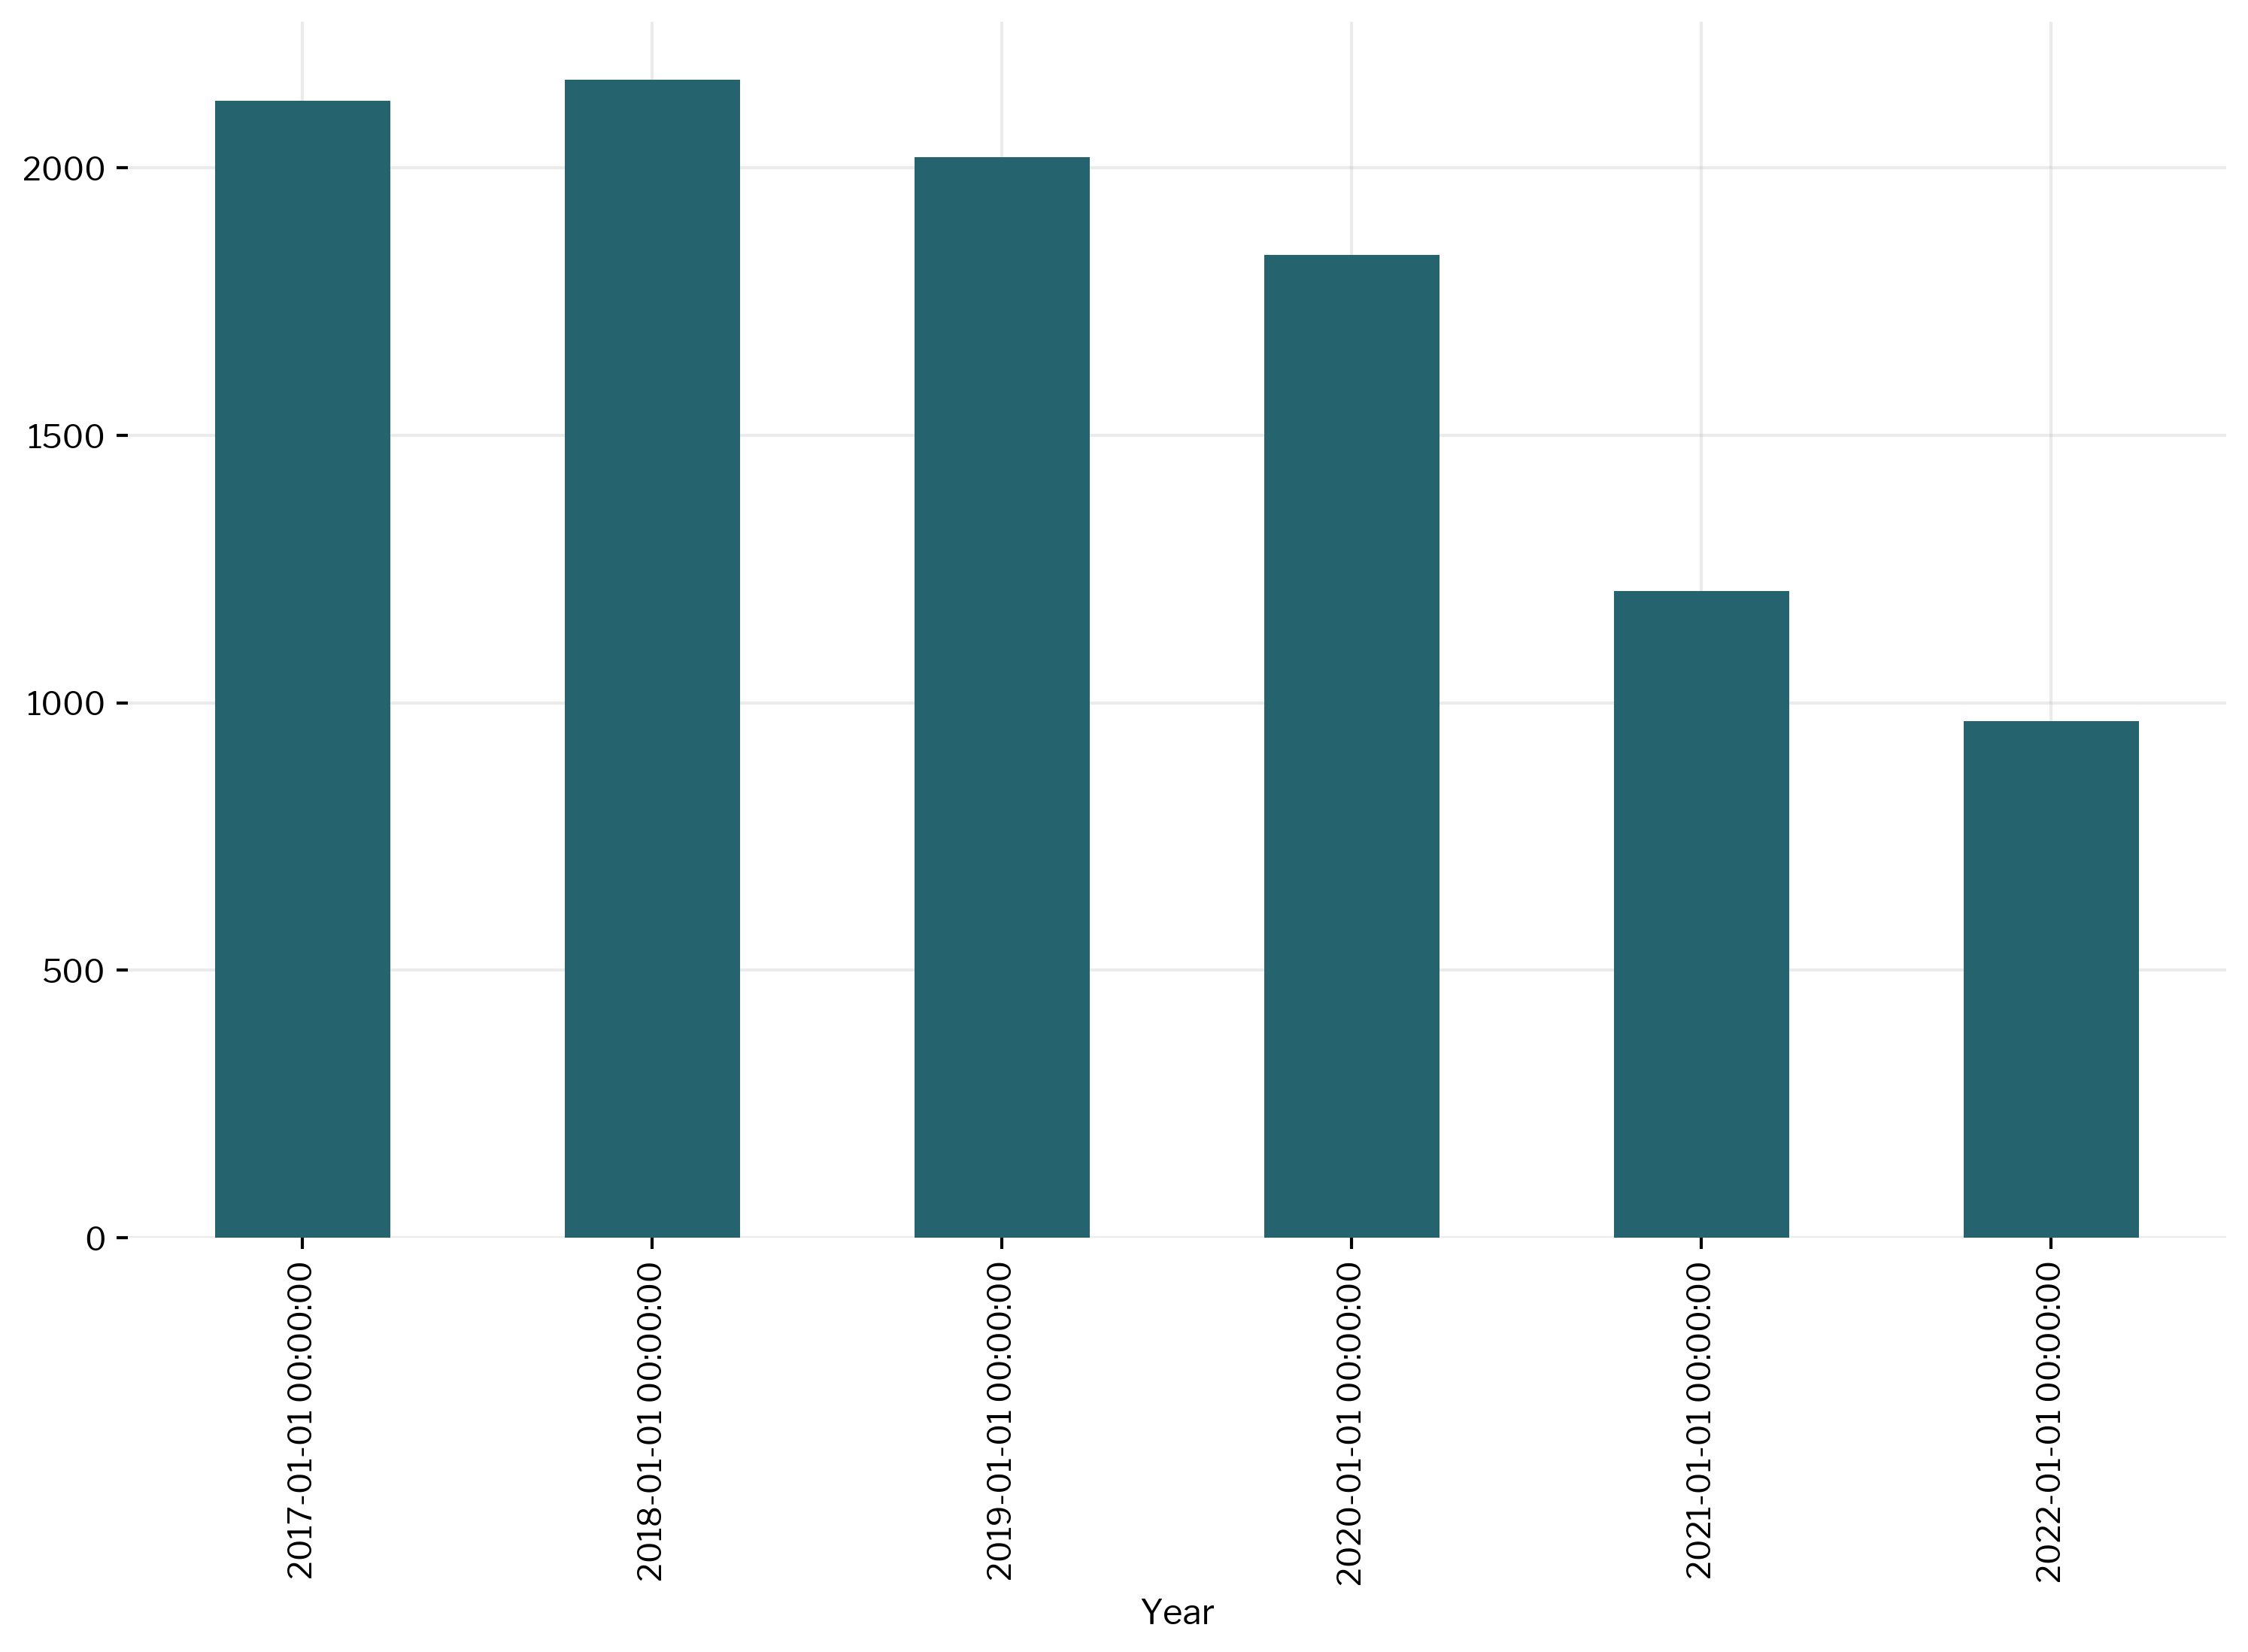

In [11]:
pa_mj_arrest_data_clean.avg_arrests_per_month.plot.bar()

### Set up transition dates flows table

In [12]:
inc_outcomes = pd.read_gbq(
    f"""
        SELECT
            sen.person_id,
            CASE
              WHEN outflow_to_level_1 = 'LIBERTY'
                THEN 'prison_to_liberty'
              WHEN outflow_to_level_2 = 'PAROLE'
                THEN 'prison_to_parole'
            END as outcome,
            session_length_days / max_sentence_length_days_calculated as percent_stay,
        FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
        JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
            ON ses.person_id = sen.person_id 
            AND ses.start_date BETWEEN sen.effective_date AND COALESCE(sen.completion_date, '9999-01-01')
        WHERE ses.state_code = 'US_PA'
            AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
            AND ses.compartment_level_1 = 'INCARCERATION'
            AND (outflow_to_level_1 = 'LIBERTY' OR outflow_to_level_2 = 'PAROLE')
            AND offense_type = "DRUGS"
        QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id ORDER BY max_sentence_length_days_calculated DESC) = 1
    """,
    project_id="recidiviz-staging",
)

In [13]:
parole_percent_stay = pd.read_gbq(
    f"""
        WITH percent_stays as (
            SELECT
                sen.person_id,
                session_length_days / max_sentence_length_days_calculated as percent_stay
            FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
            JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
                ON ses.person_id = sen.person_id 
                AND ses.start_date BETWEEN sen.effective_date AND sen.completion_date
            WHERE ses.state_code = 'US_PA'
                AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
                AND ses.inflow_from_level_1 = 'INCARCERATION'
                AND ses.compartment_level_2 = 'PAROLE'
                AND outflow_to_level_1 = 'LIBERTY'
                AND offense_type = "DRUGS"
            QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id ORDER BY sen.min_sentence_length_days_calculated DESC) = 1
        )
        SELECT
            avg(percent_stay) as avg_percent_stay
        FROM percent_stays
    """,
    project_id="recidiviz-staging",
)

In [14]:
# calculate percent of prisoners released to parole vs. liberty
parole_frac = (
    inc_outcomes.groupby("outcome").count()[["person_id"]] / inc_outcomes.shape[0]
)

# Calculate average parole stay, as a percent of prison LOS
percent_stays = inc_outcomes.groupby("outcome").percent_stay.mean()

# Create table to calculate prison/parole outflows and LOS
prison_flows = pd.concat([parole_frac, percent_stays], axis=1).rename(
    columns={"person_id": "percent_outflow"}
)
prison_flows["start_date_multiplier"] = 0

prison_flows.loc["parole_to_liberty"] = {
    "percent_outflow": prison_flows.loc["prison_to_parole", "percent_outflow"],
    "start_date_multiplier": prison_flows.loc["prison_to_parole", "percent_stay"],
    "percent_stay": parole_percent_stay.avg_percent_stay[0]
    + prison_flows.loc["prison_to_parole", "percent_stay"],
}

# Manual inputs for probation and jail flows
prison_flows.loc["probation_to_liberty"] = {
    "percent_outflow": 1,
    "start_date_multiplier": 0,
    "percent_stay": 1,
}

prison_flows.loc["jail_to_liberty"] = {
    "percent_outflow": 1,
    "start_date_multiplier": 0,
    "percent_stay": 1,
}
prison_flows.reset_index(inplace=True)
prison_flows[["compartment", "outflow_to"]] = prison_flows.outcome.str.split(
    "_to_", expand=True
)

# on merge with sentences, each prison sentence will be mapped to 3 outflow rows:
# prison->parole, prison->liberty, parole->liberty
prison_flows["compartment_for_merge"] = [
    "prison",
    "prison",
    "prison",
    "probation",
    "jail",
]

prison_flows = prison_flows.rename(columns={"percent_stay": "end_date_multiplier"})
prison_flows

,outcome,percent_outflow,end_date_multiplier,start_date_multiplier,compartment,outflow_to,compartment_for_merge
0,prison_to_liberty,0.16374,0.414486,0.000000,prison,liberty,prison
1,prison_to_parole,0.83626,0.278055,0.000000,prison,parole,prison
2,parole_to_liberty,0.83626,0.774947,0.278055,parole,liberty,prison
3,probation_to_liberty,1.00000,1.000000,0.000000,probation,liberty,probation
4,jail_to_liberty,1.00000,1.000000,0.000000,jail,liberty,jail


### Set up eligible sentences table

In [15]:
def query_all_sentences(sanction: Sanction) -> pd.DataFrame:
    #     print(query)
    query = f"""
          SELECT
            CONCAT(OFF_FNAME,OFF_LNAME,OFF_RACE,OFF_SEX,IFNULL(SAFE.PARSE_DATE('%F', SPLIT(DOB,' ')[OFFSET(0)]),"1111-11-11")) AS ID,
            SAFE.PARSE_DATE('%F', SPLIT(DOS,' ')[OFFSET(0)]) dos,
            REGEXP_CONTAINS(DRUG,r'(?i)marij') is_mj_offense,
            DRUG drug_type,
            CASE 
              WHEN off_race = 'White' THEN 'White'
              WHEN off_race = 'Black' THEN 'Black'
              ELSE 'Other'
            END as race,
            ofn_label as description,
            REGEXP_CONTAINS(ofn_label, r'(?i)(deliv)') as is_mj_sale,
            ogs as gravity_score,
            CASE
              WHEN MS_SANCTION LIKE CONCAT('%1%')
                THEN 'prison'
              WHEN MS_SANCTION LIKE CONCAT('%3%')
                THEN 'jail'
              WHEN MS_SANCTION LIKE CONCAT('%5%')
                THEN 'probation'
            END as sentence_compartment,
            JP_MIN as jp_min,
            JP_MAX as jp_max,
            CASE
              WHEN MS_SANCTION LIKE CONCAT('%1%') OR  MS_SANCTION LIKE CONCAT('%3%')
                THEN INC_RELATIONSHIP
              WHEN MS_SANCTION LIKE CONCAT('%5%')
                THEN PROB_RELATIONSHIP
            END as consecutive,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.start_date},' ')[OFFSET(0)]) start_date,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.end_date},' ')[OFFSET(0)]) end_date,
            SAFE_CAST({sanction.los} AS FLOAT64) los,
          FROM `recidiviz-staging.spark_public_input_data.us_pa_charge_data_2022_nov` pa
          WHERE {sanction.name} = '1.0'
        """
    return pd.read_gbq(
        query,
        project_id="recidiviz-staging",
    )

In [16]:
prisonsen = query_all_sentences(PRISON)

In [17]:
jailsen = query_all_sentences(JAILMIN)

In [18]:
probationsen = query_all_sentences(PROBATION)

In [19]:
allsenraw = pd.concat([prisonsen, jailsen, probationsen])

In [20]:
def resentence_converter(x):
    if "Full" in x:
        return 1
    elif "No" in x:
        return 0
    else:
        return int(x.split("%")[0]) * 0.01

In [21]:
sen_reduction = (
    pd.read_excel(
        "PA Crime Classification Worksheet.xlsx",
        usecols=[0, 4],
        converters={"Recommended Reclassification Group": resentence_converter},
    )
    .rename(columns={"Recommended Reclassification Group": "reduction"})
    .fillna(0.05)
)

In [22]:
allsen = pd.merge(
    allsenraw,
    sen_reduction,
    how="left",
    on="description",
)

In [23]:
allsen["start_date"] = pd.to_datetime(allsen.start_date, errors="coerce")
allsen = allsen[allsen.start_date.notnull() & allsen.los.notnull()]
allsen.reduction = allsen.reduction.mask(allsen.is_mj_offense, 1).fillna(0.05)

In [24]:
sentence_grouping = ["ID", "dos", "sentence_compartment"]
mj_crimes = allsen[allsen.is_mj_offense][sentence_grouping + ["is_mj_offense"]]

In [25]:
# Get all sentence groups (sentences assigned to the same person on the same date)
# where at least 1 sentence is marijuana related
# and no sentence is violent
sentence_groups = pd.merge(
    allsen,
    mj_crimes,
    how="left",
    on=sentence_grouping,
    suffixes=[None, "_check"],
)
sentence_groups_with_mj = sentence_groups[
    sentence_groups.is_mj_offense_check
].drop_duplicates()

In [26]:
sentence_groups_with_mj["lowest_reduction"] = sentence_groups_with_mj.groupby(
    sentence_grouping
).reduction.transform("min")

In [27]:
sentence_groups_with_mj["crime_type"] = np.where(
    sentence_groups_with_mj.lowest_reduction == 1, "only_mj", "mj_plus"
)
sentence_groups_with_mj["is_mj_effective"] = sentence_groups_with_mj.reduction == 1

In [28]:
# Remove all marijuana and marijuana-adjacent crimes (those that have sen_reduction == 1)
sentence_groups_mj_removed = sentence_groups_with_mj[
    ~sentence_groups_with_mj.is_mj_effective
].copy()

In [29]:
# adjust post-policy los by lowest sen_reduction withing sentence group
sentence_groups_mj_removed["los"] = (
    1 - sentence_groups_mj_removed.lowest_reduction
) * sentence_groups_mj_removed.los

In [30]:
def get_max_eligible_sentences(sentence_groups):
    max_eligible_sentences = (
        sentence_groups.sort_values(
            sentence_grouping + ["los"],
            ascending=[True, False, False, False],
        )
        .groupby(sentence_grouping)
        .head(1)
    )
    return max_eligible_sentences

In [31]:
def get_eligible_sessions(sentence_groups):
    max_eligible_sentences = get_max_eligible_sentences(sentence_groups)

    # merge with transition flows table to compute sessions including parole
    eligible_sessions = pd.merge(
        max_eligible_sentences,
        prison_flows,
        how="inner",
        left_on=["sentence_compartment"],
        right_on=["compartment_for_merge"],
    )

    # calculate start and end dates for parole etc.
    eligible_sessions[
        "compartment_start_date"
    ] = eligible_sessions.start_date + pd.to_timedelta(
        eligible_sessions.los * eligible_sessions.start_date_multiplier * 30.4, unit="D"
    )
    eligible_sessions[
        "release_to_outflow"
    ] = eligible_sessions.start_date + pd.to_timedelta(
        eligible_sessions.los * eligible_sessions.end_date_multiplier * 30.4, unit="D"
    )

    # calculate los and convert dates to normalized time steps
    eligible_sessions["estimated_los"] = (
        eligible_sessions.release_to_outflow - eligible_sessions.compartment_start_date
    )
    eligible_sessions["estimated_los_months"] = np.round(
        eligible_sessions.estimated_los.dt.days / 30.4167
    ).astype(float)

    eligible_sessions.loc[:, "time_step"] = convert_dates(
        time_converter, eligible_sessions["compartment_start_date"]
    )
    eligible_sessions.loc[:, "time_step_end"] = convert_dates(
        time_converter, eligible_sessions["release_to_outflow"]
    )
    return eligible_sessions

In [66]:
eligible_sessions_with_mj = get_eligible_sessions(sentence_groups_with_mj)
eligible_sessions_post_policy = get_eligible_sessions(sentence_groups_mj_removed)

## Transition table

In [67]:
disaggregation_axes = ["crime_type"]

In [68]:
def get_transitions_table(sessions):
    transitions = (
        sessions[pd.to_datetime(sessions.dos) >= datetime.datetime(2017, 1, 1)]
        .groupby(
            disaggregation_axes + ["compartment", "outflow_to", "estimated_los_months"]
        )[["percent_outflow"]]
        .sum()
    )

    transitions = transitions.reset_index().rename(
        columns={
            "estimated_los_months": "compartment_duration",
            "percent_outflow": "total_population",
        }
    )

    un = [transitions[d].unique() for d in disaggregation_axes]
    manual_combos = list(itertools.product(*un))
    min_transitions_per_compartment = len(manual_combos)

    manual_transitions = pd.DataFrame(manual_combos, columns=disaggregation_axes)
    manual_transitions["compartment"] = "liberty"
    manual_transitions["outflow_to"] = "liberty"
    manual_transitions["total_population"] = 1
    manual_transitions["compartment_duration"] = 1

    transitions = pd.concat([transitions, manual_transitions])
    return transitions

In [69]:
transitions = get_transitions_table(eligible_sessions_with_mj)
transitions_policy = get_transitions_table(eligible_sessions_post_policy)

In [70]:
# add dummy rows for irrelevant only_mj crime_type
transitions_policy = pd.concat(
    [
        transitions_policy,
        transitions[transitions.crime_type == "only_mj"].groupby("compartment").head(1),
    ]
)

In [71]:
transitions_policy.to_csv("alt_transitions_policy.csv", index=False)

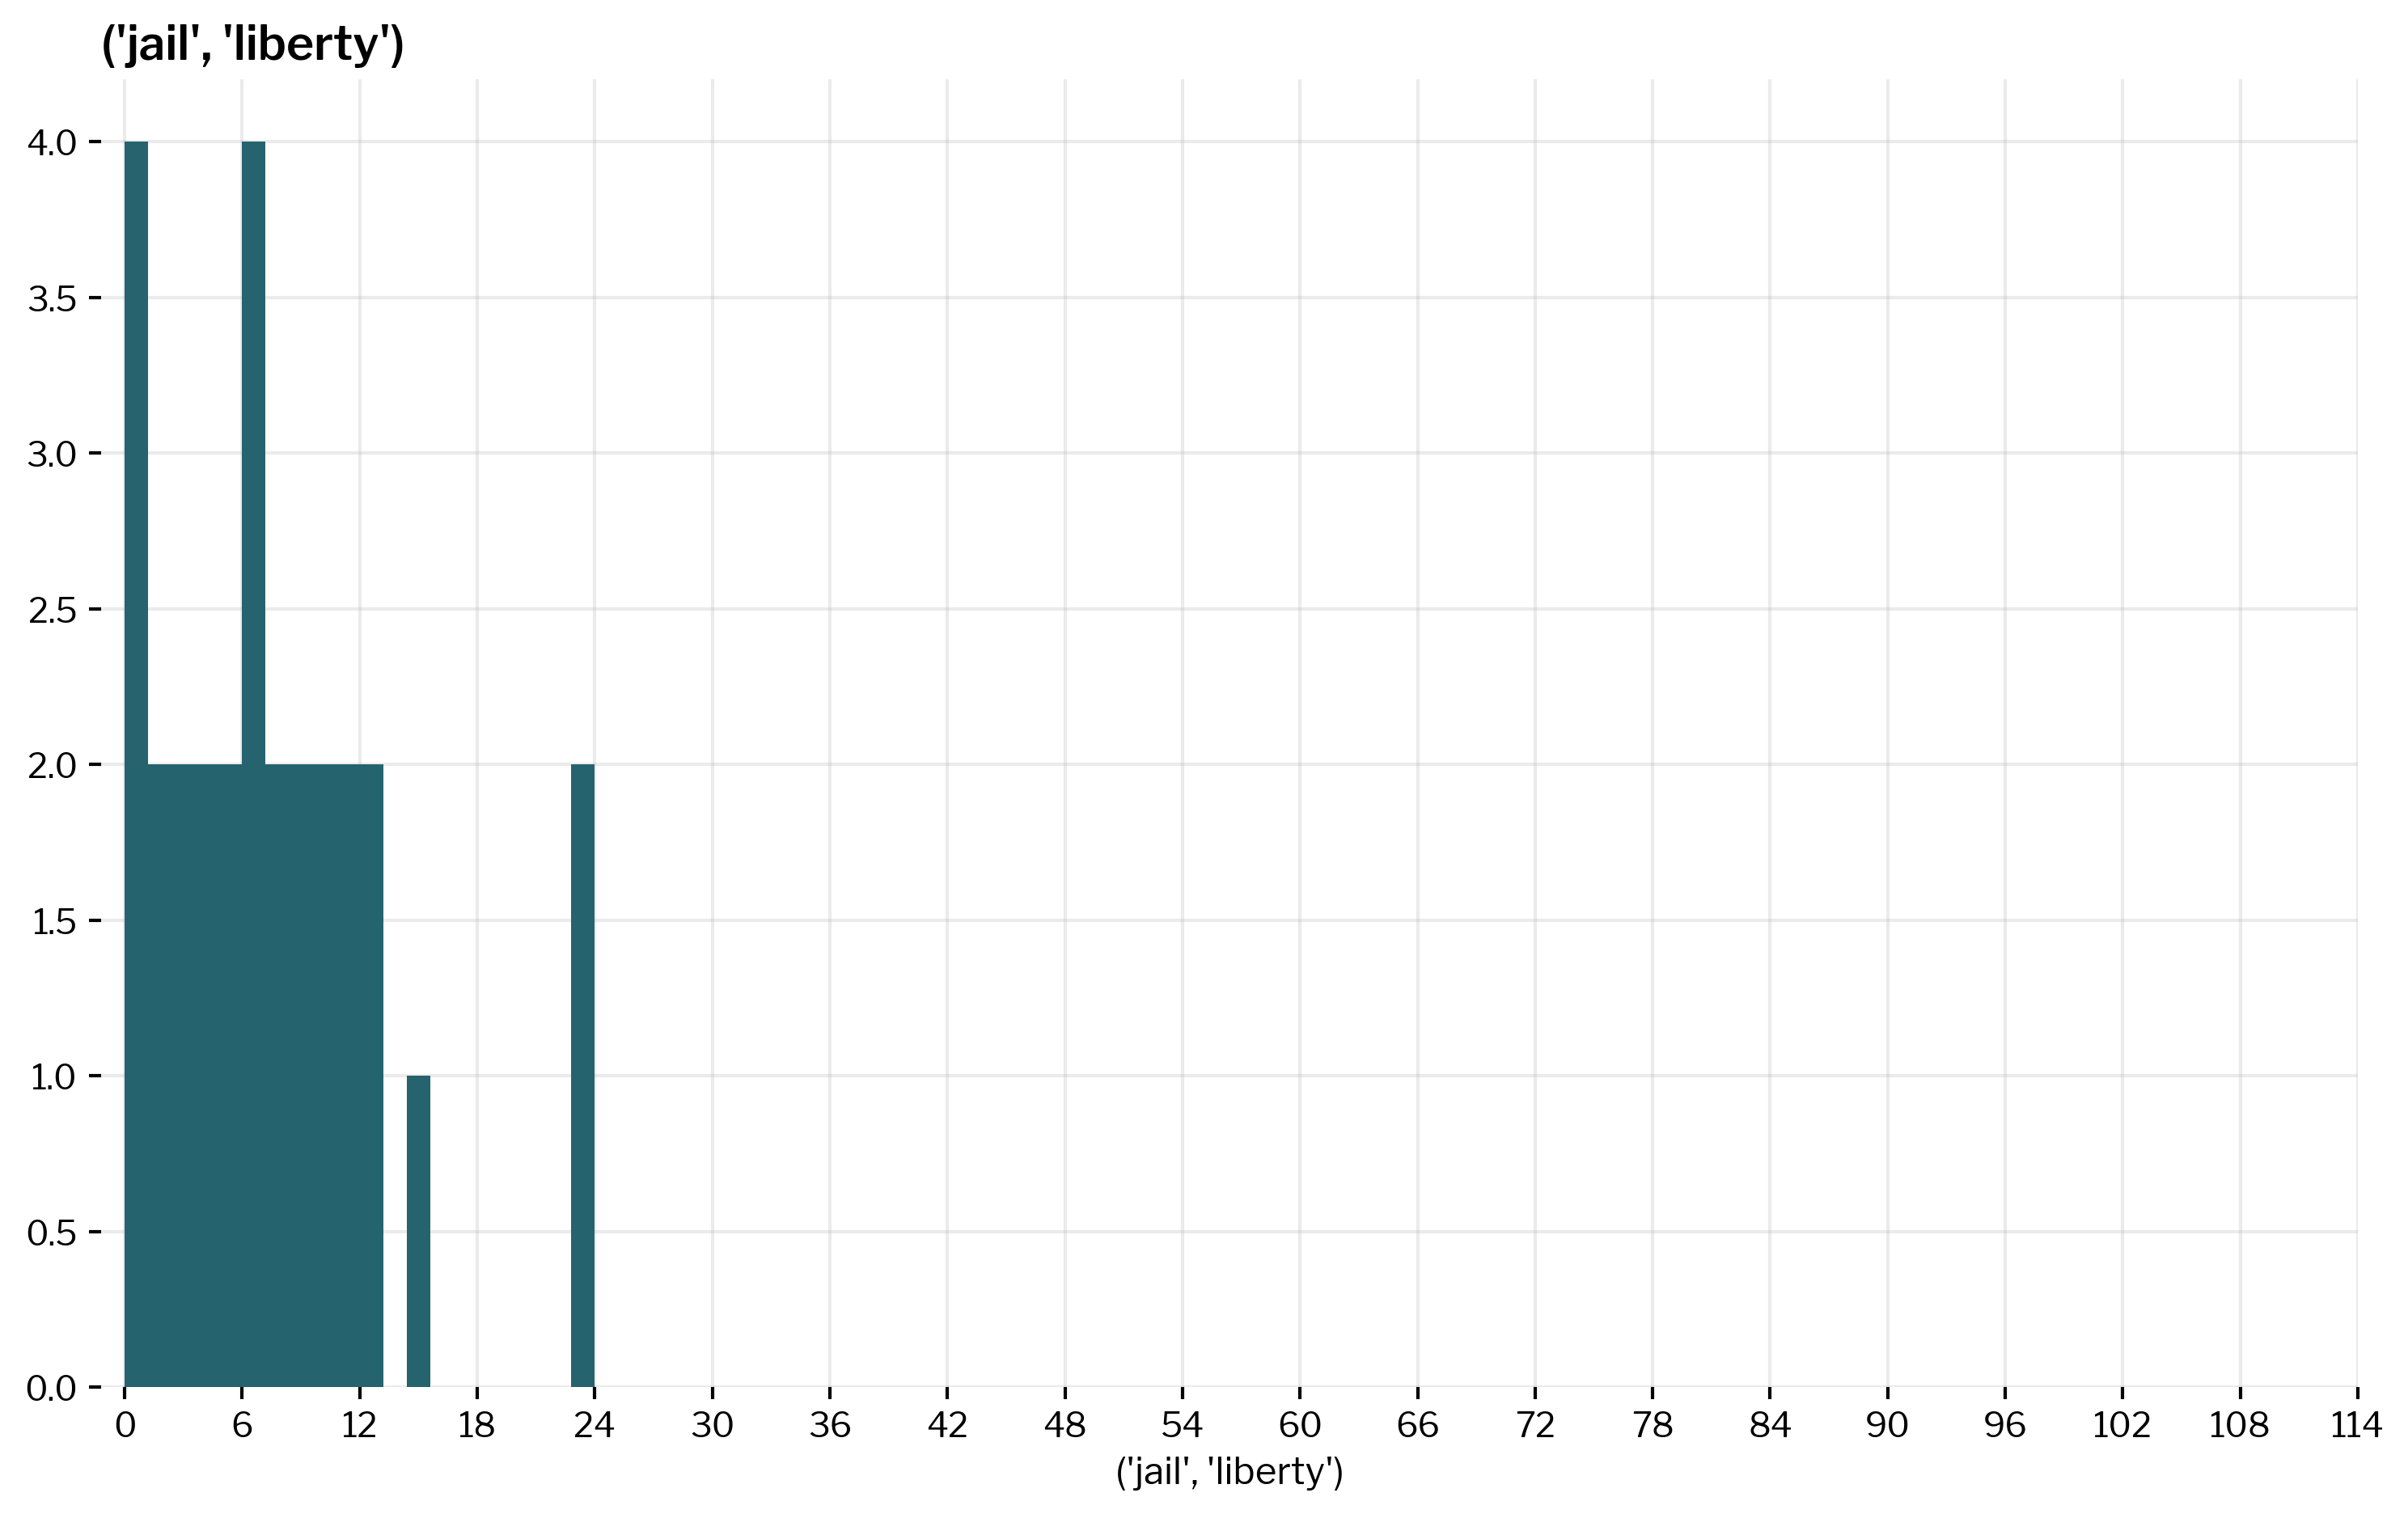

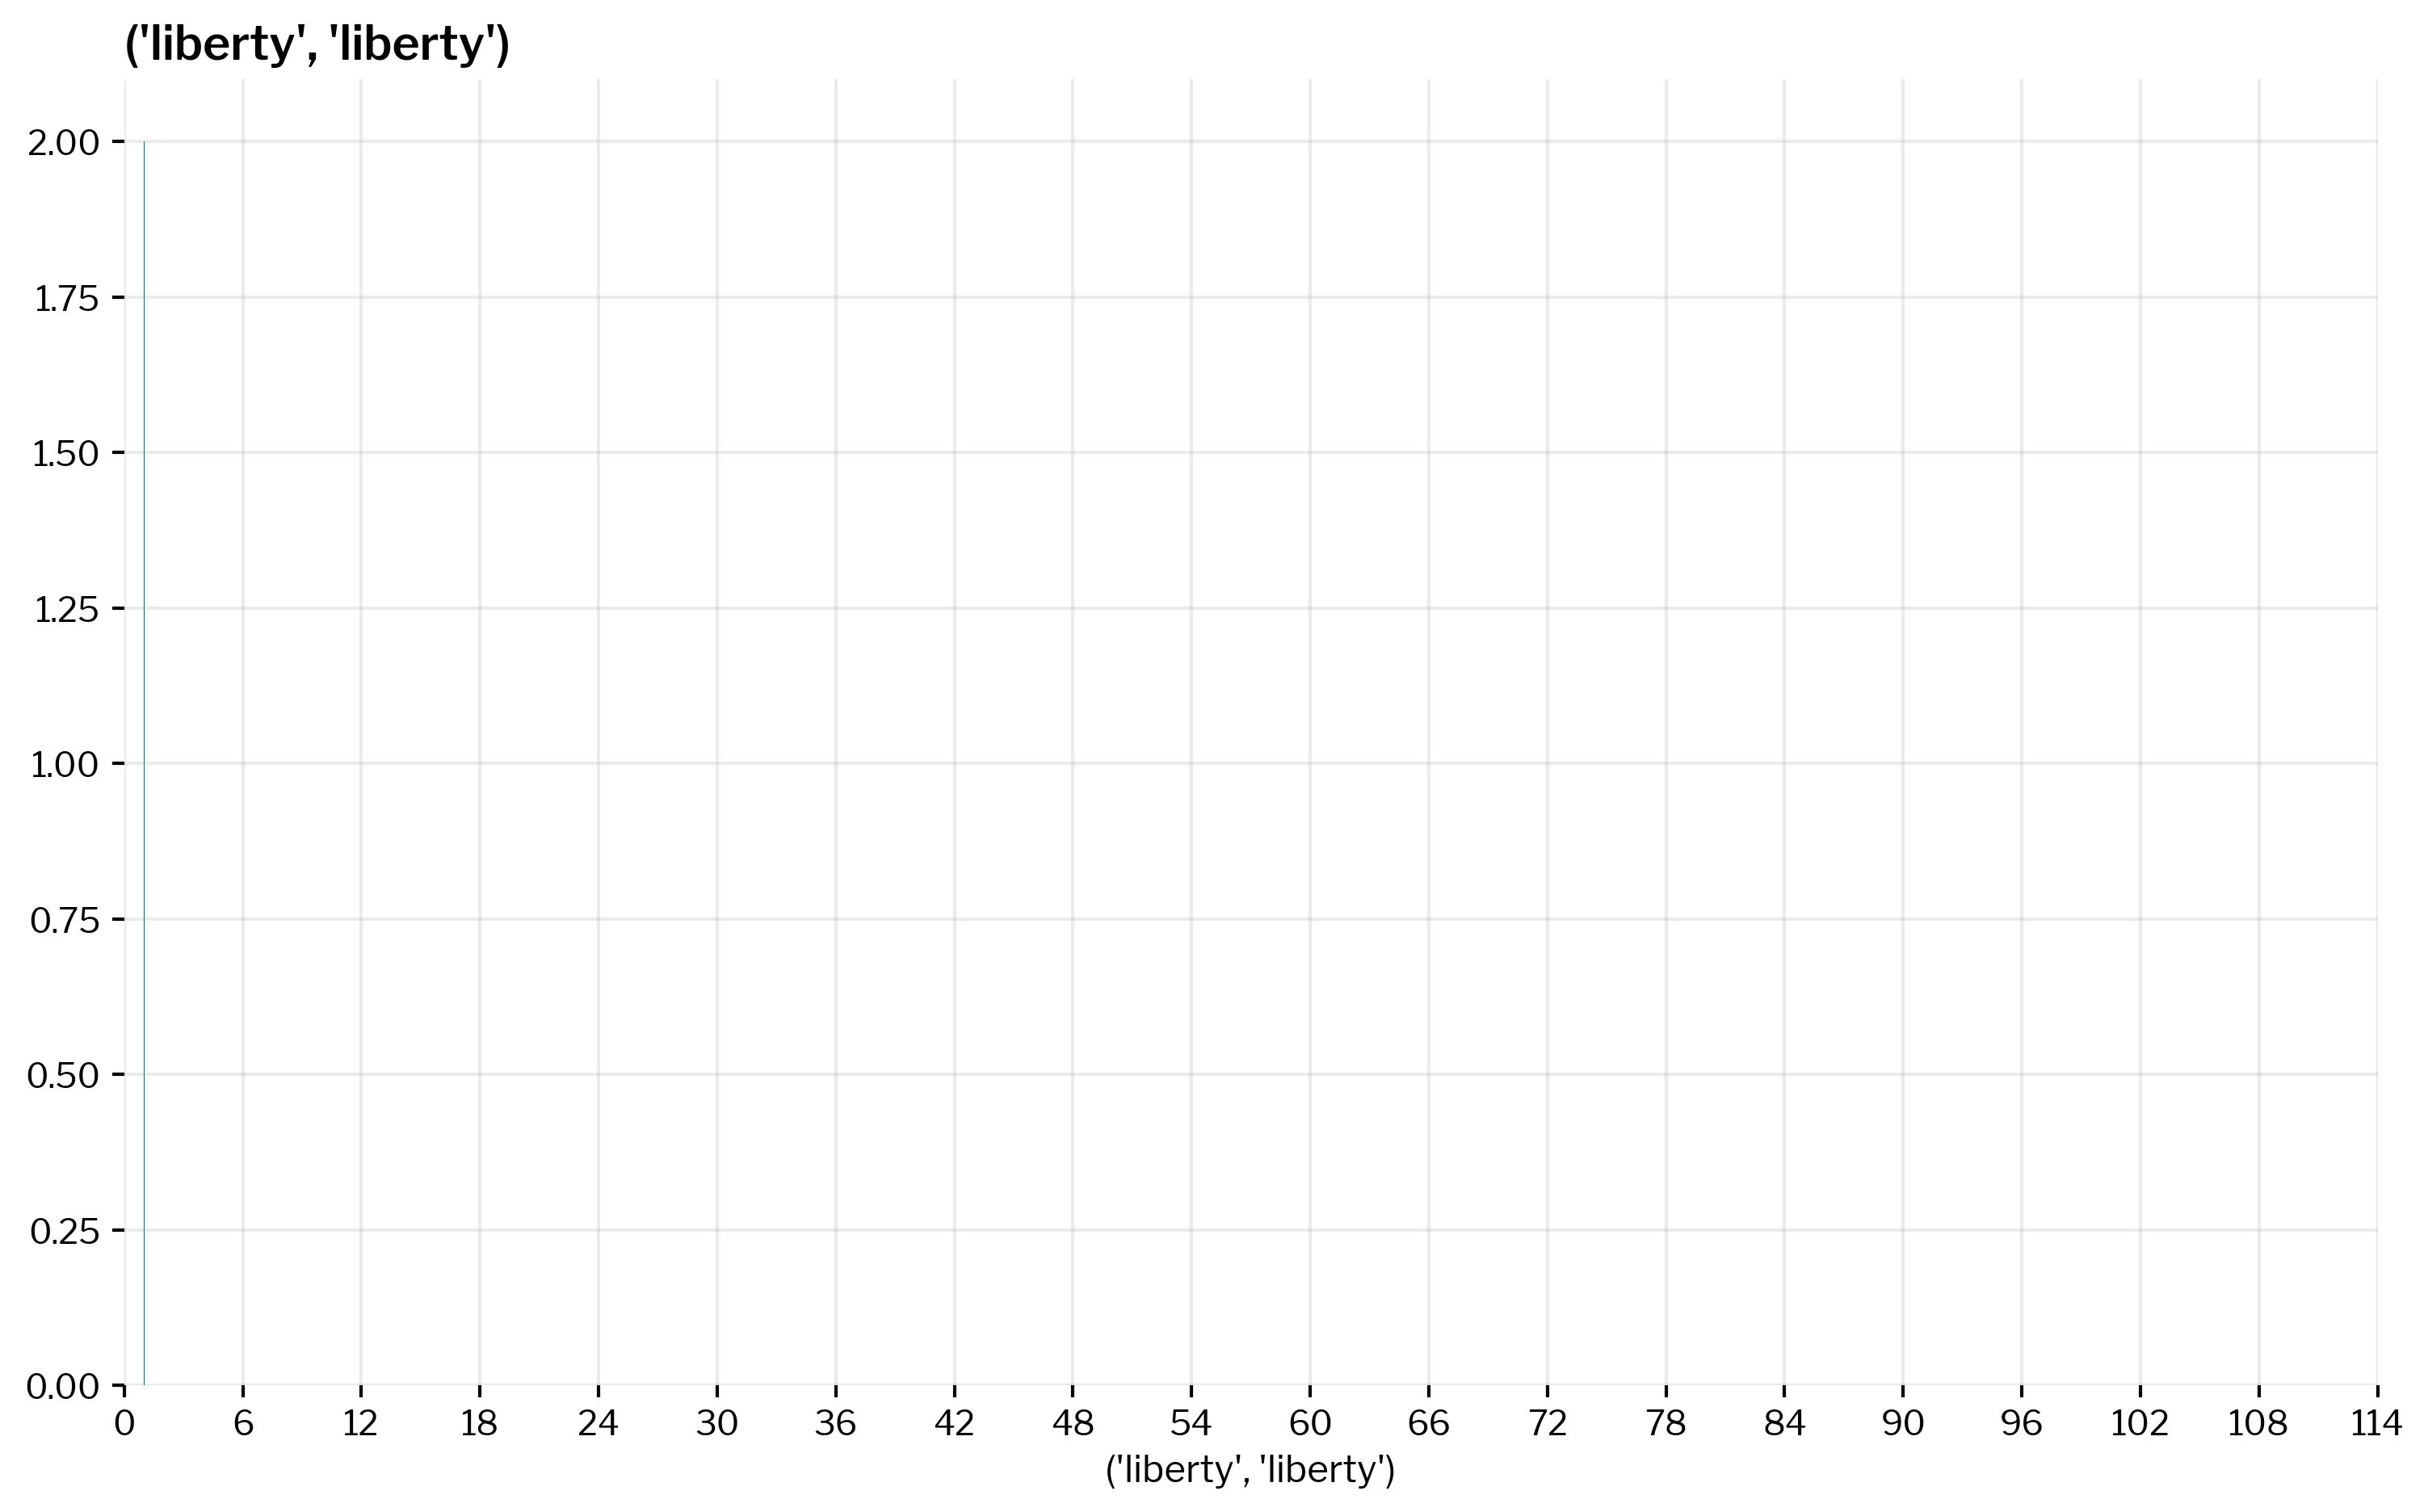

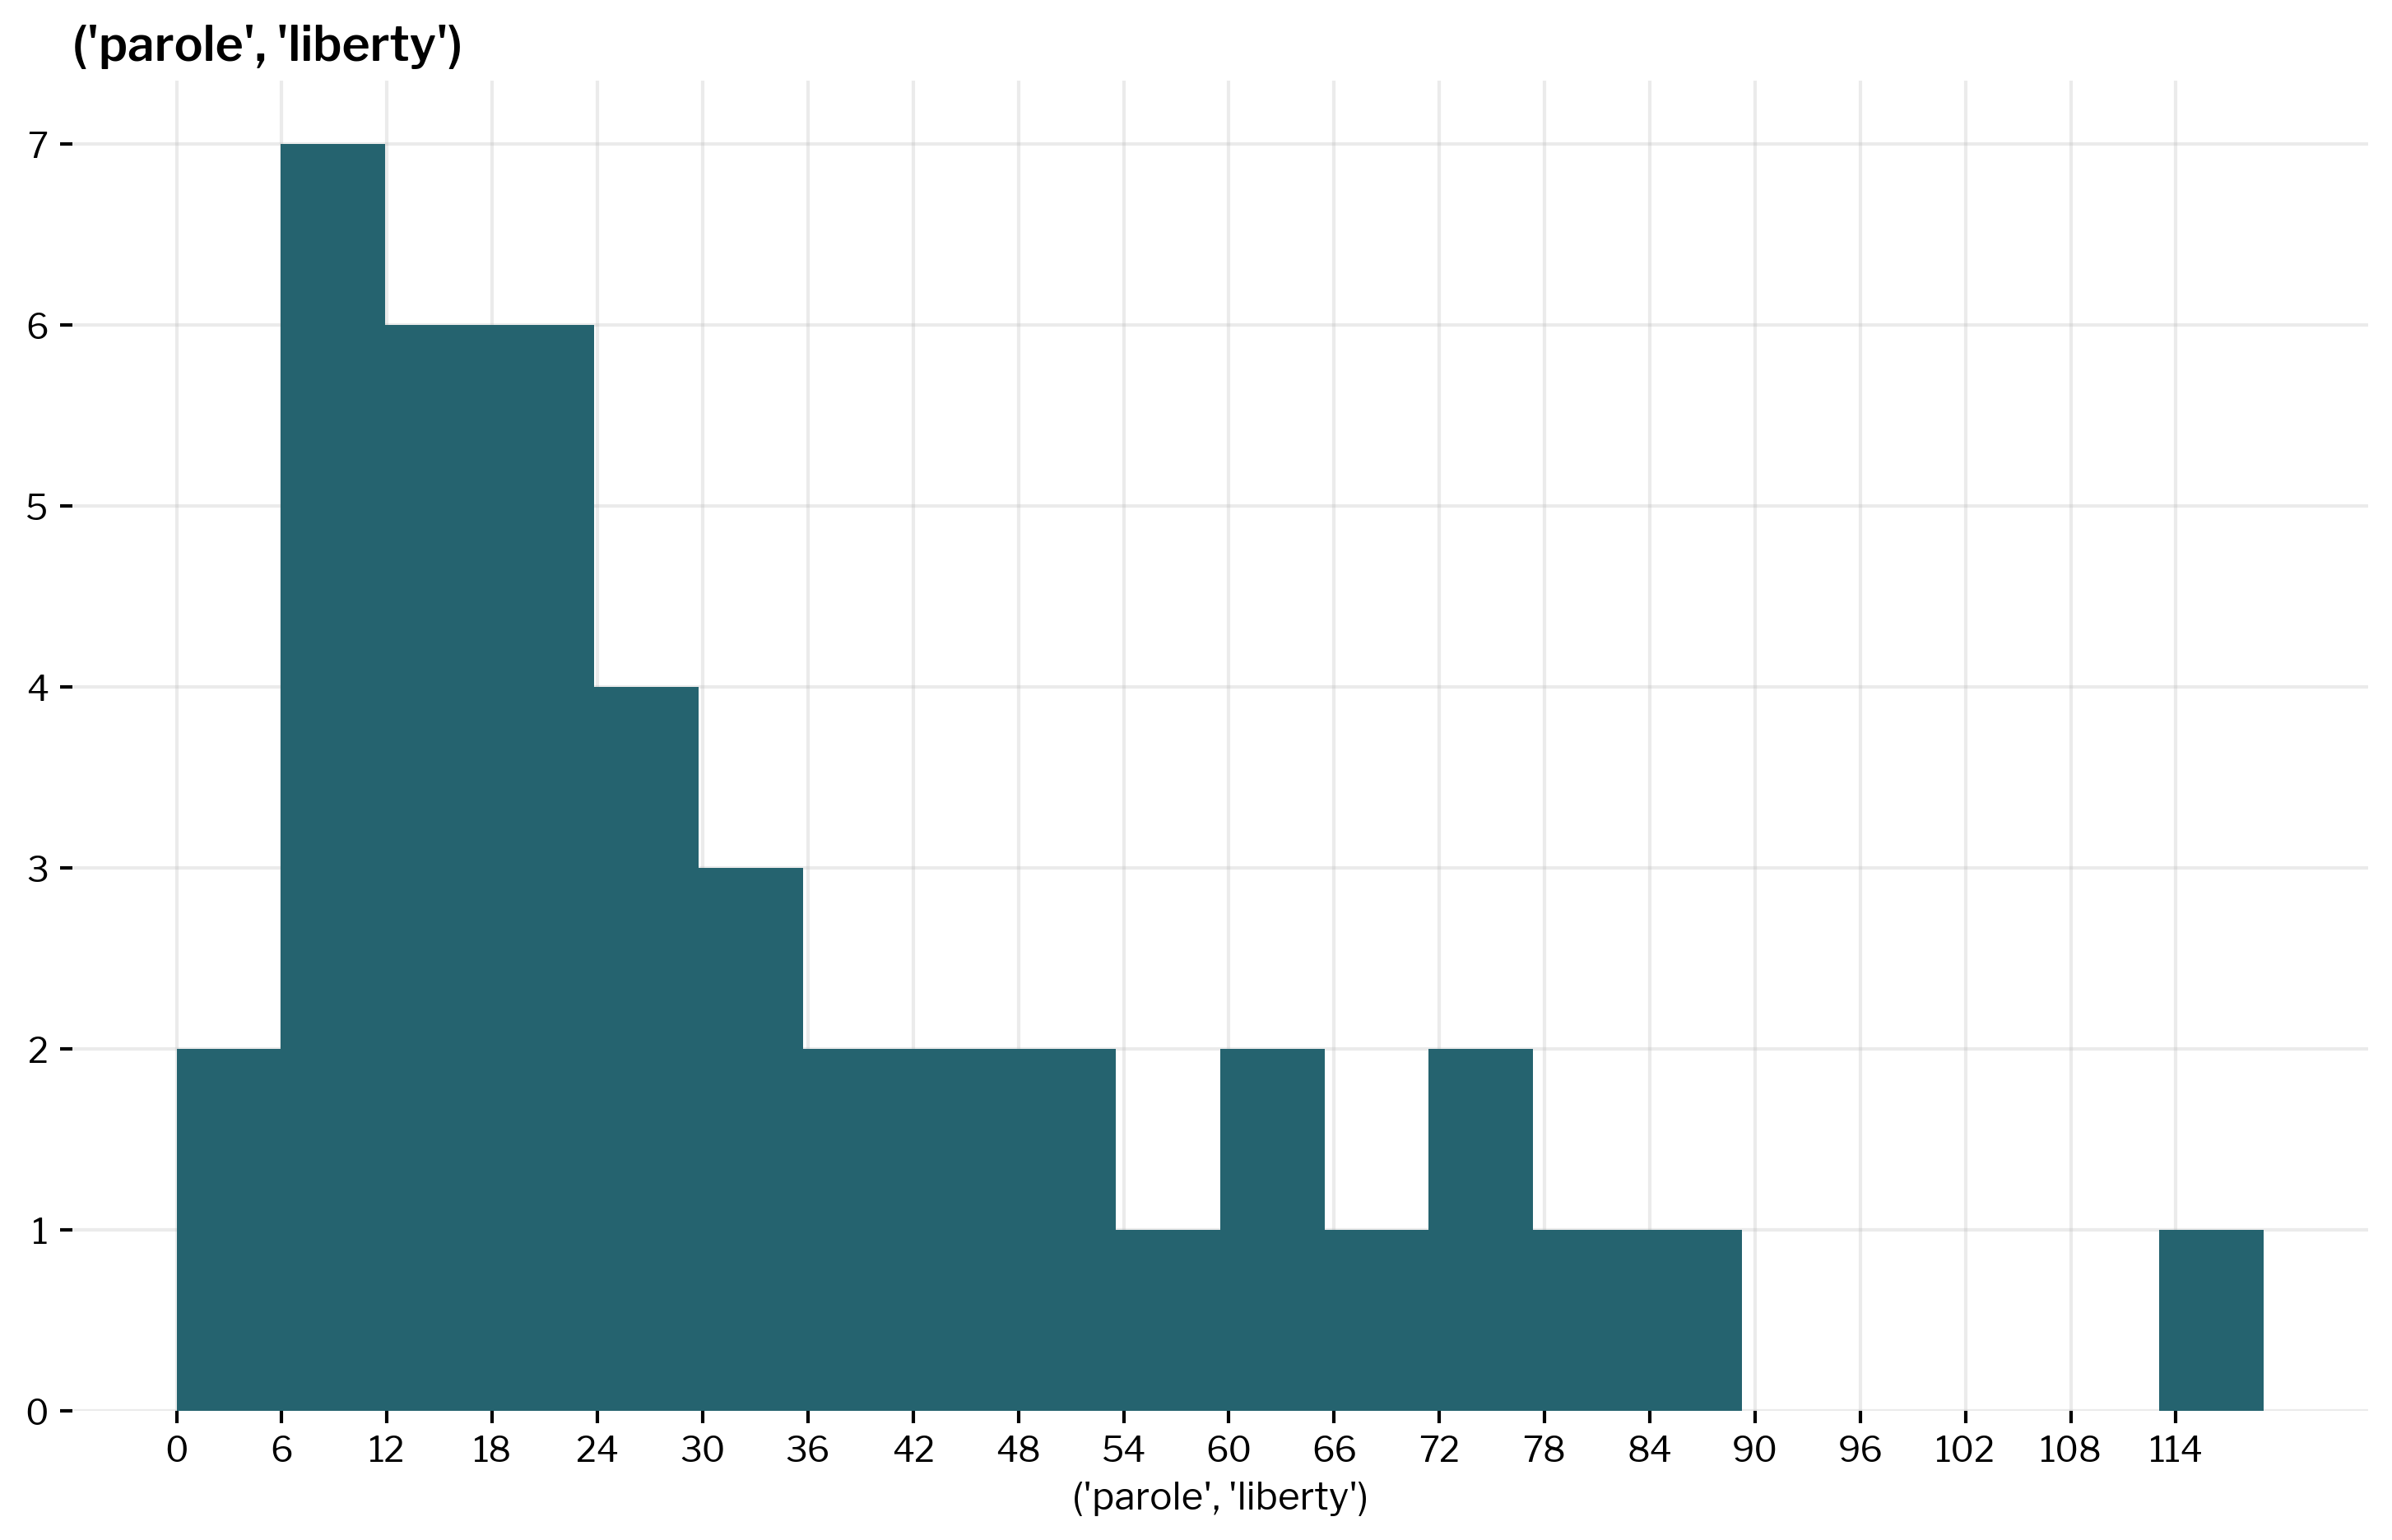

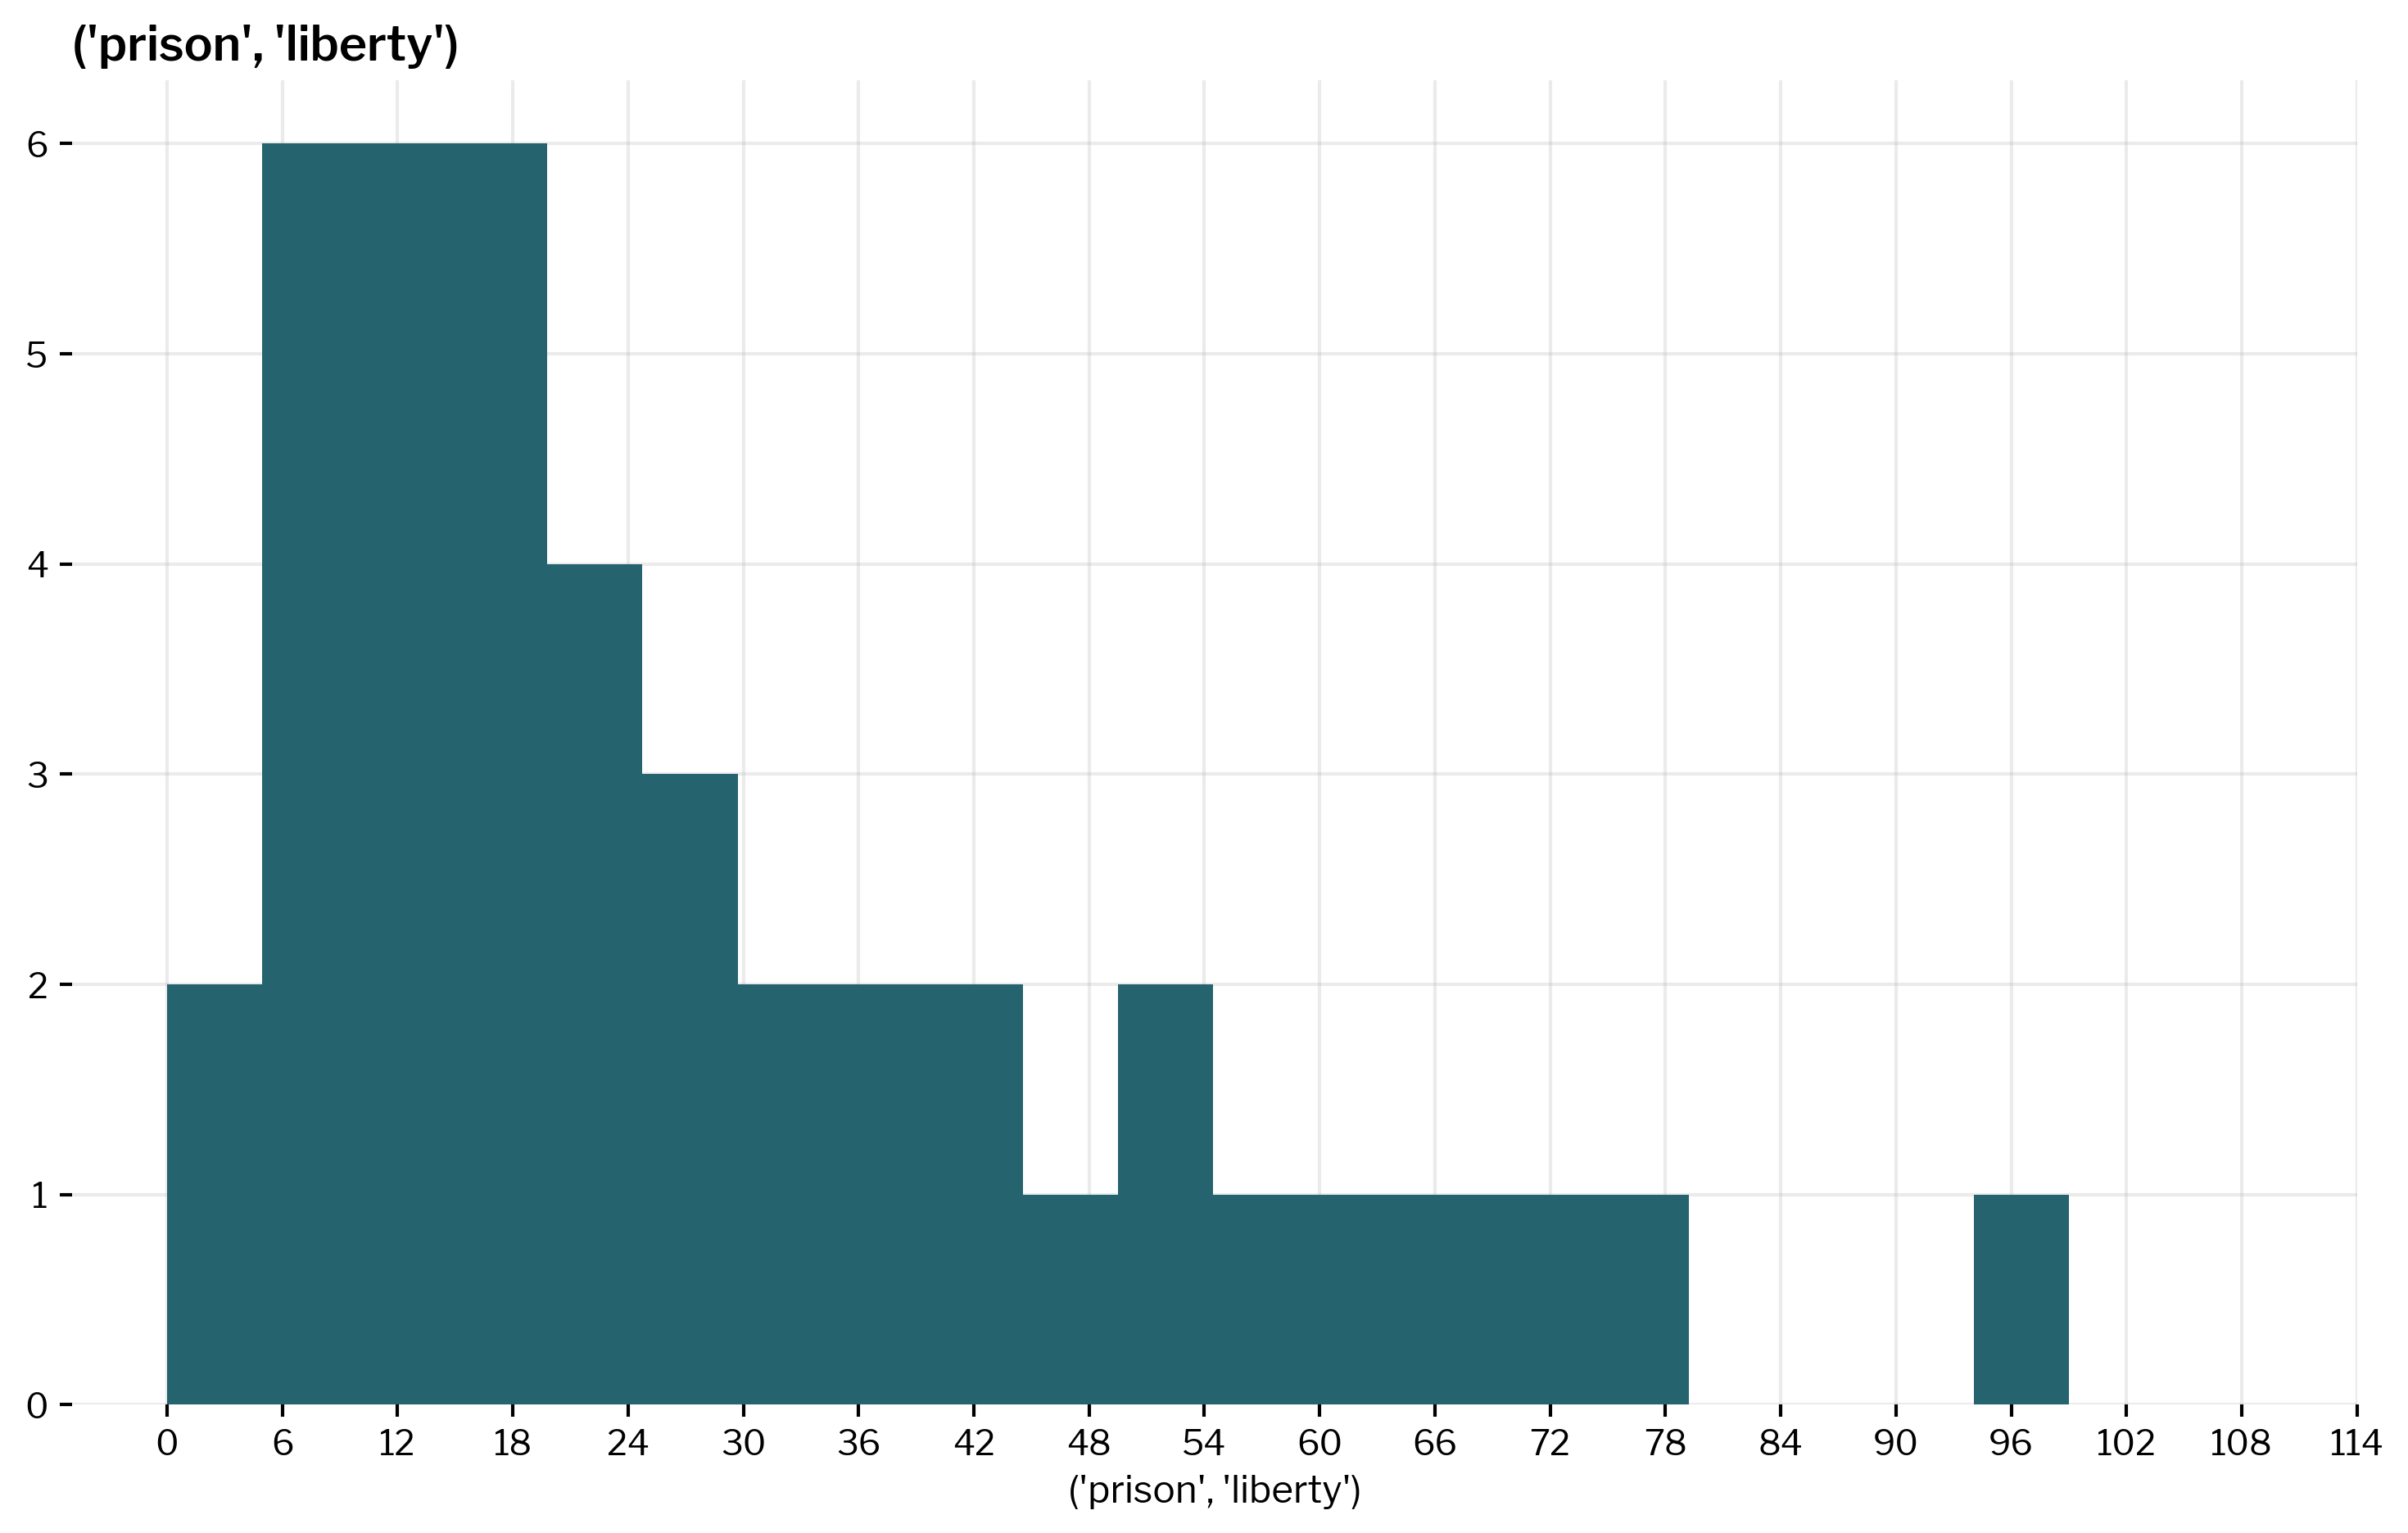

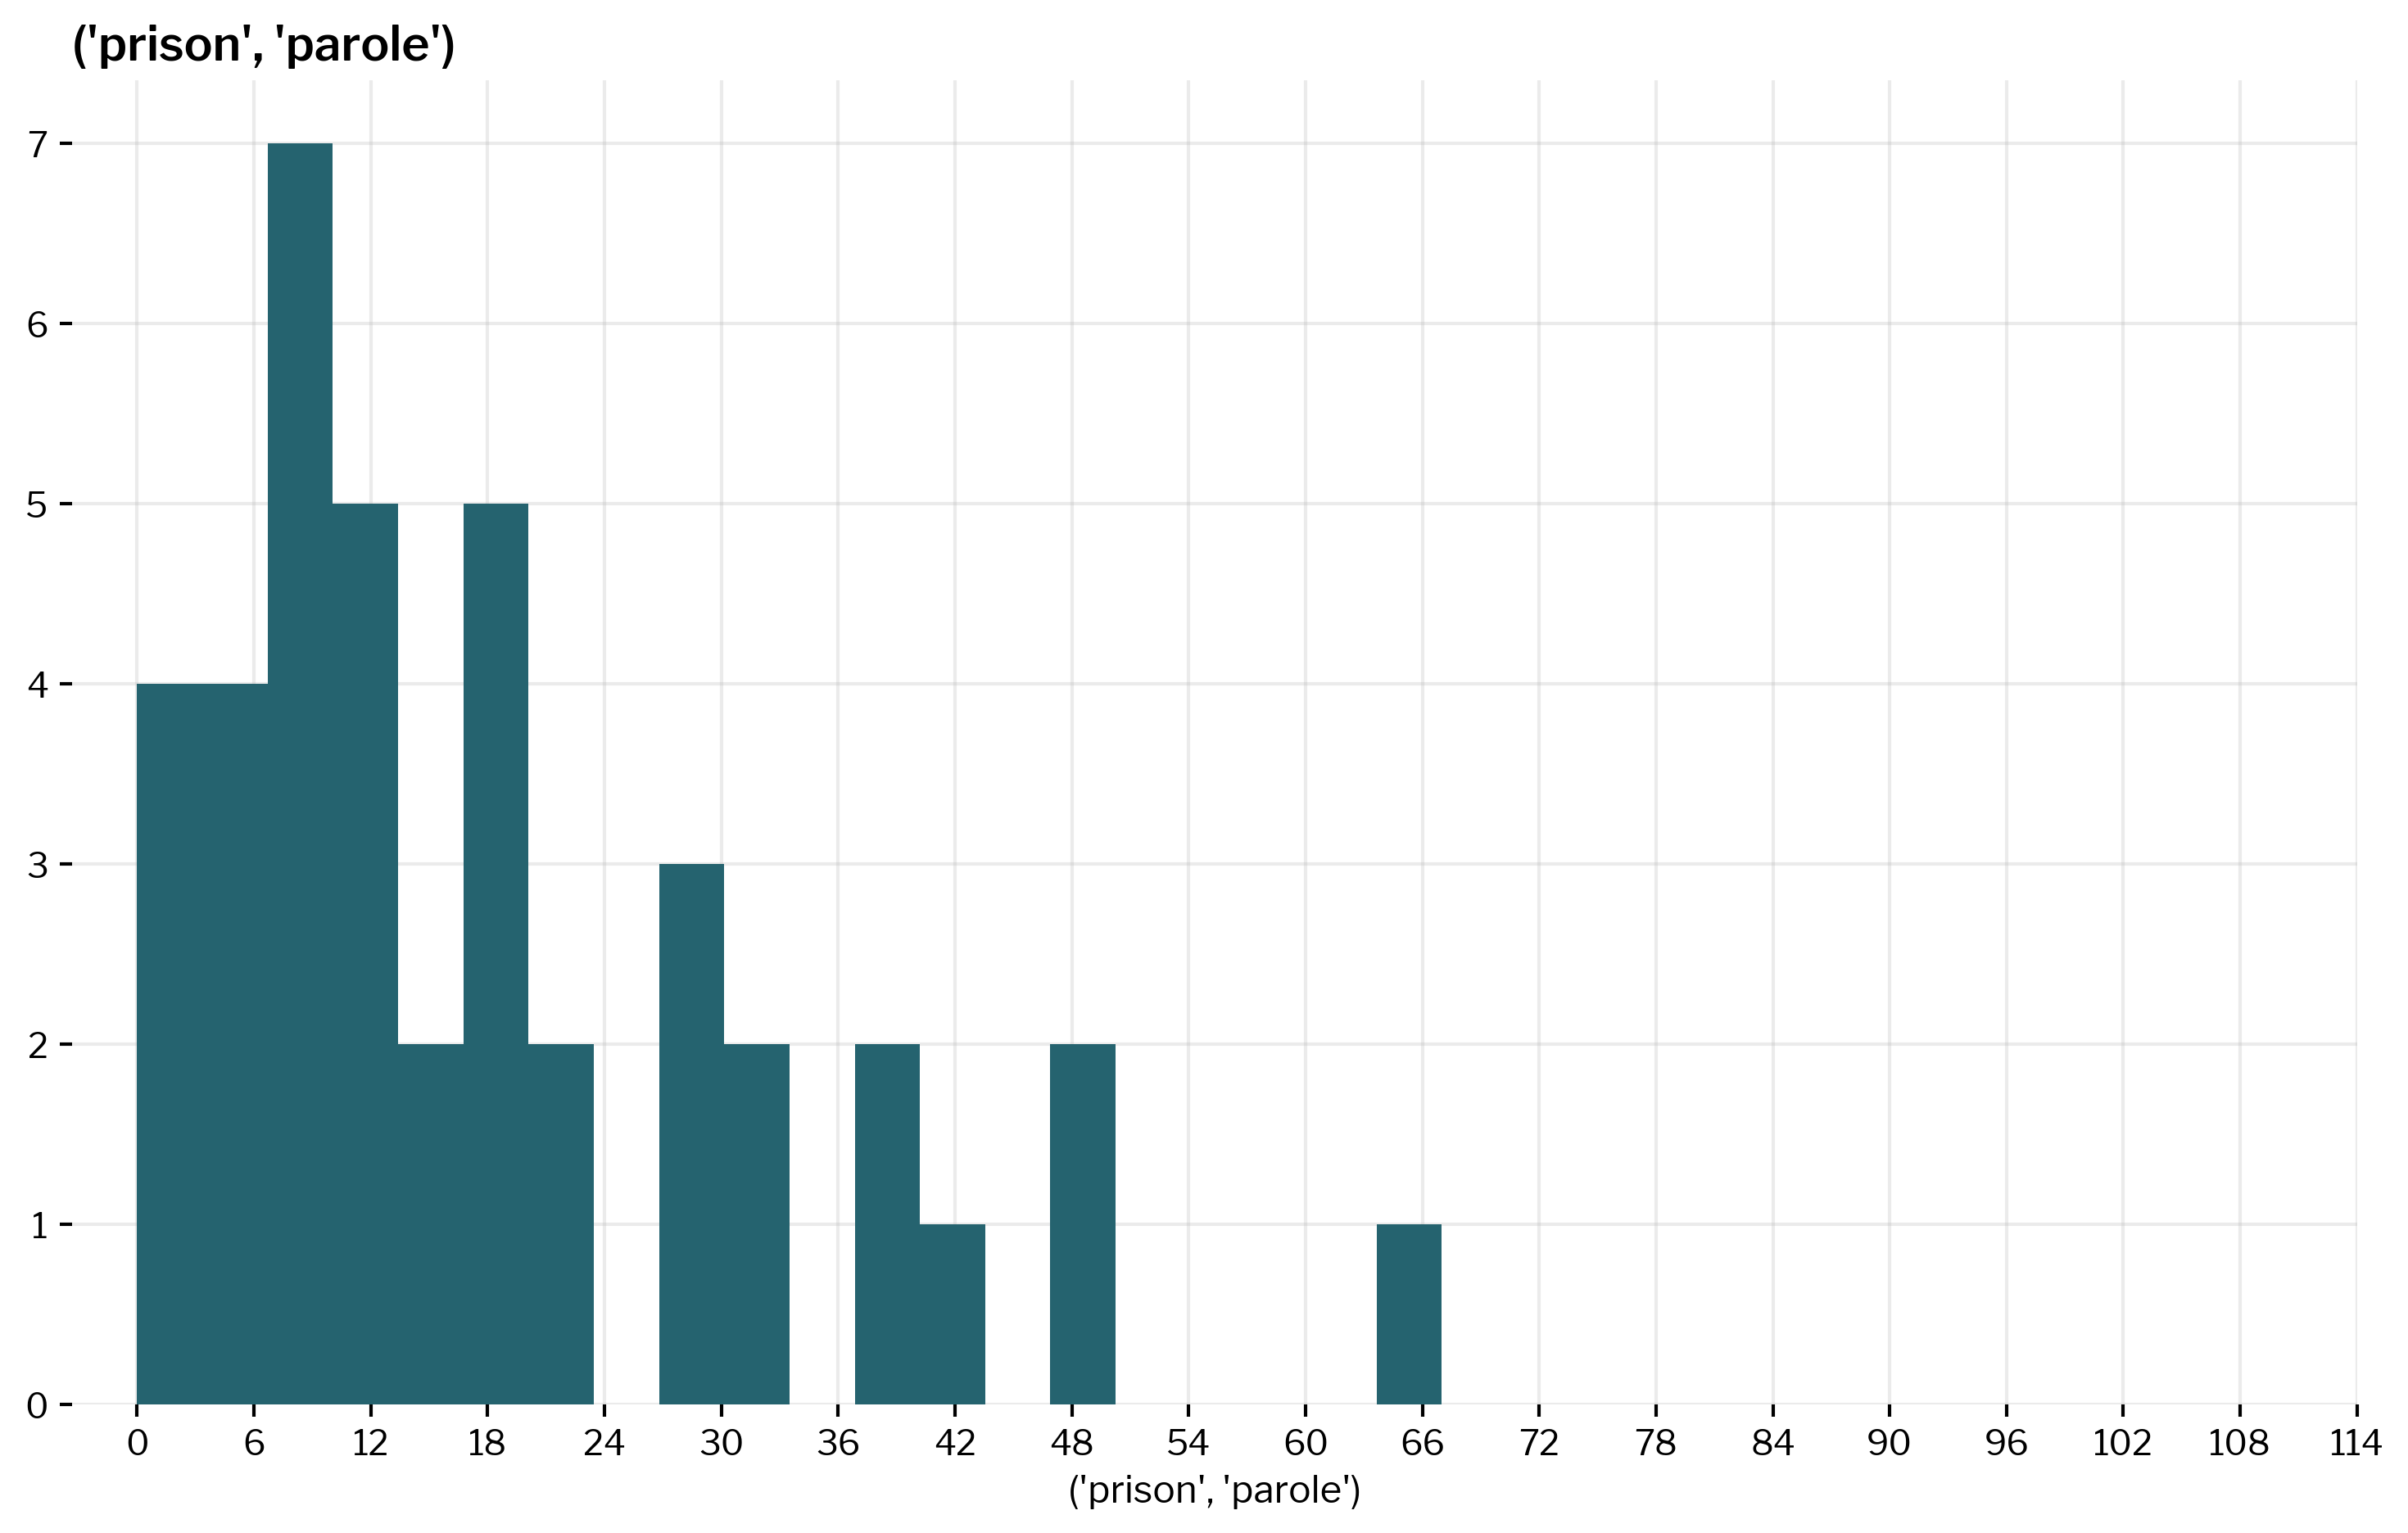

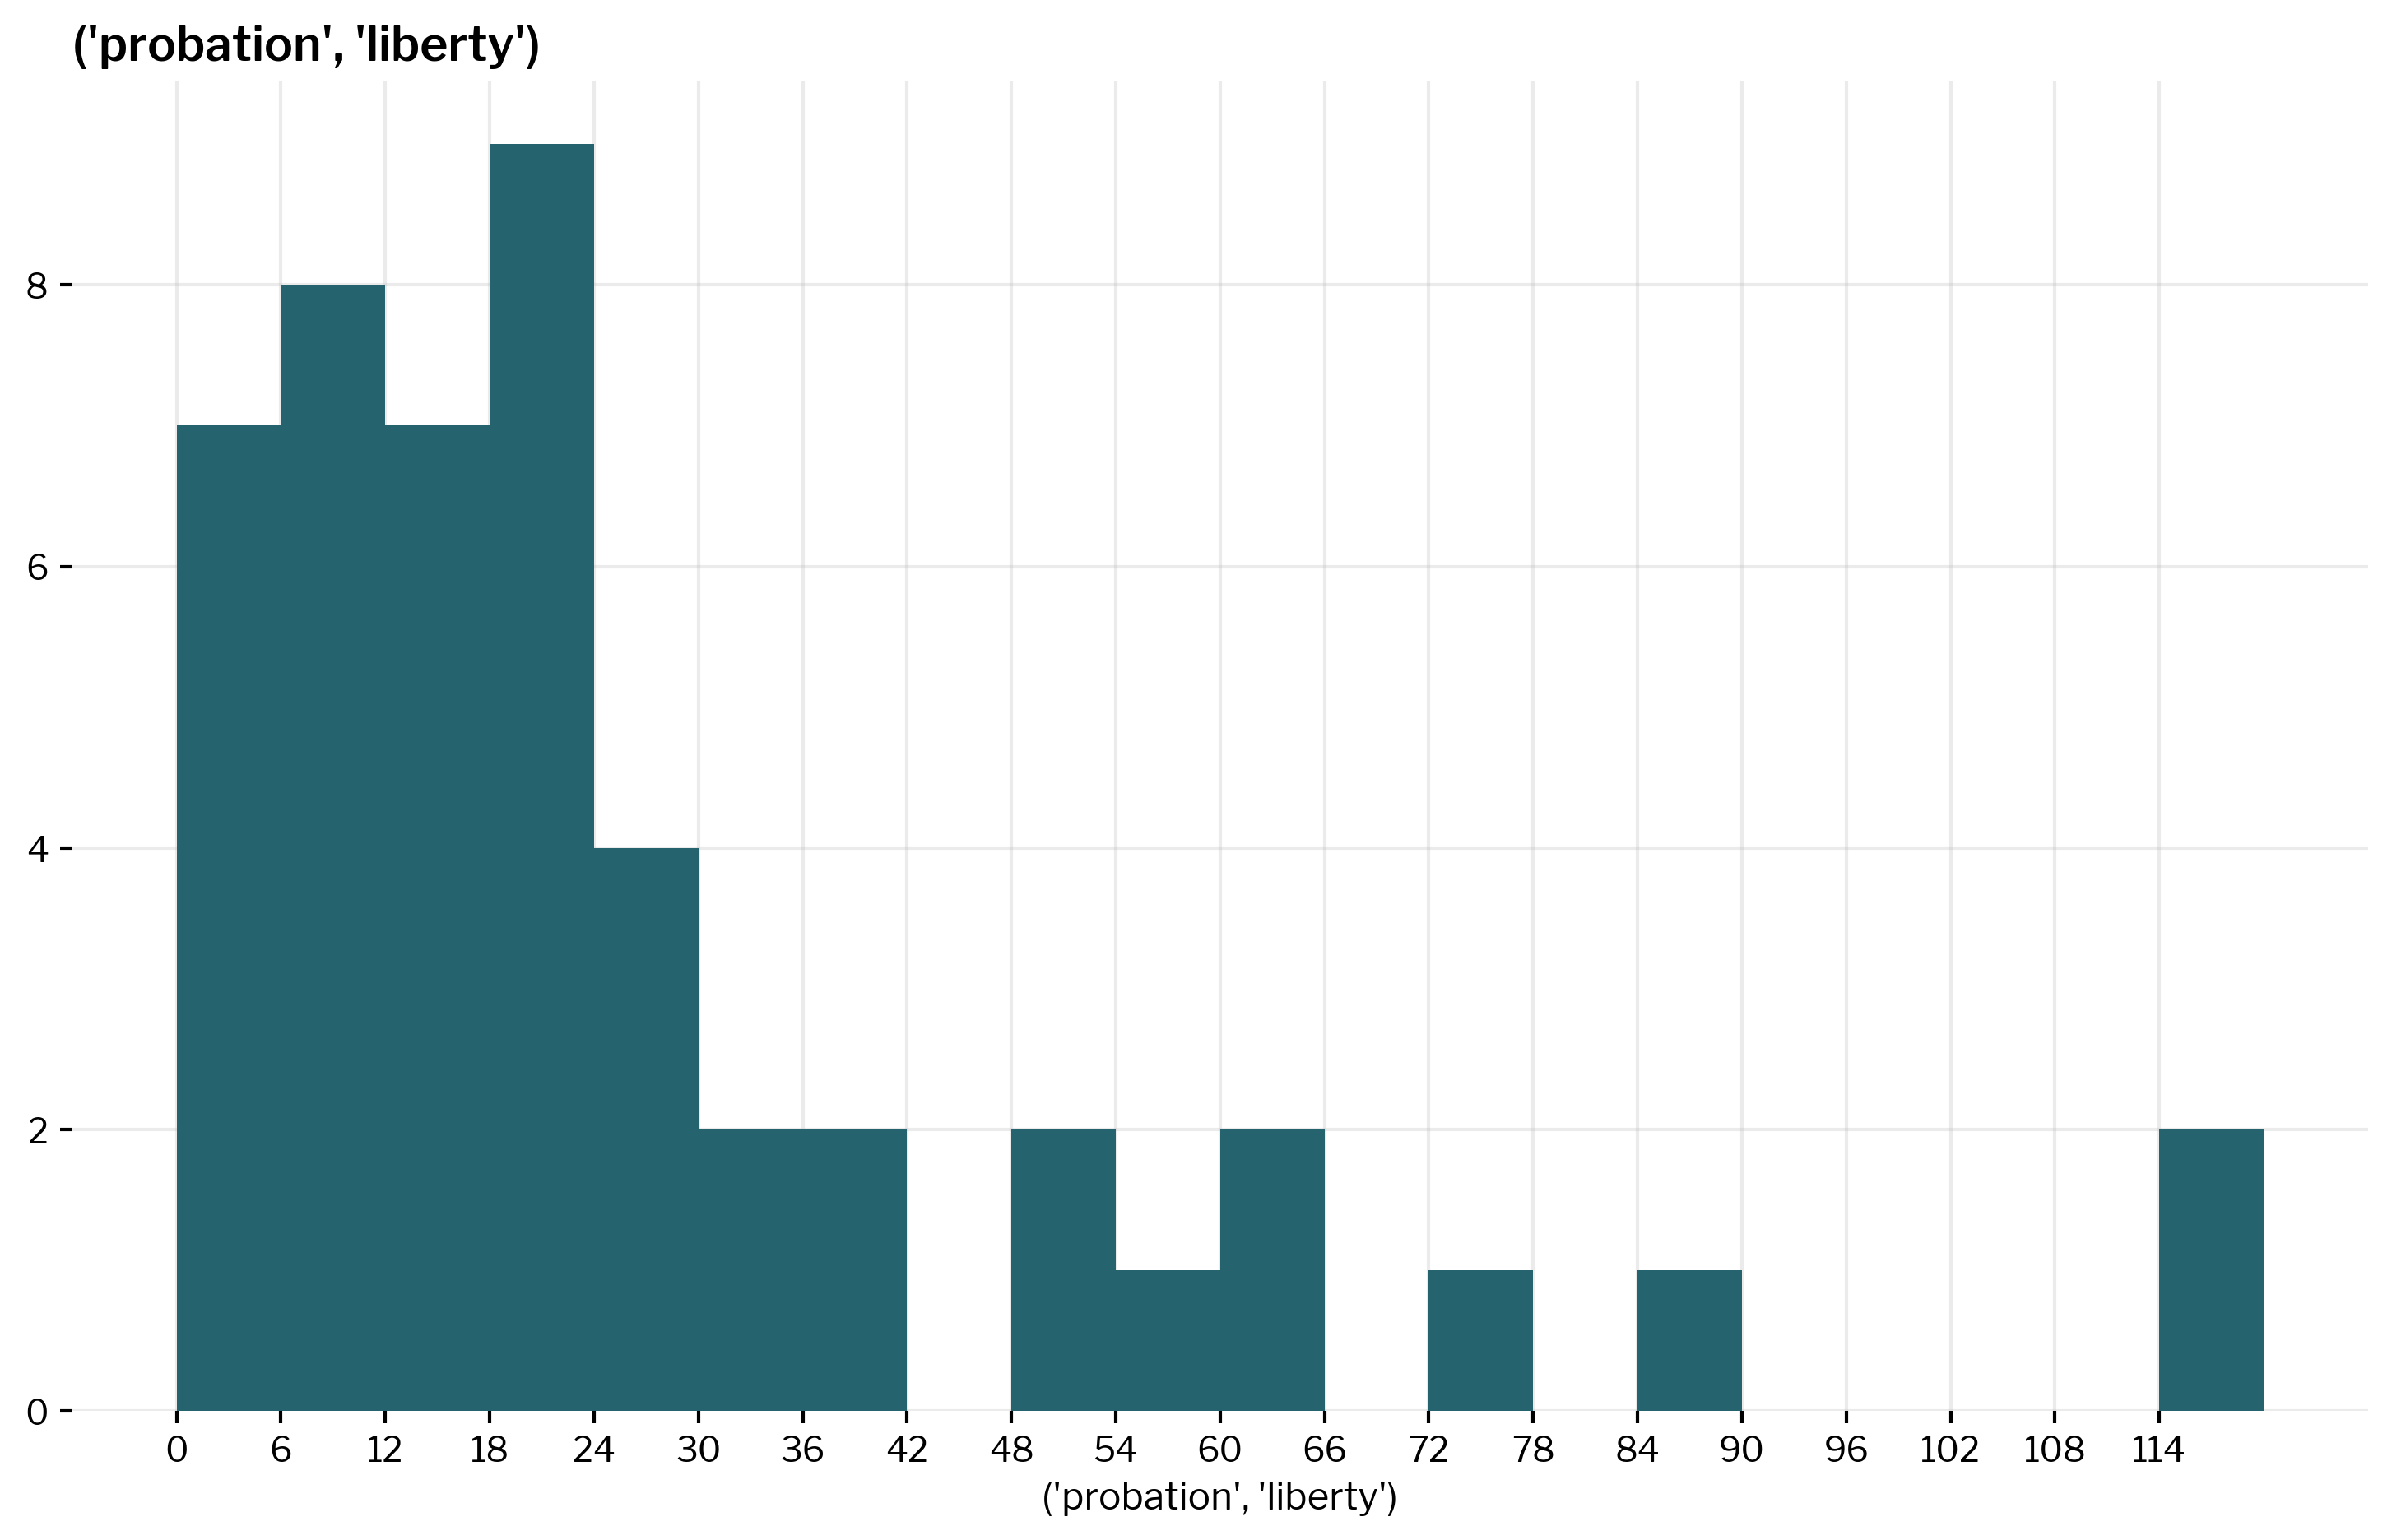

In [72]:
for group, grouped in transitions.groupby(["compartment", "outflow_to"]):
    grouped[["compartment_duration"]].hist(bins=20)
    plt.xlabel(f"{group}")
    plt.xticks(np.arange(0, 120, 6))
    plt.title(f"{group}");

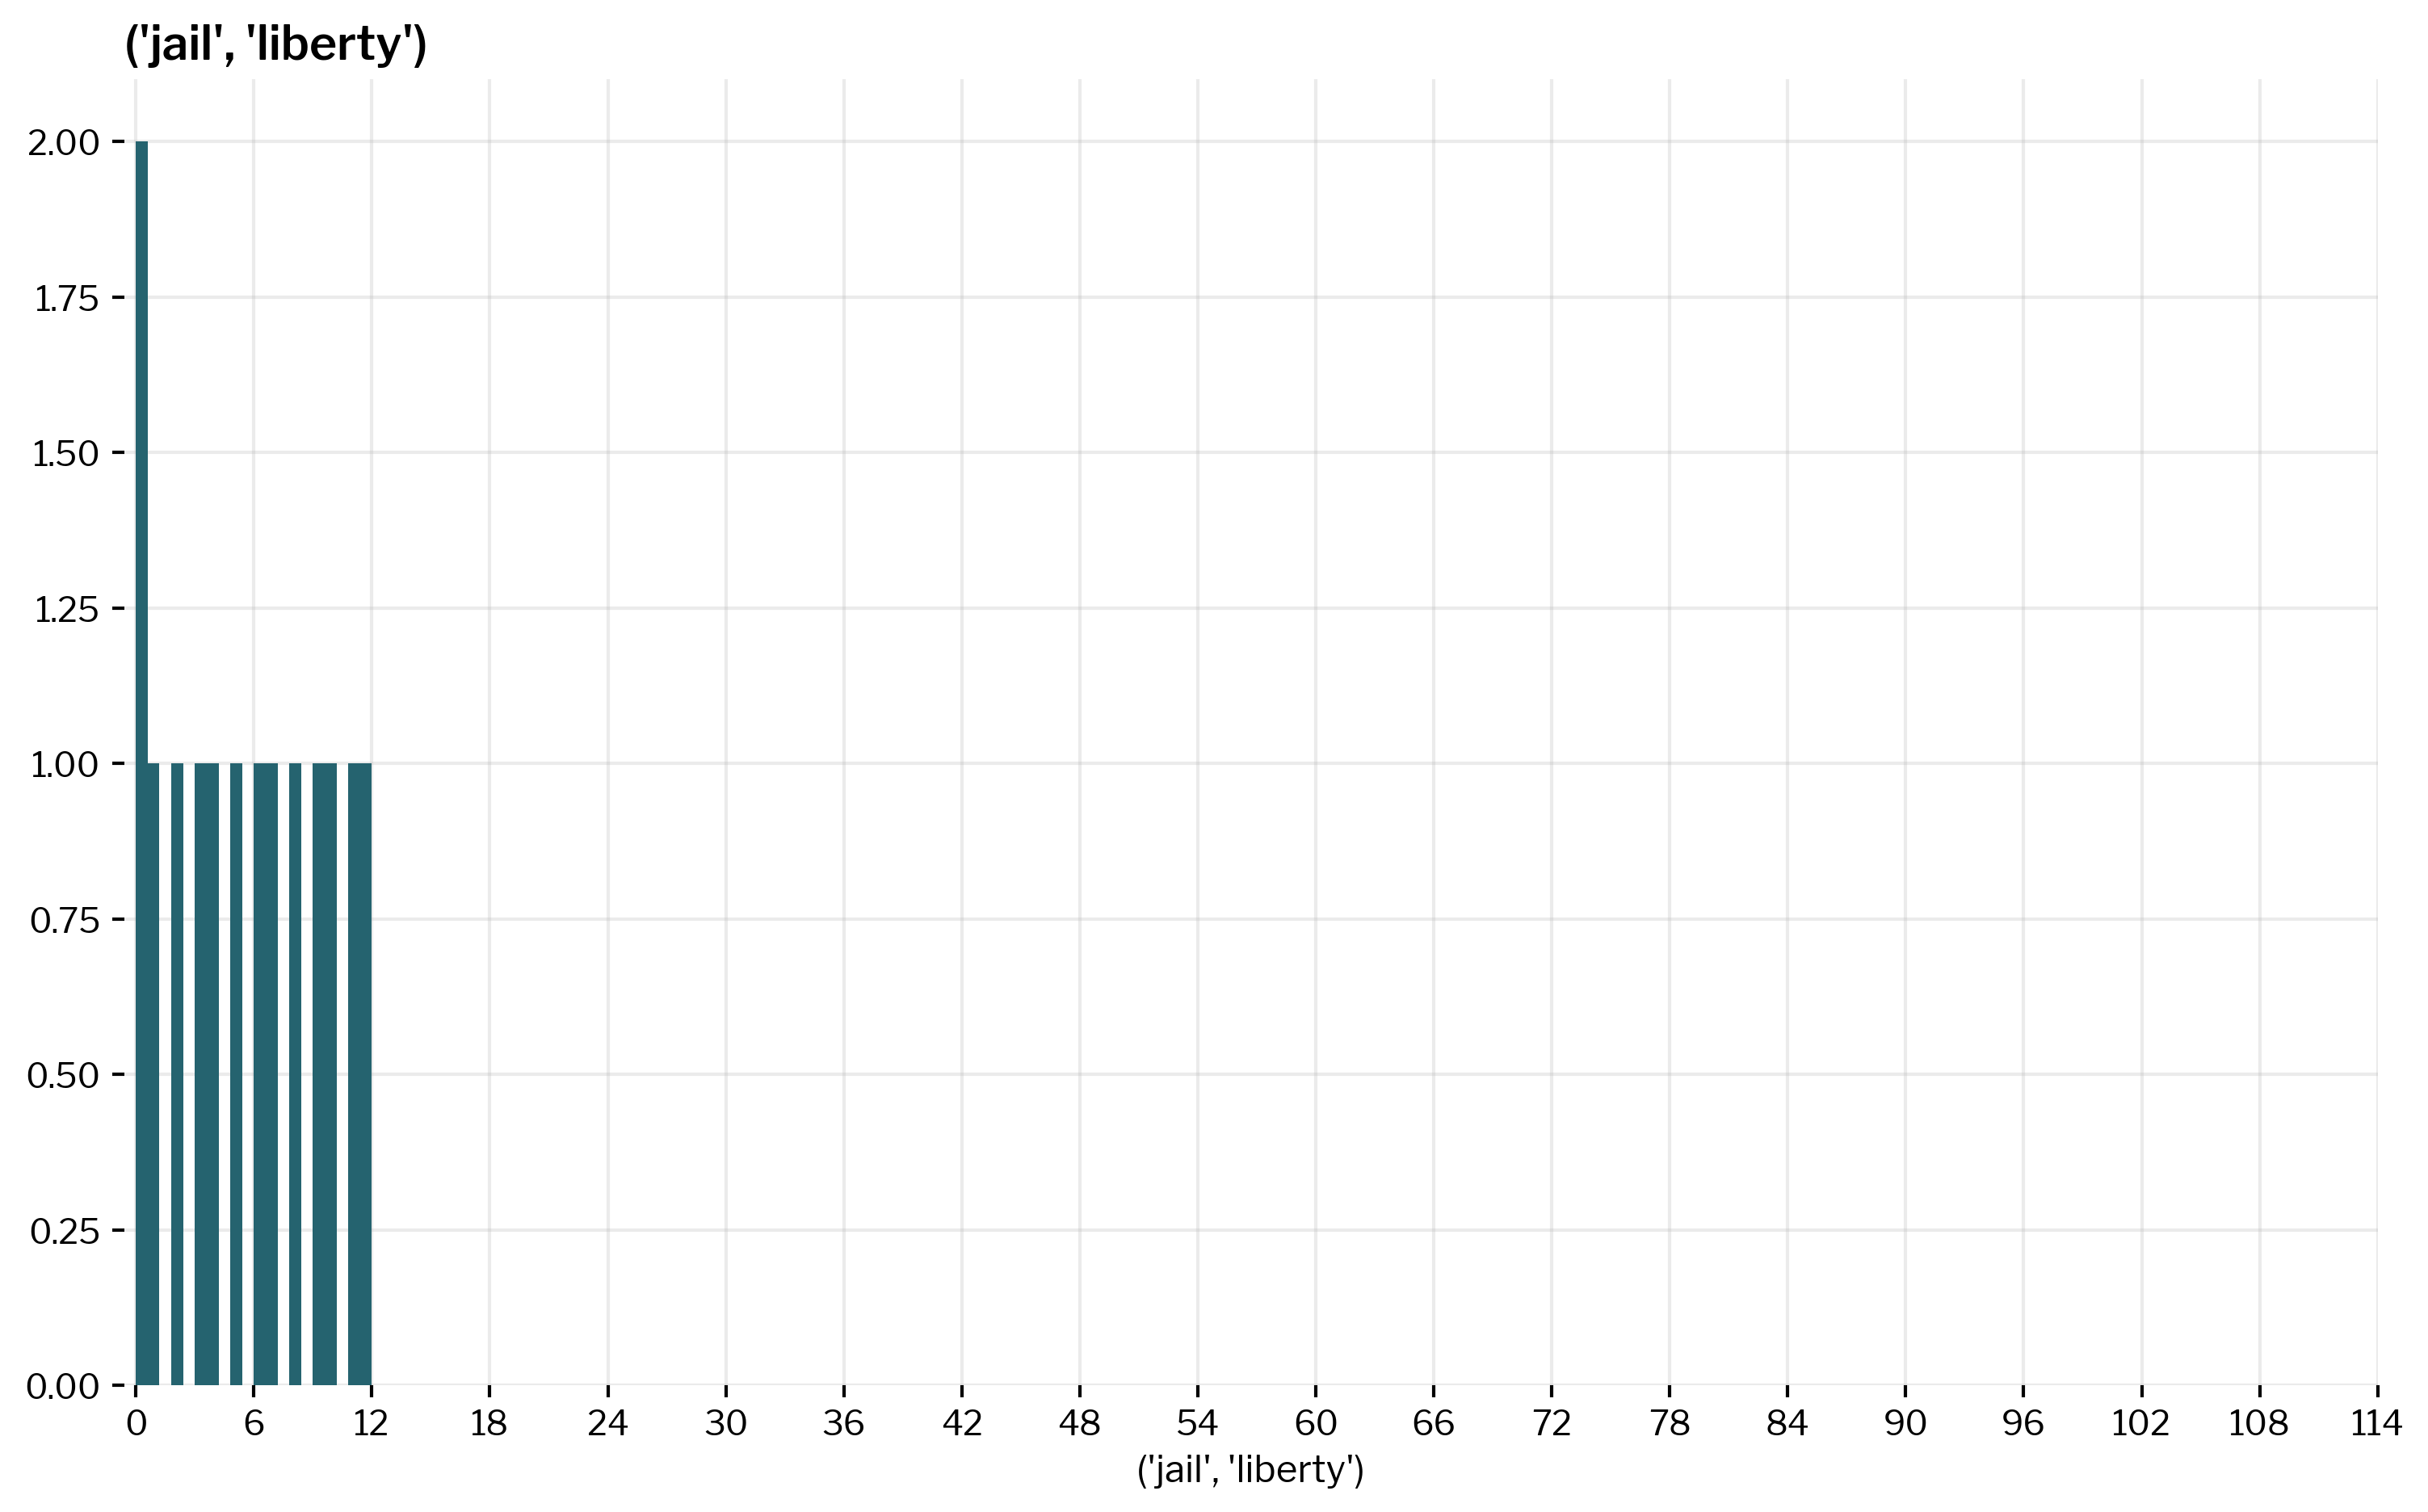

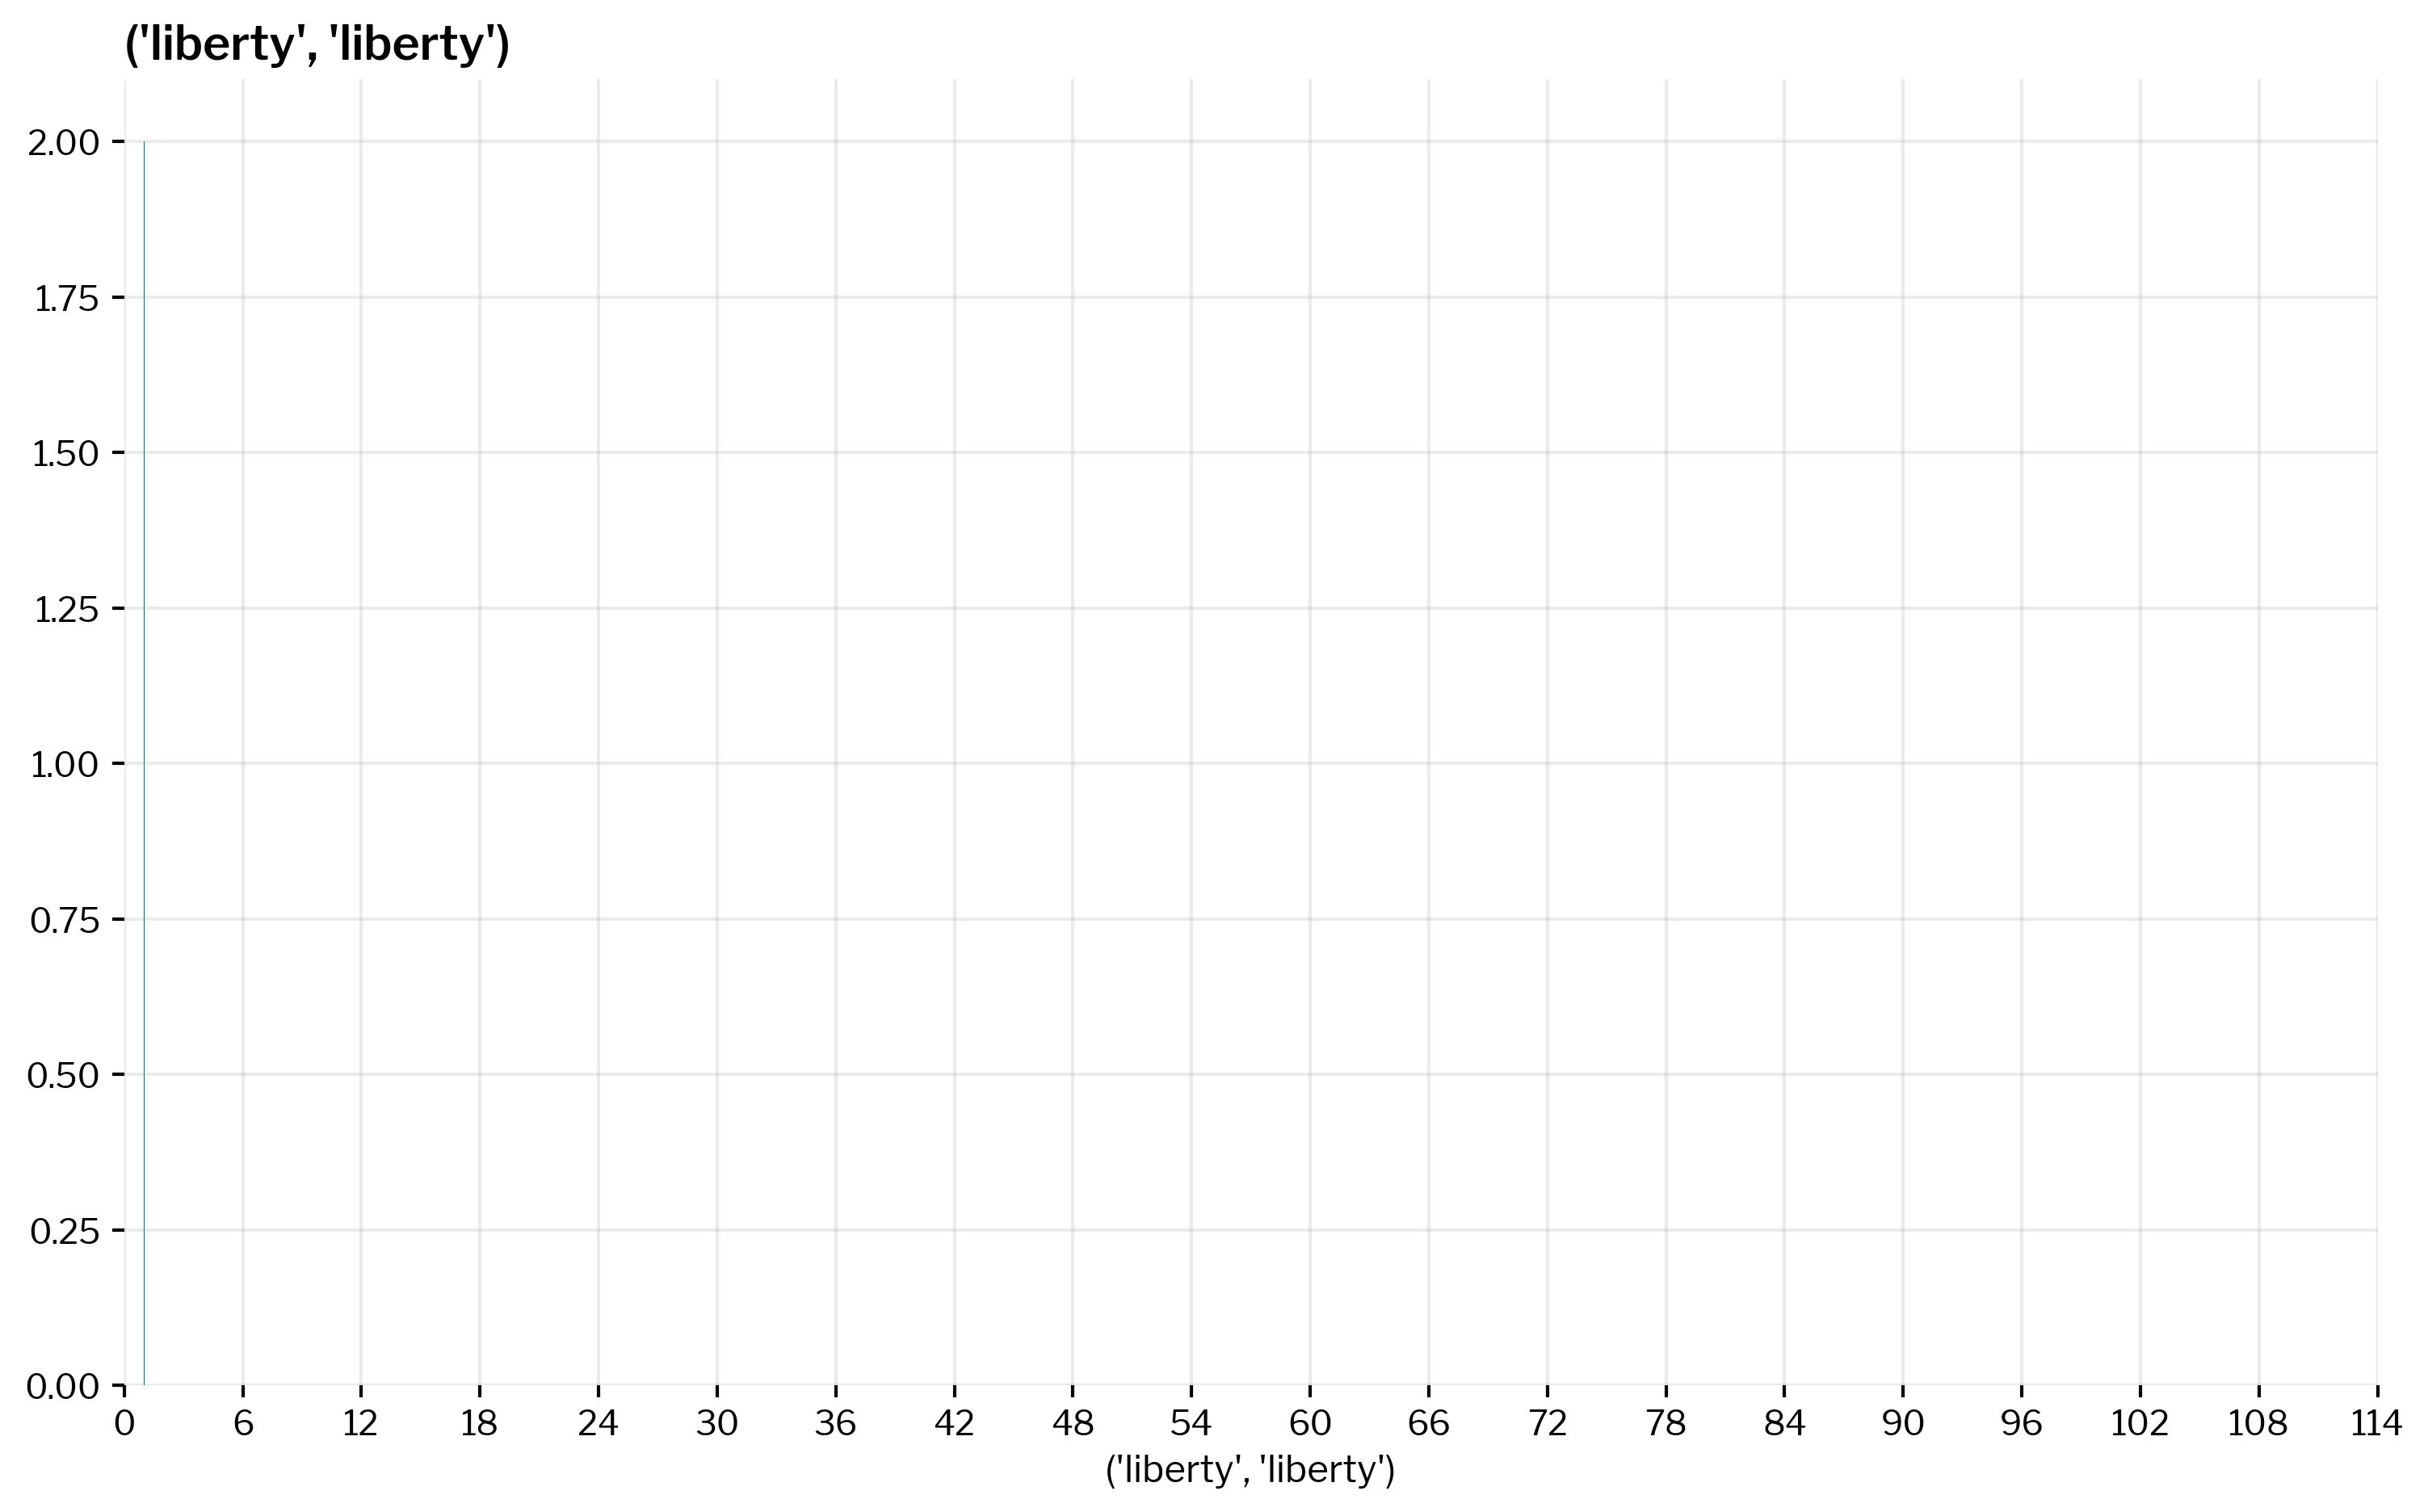

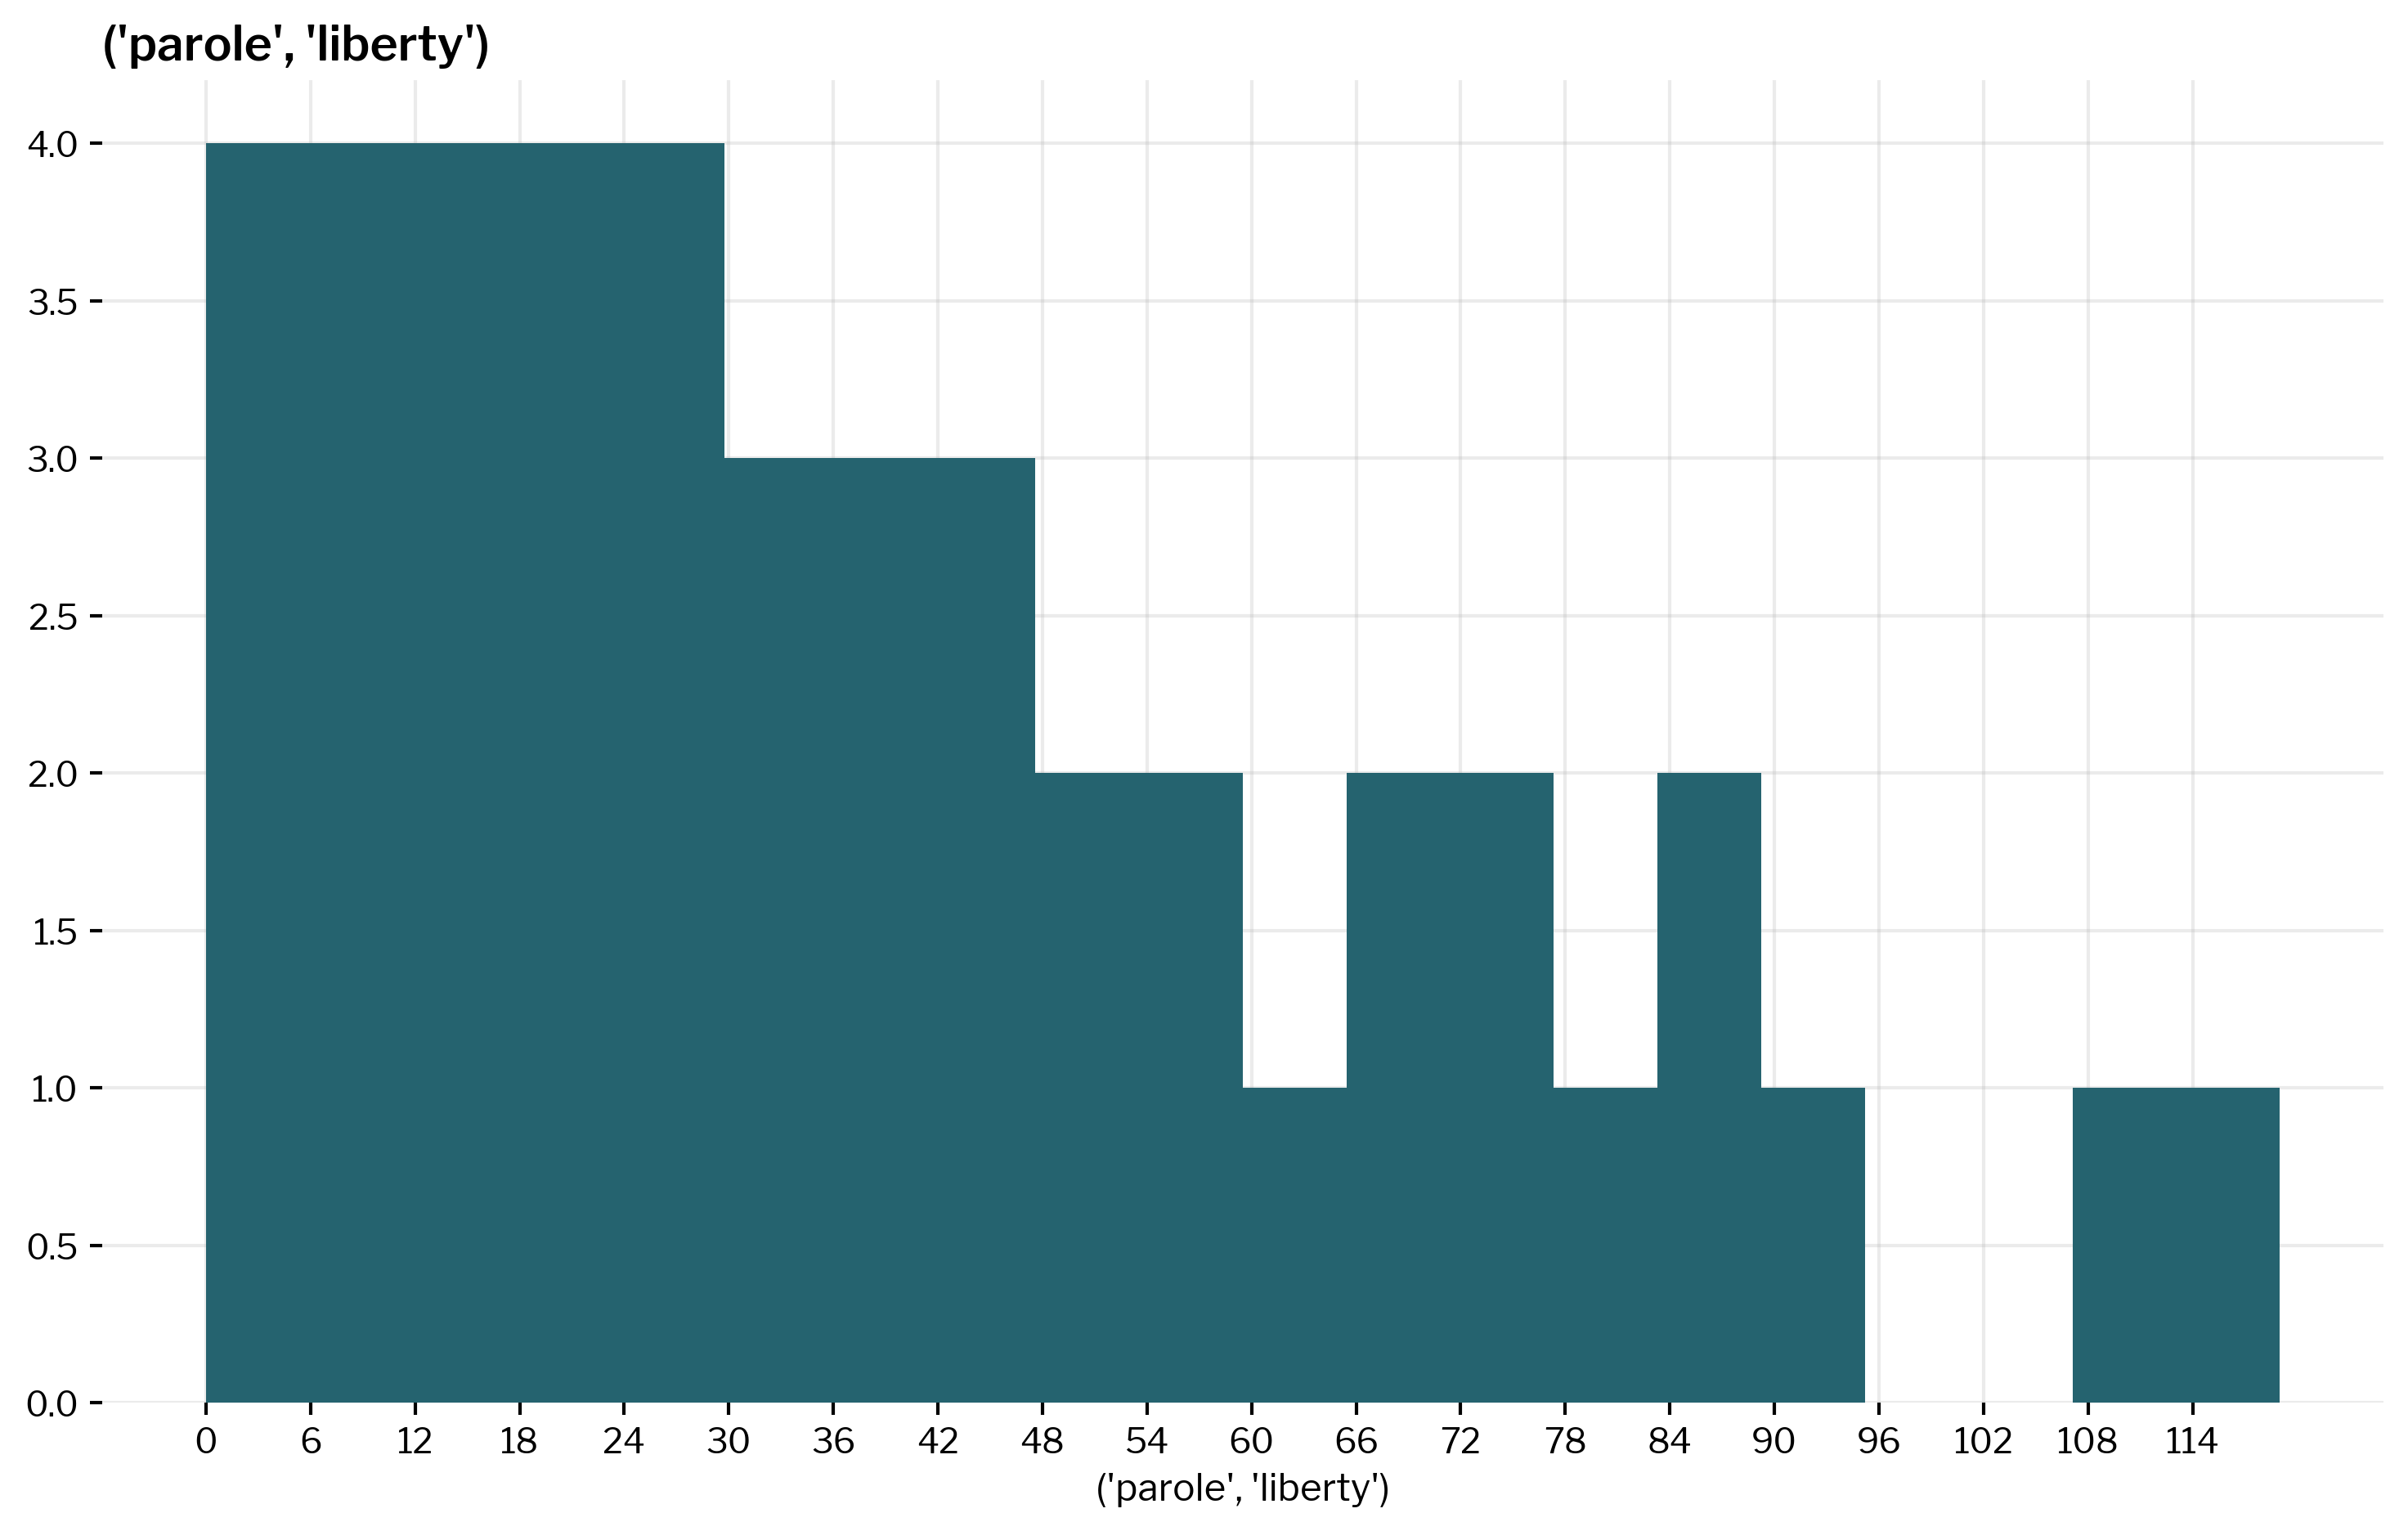

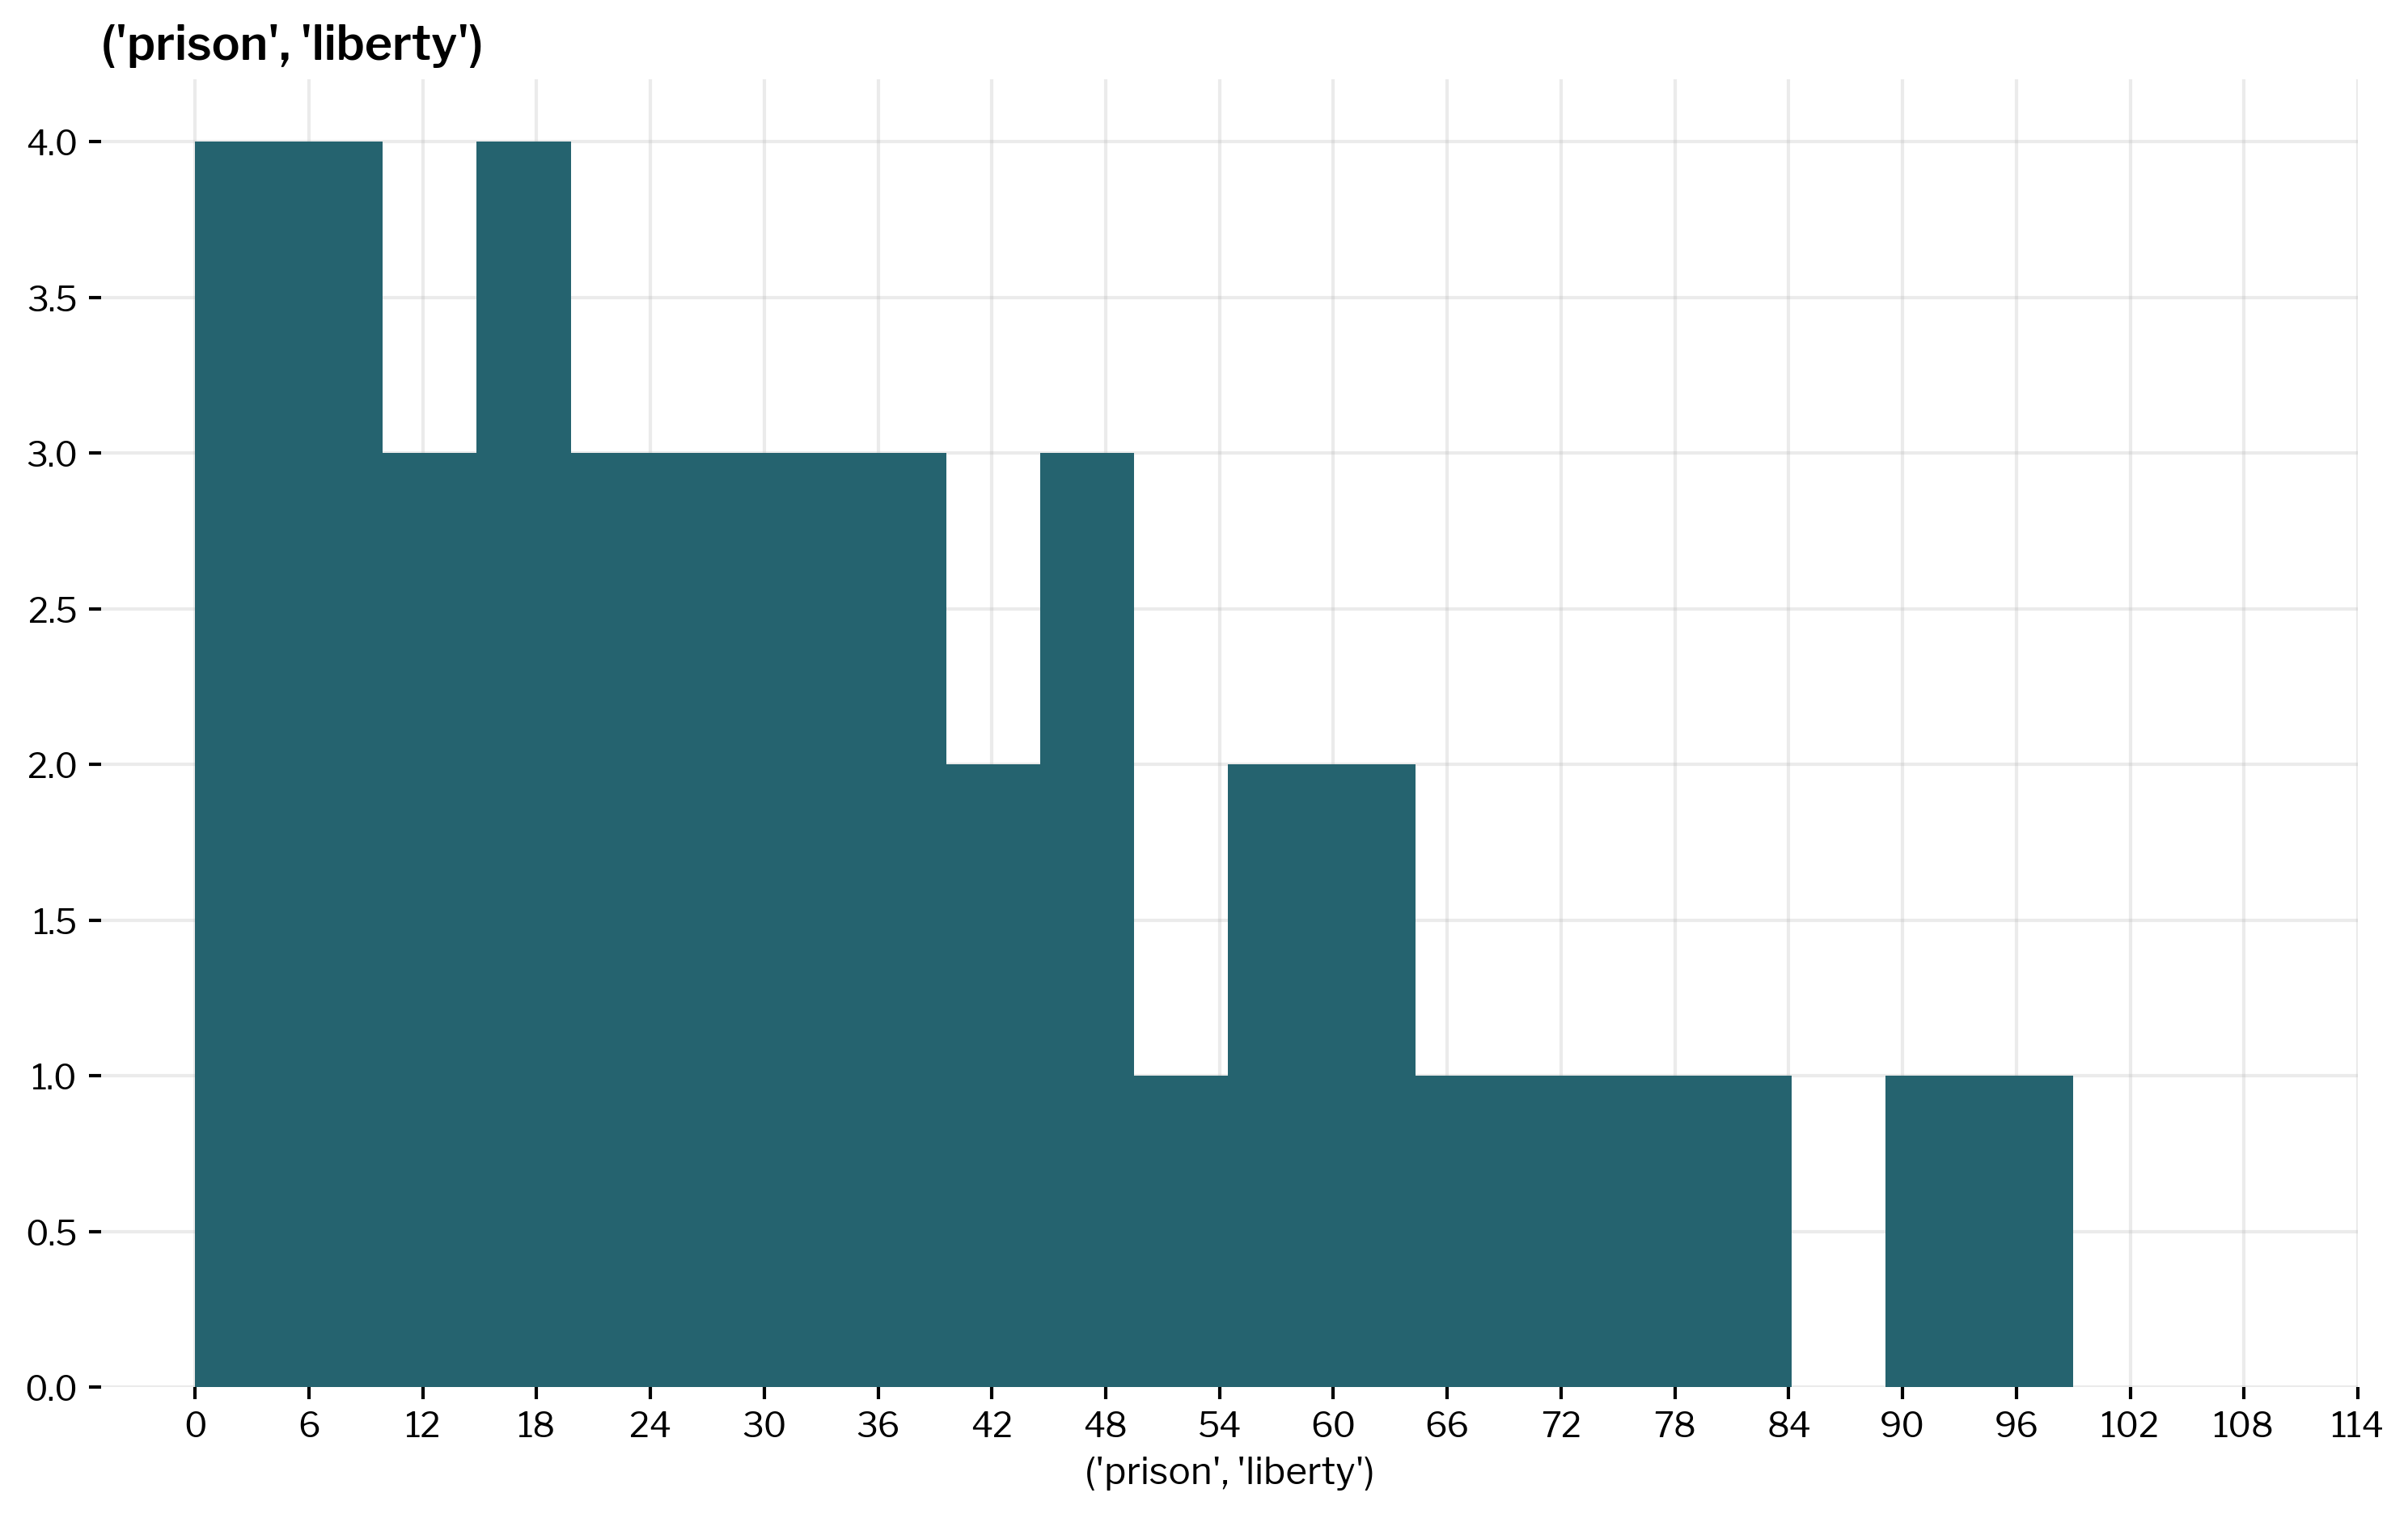

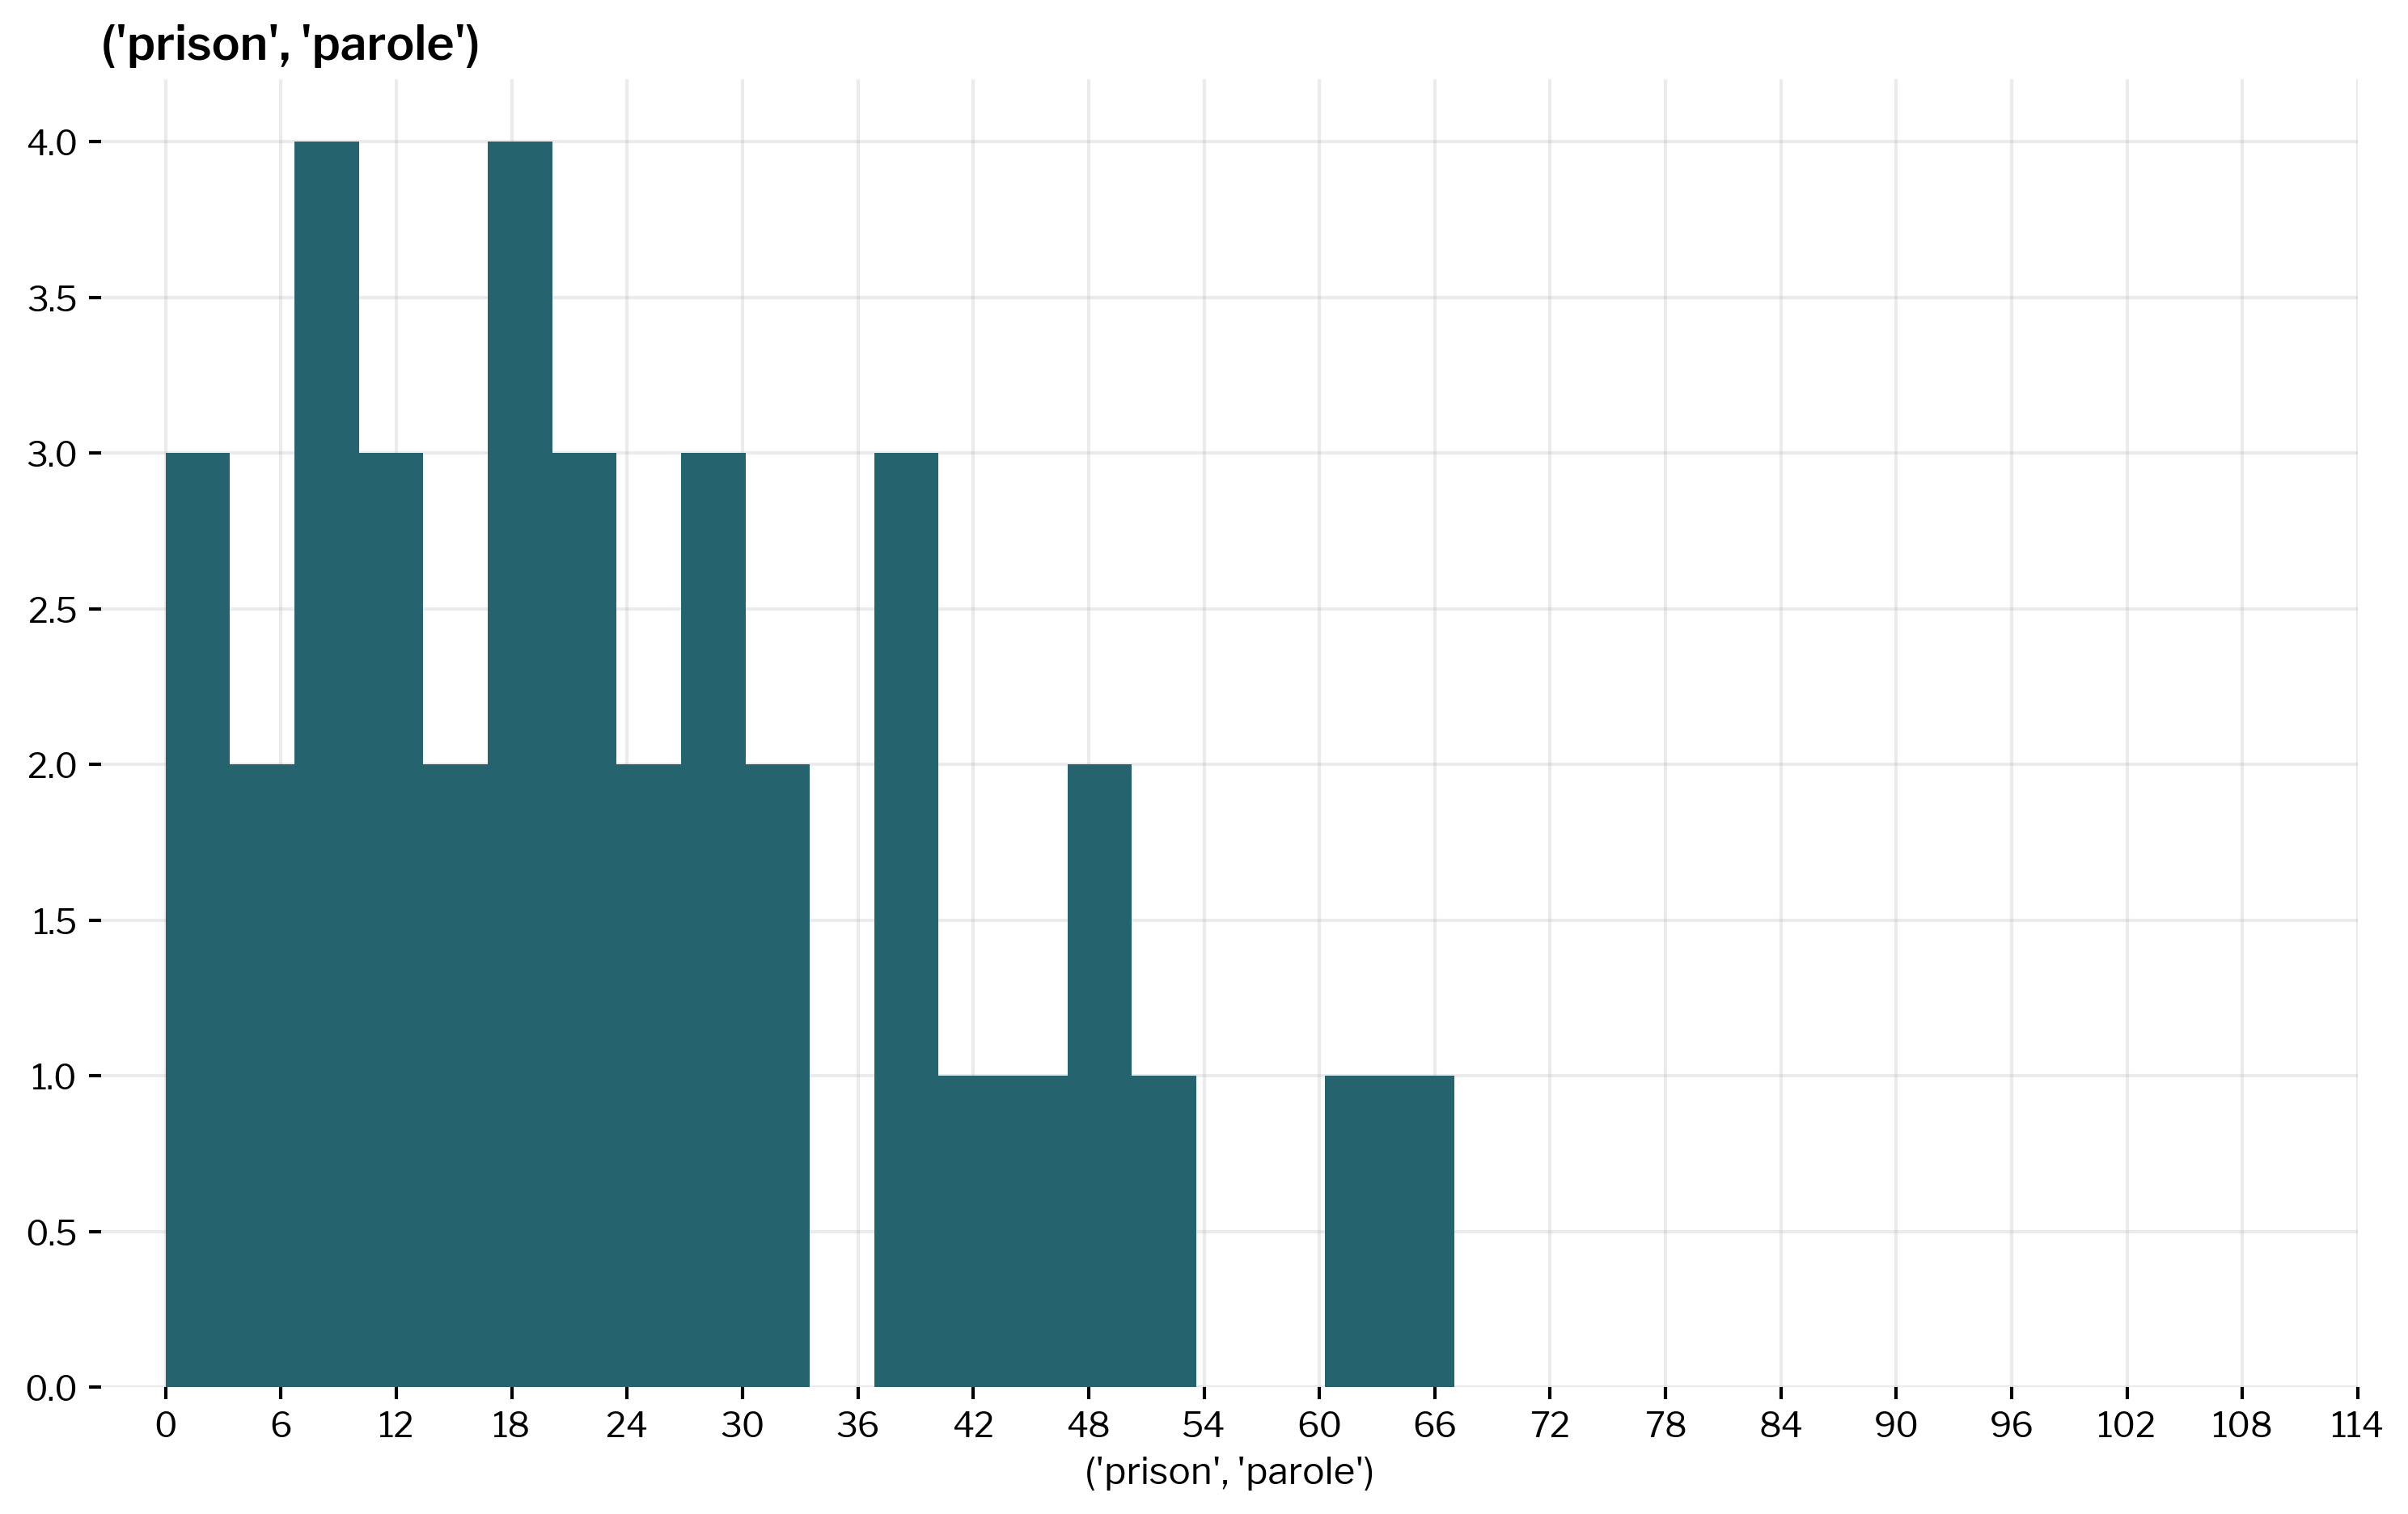

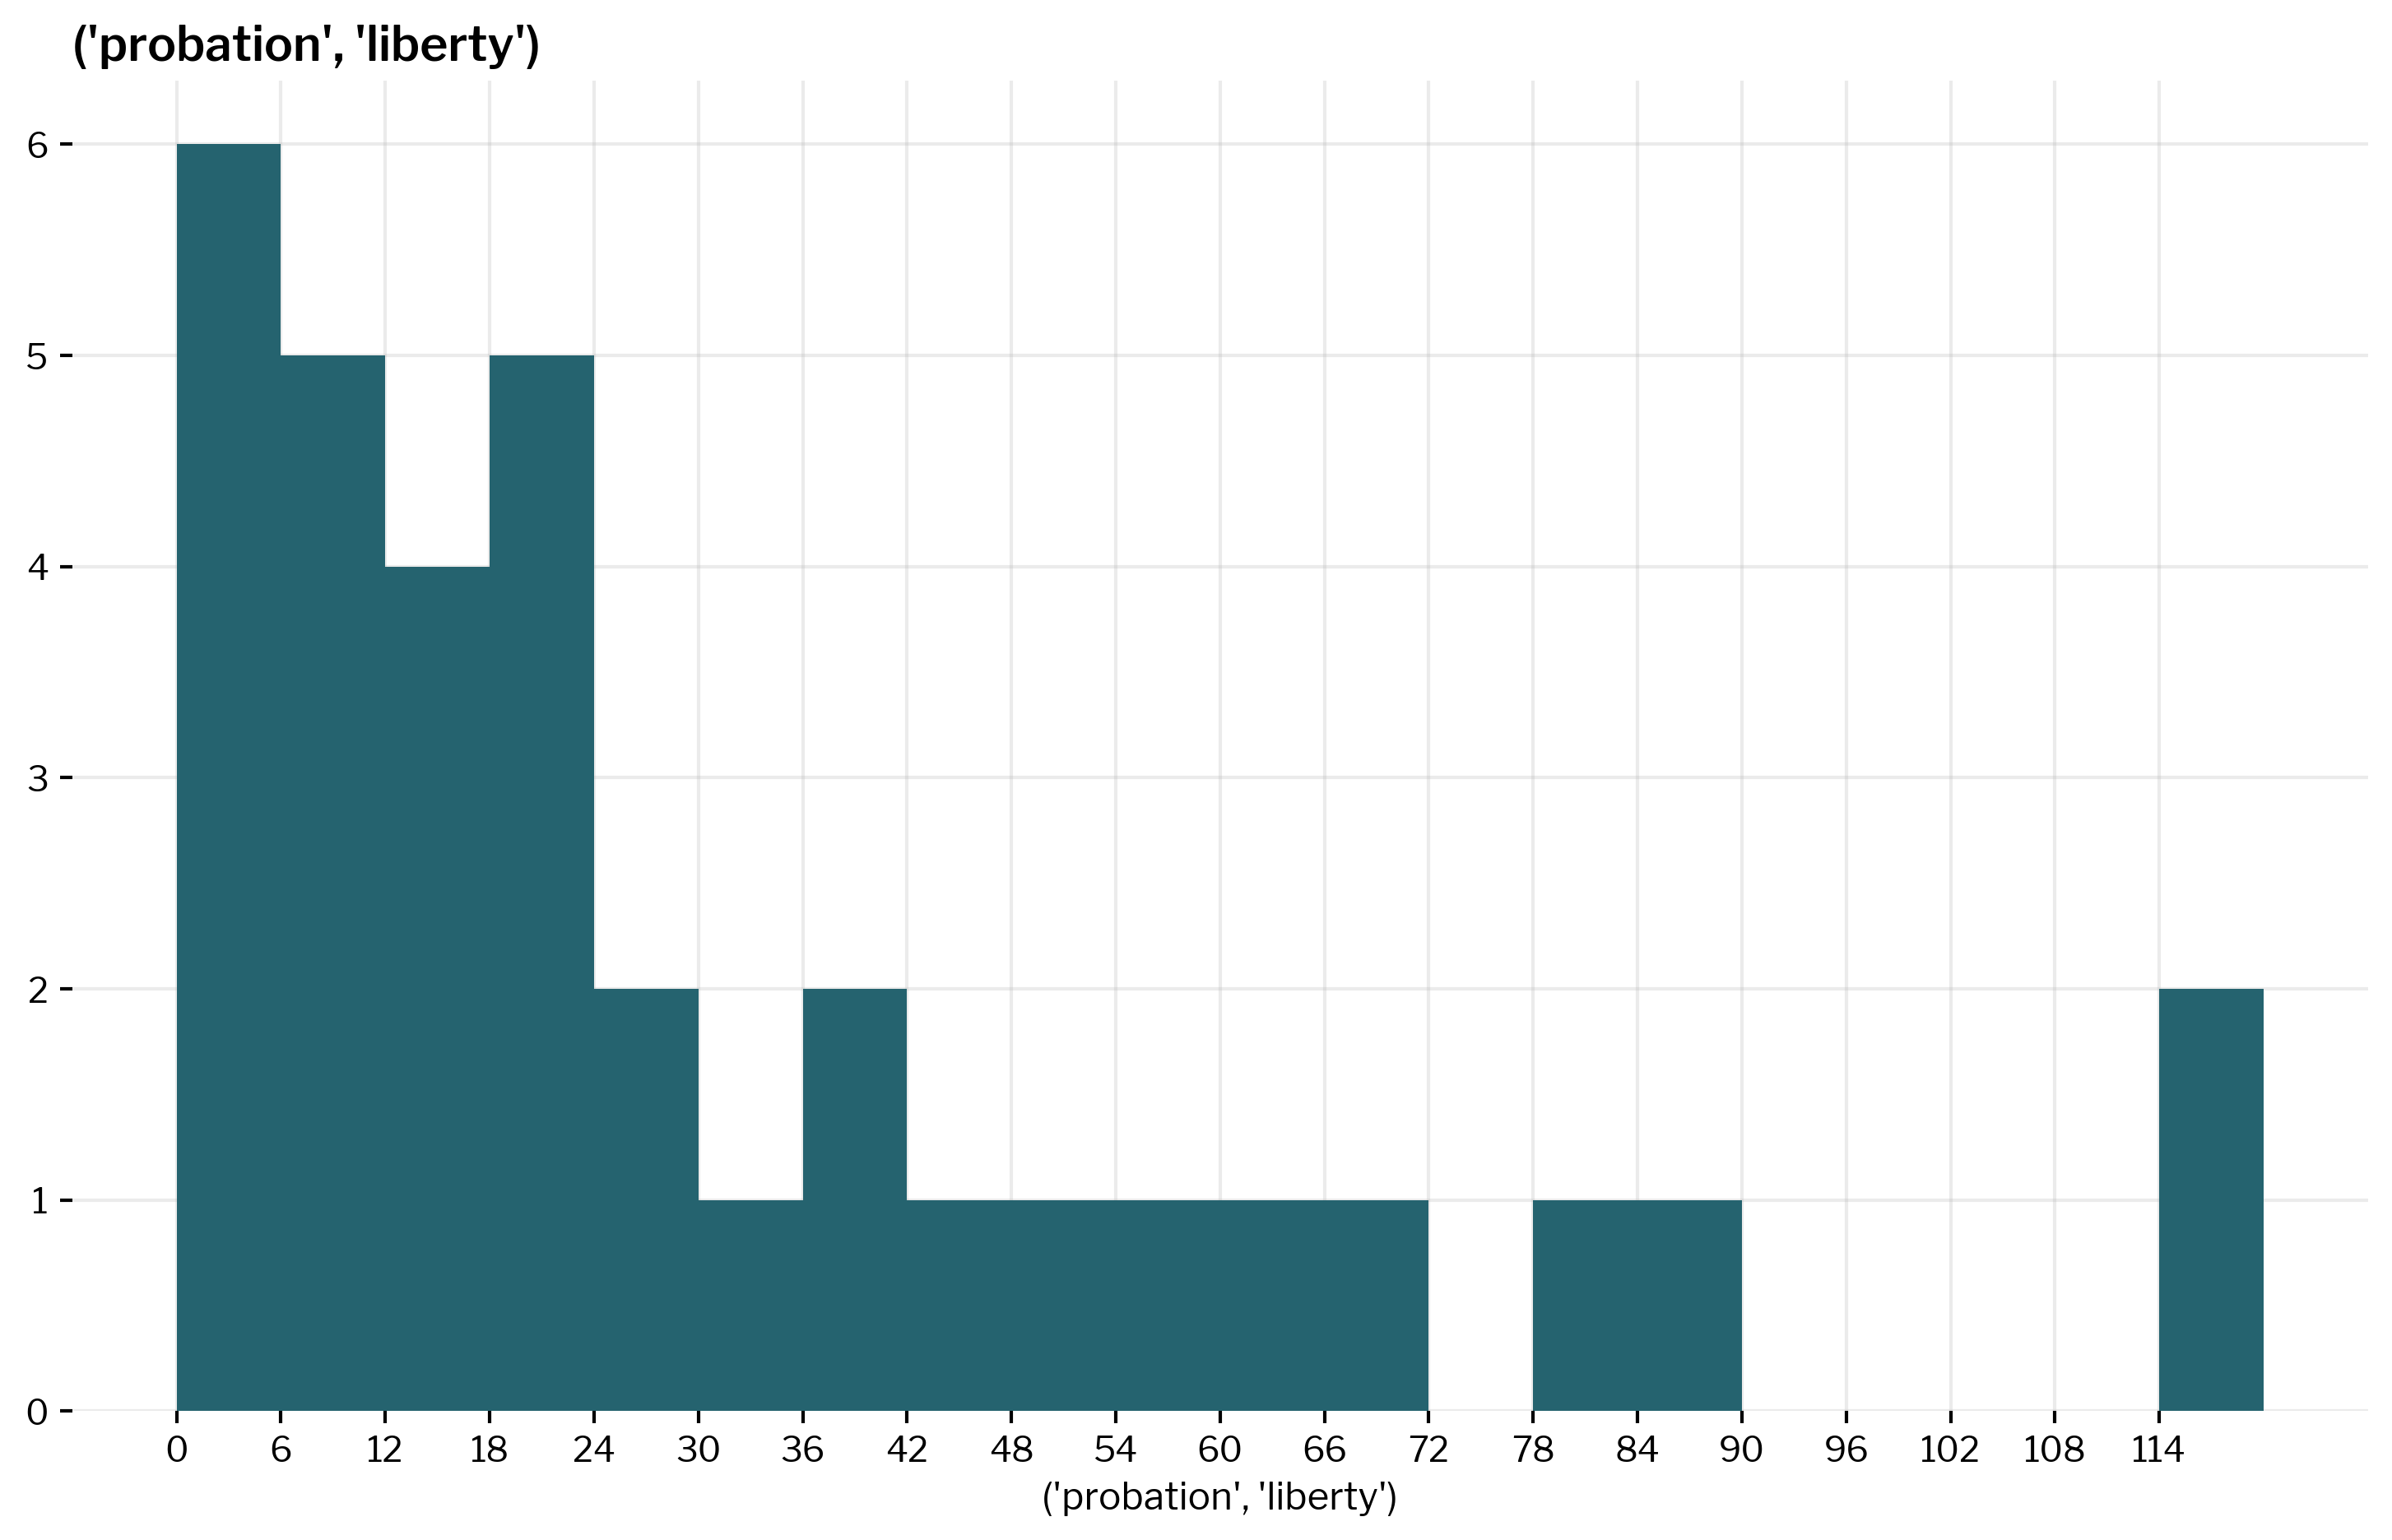

In [83]:
for group, grouped in transitions_policy.groupby(["compartment", "outflow_to"]):
    grouped[["compartment_duration"]].hist(bins=20)
    plt.xlabel(f"{group}")
    plt.xticks(np.arange(0, 120, 6))
    plt.title(f"{group}");

## Total population

In [73]:
total_population_start_ts = -128
total_population = pd.DataFrame()
for time_step in range(total_population_start_ts, 1):
    active_population = eligible_sessions_with_mj[
        (eligible_sessions_with_mj["time_step"] <= time_step)
        & (time_step < eligible_sessions_with_mj["time_step_end"])
    ]
    active_population = (
        active_population.groupby(disaggregation_axes + ["compartment"])
        .percent_outflow.sum()
        .reset_index()
    )

    active_population["time_step"] = time_step
    total_population = pd.concat([total_population, active_population])

total_population.rename(
    columns={"percent_outflow": "total_population"},
    inplace=True,
)
total_population = total_population[total_population.time_step >= -60]

<AxesSubplot: xlabel='time_step'>

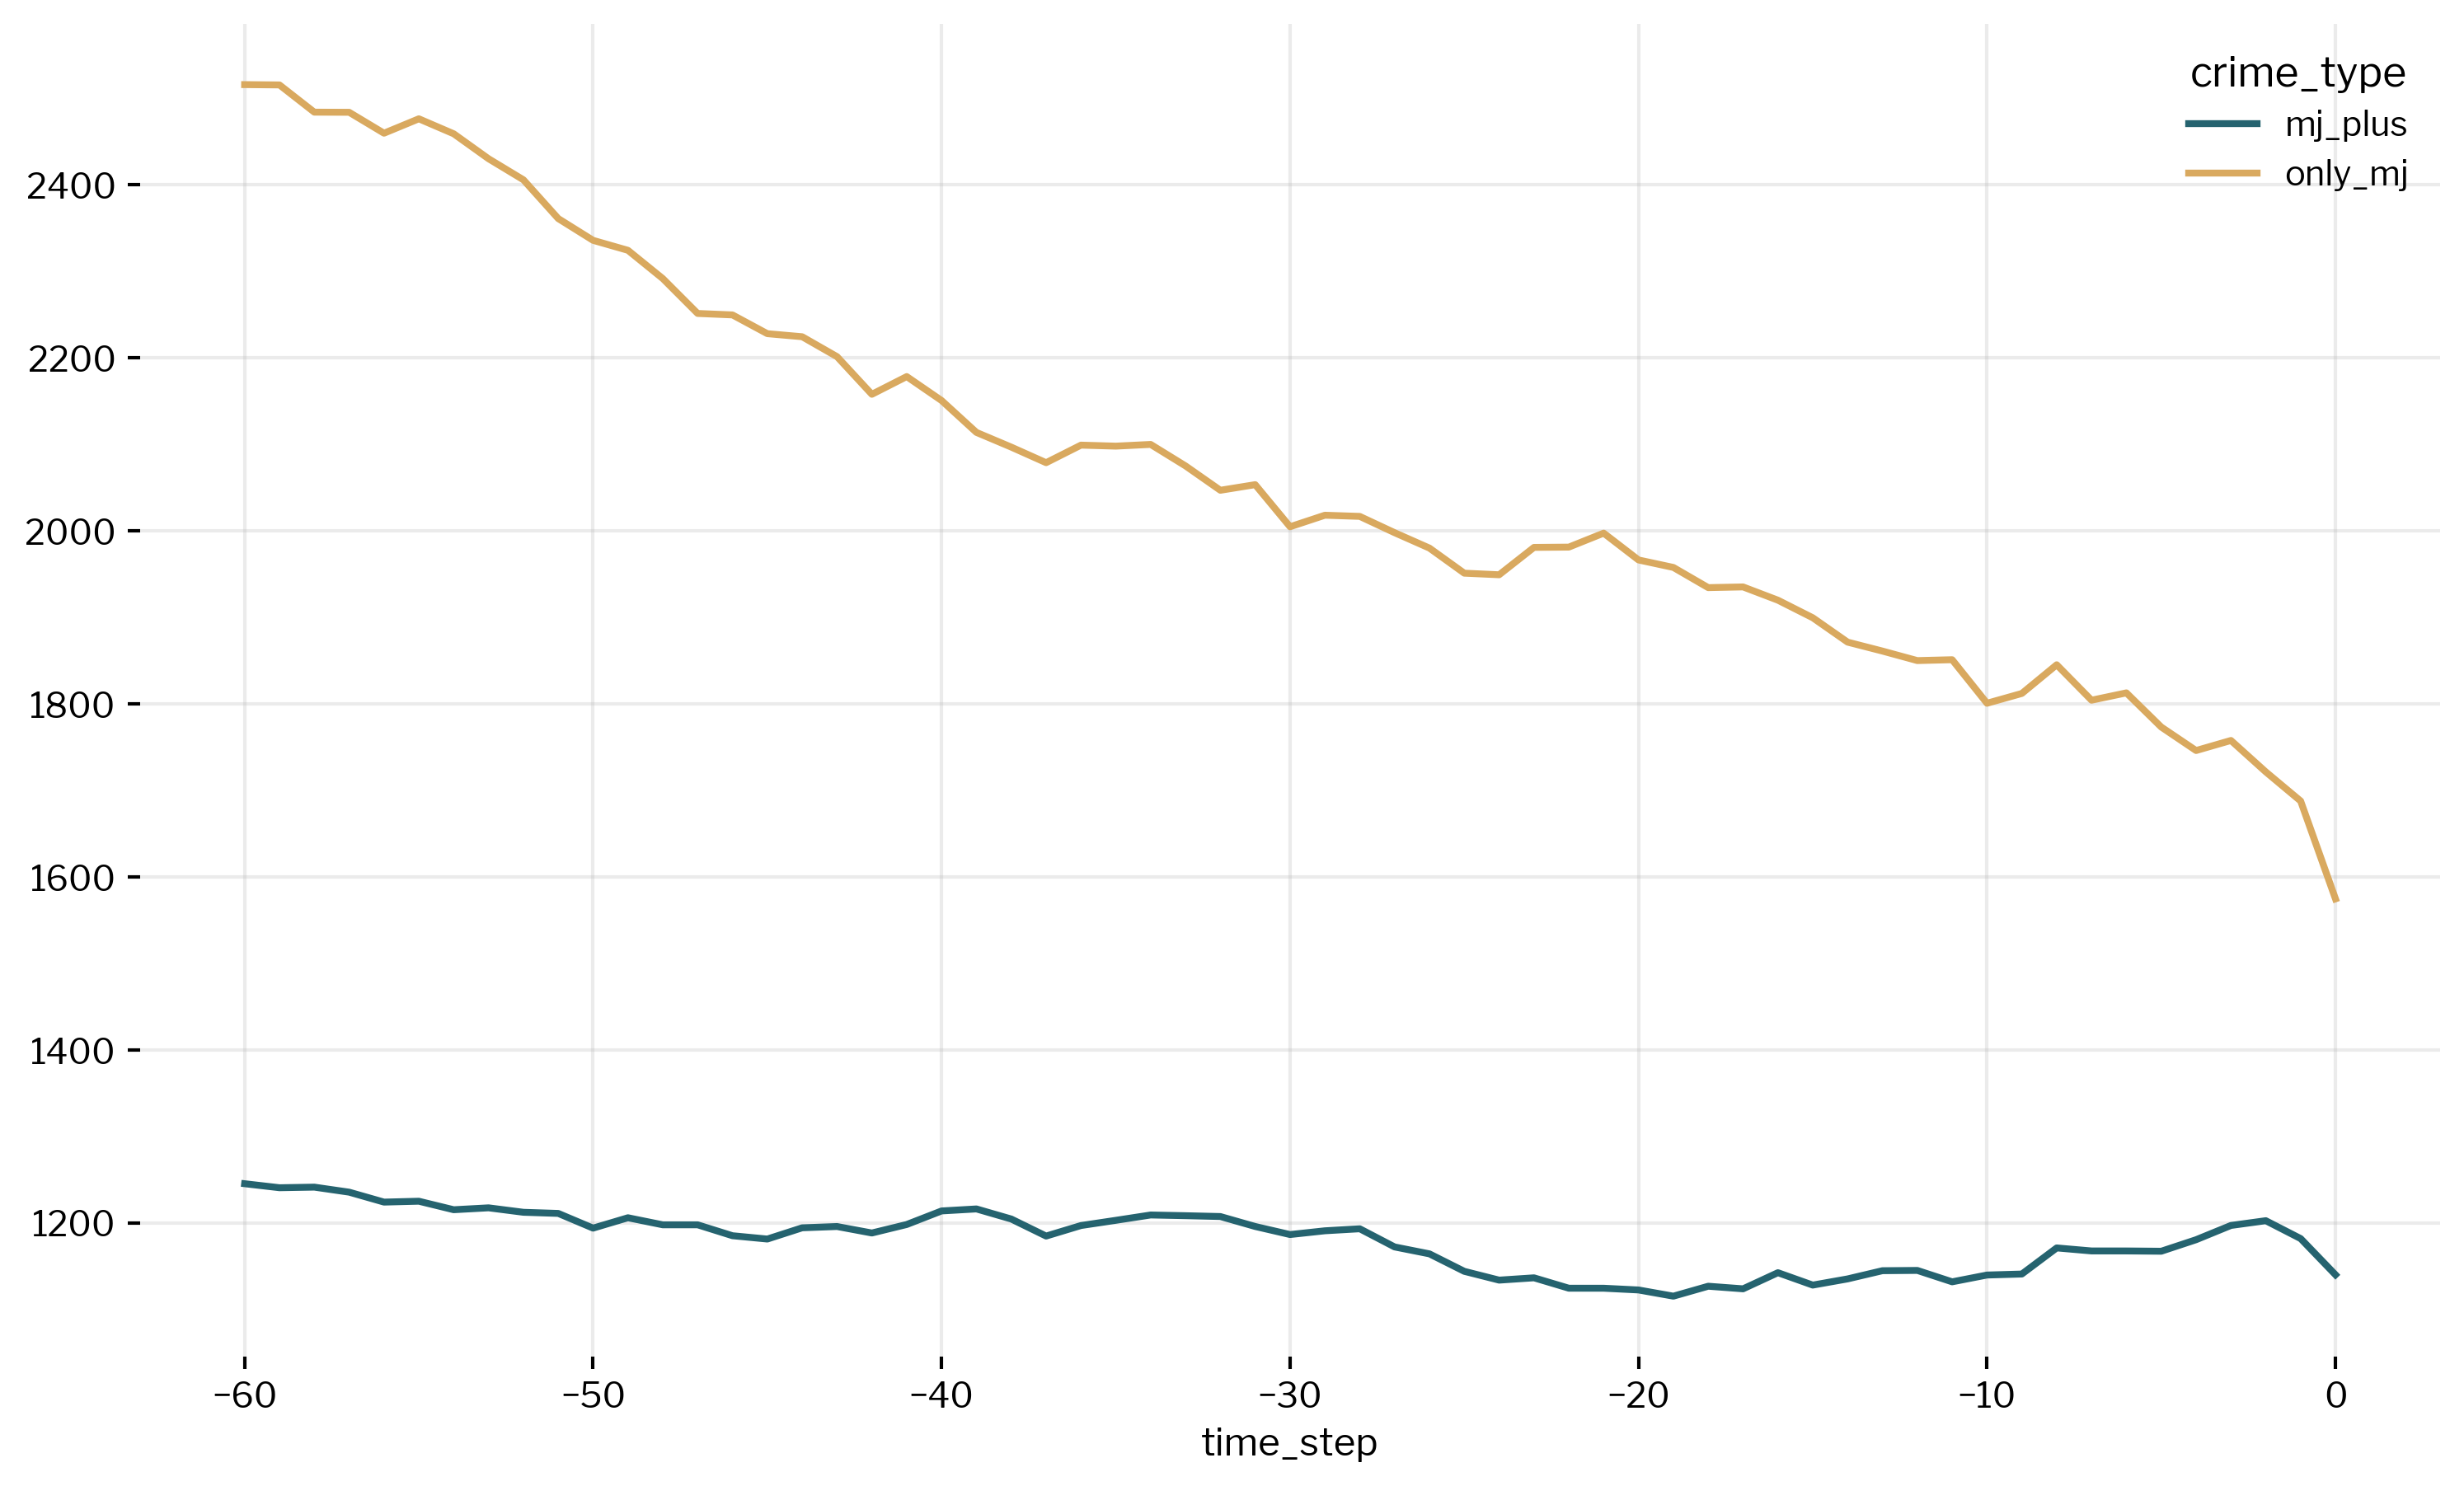

In [74]:
total_population.groupby(["time_step", "crime_type"])[
    ["total_population"]
].sum().reset_index().pivot(
    index="time_step",
    columns=["crime_type"],
    values="total_population",
).plot()

In [75]:
total_population.groupby(["time_step", "crime_type"])[["total_population"]].sum().iloc[
    -8:
]

total_population
time_step crime_type                  
-3        mj_plus          1196.848491
          only_mj          1757.666798
-2        mj_plus          1202.357270
          only_mj          1721.339317
-1        mj_plus          1181.667193
          only_mj          1687.666798
 0        mj_plus          1139.830933
          only_mj          1574.503058

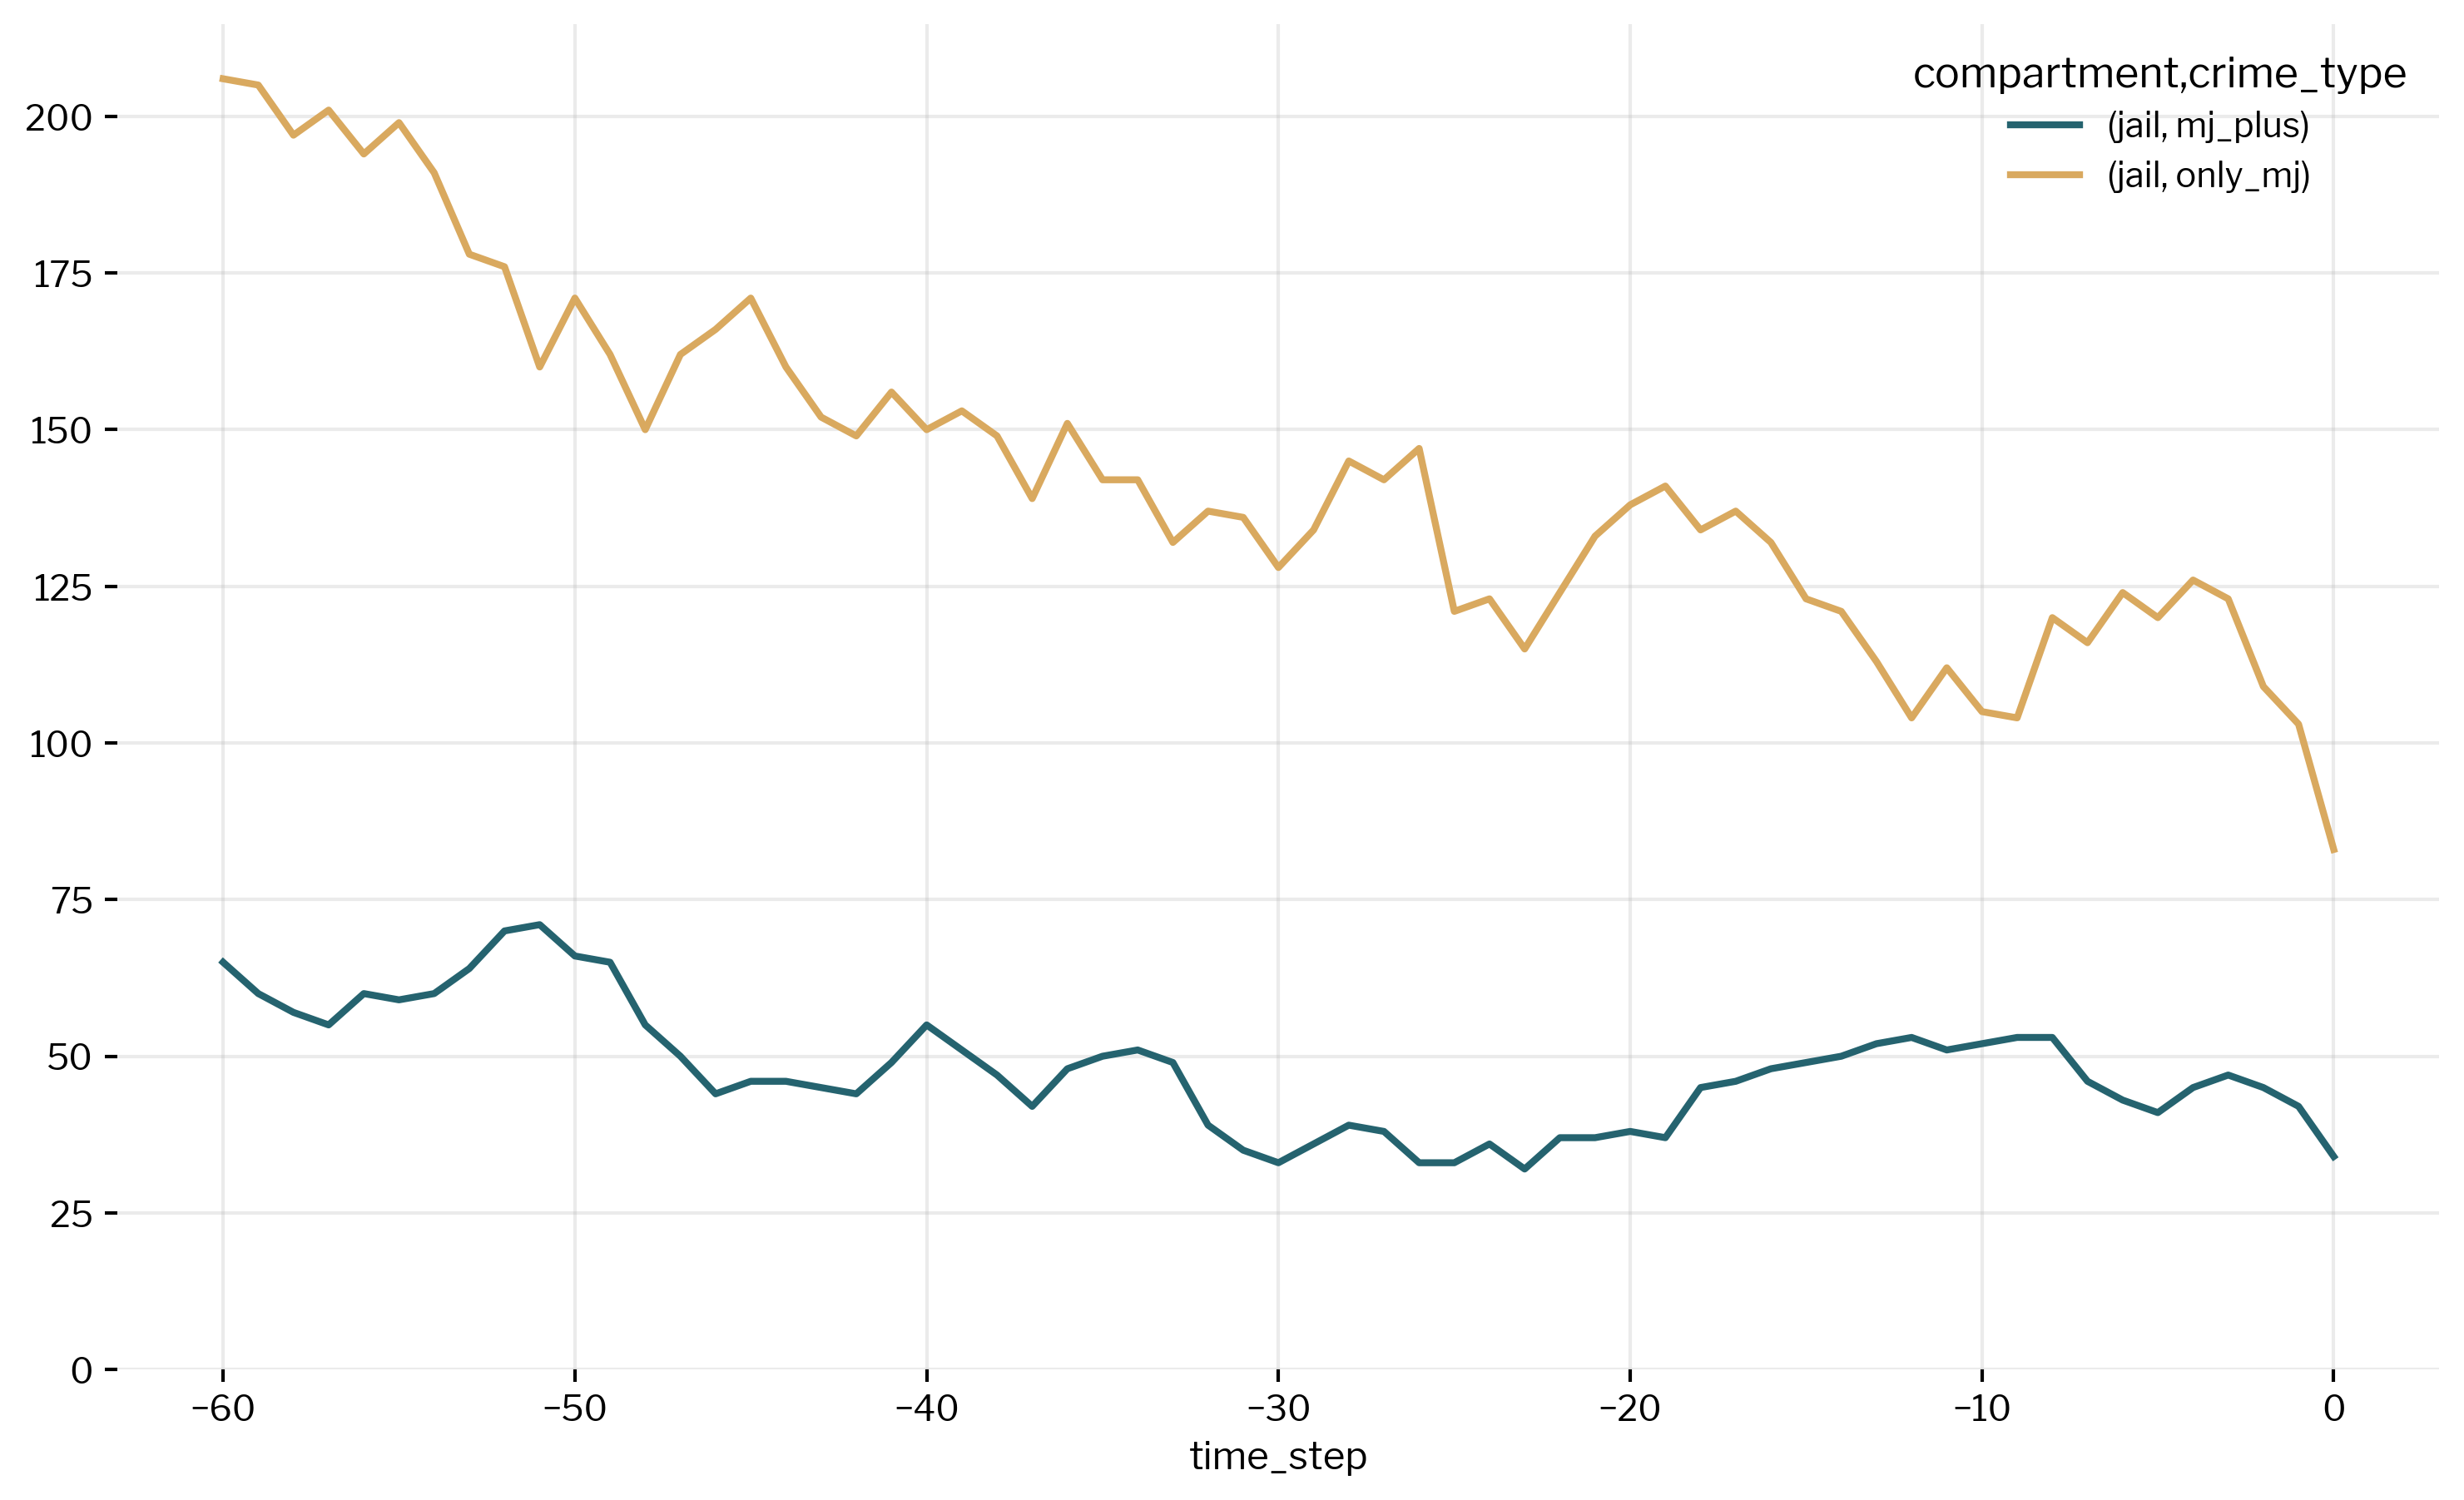

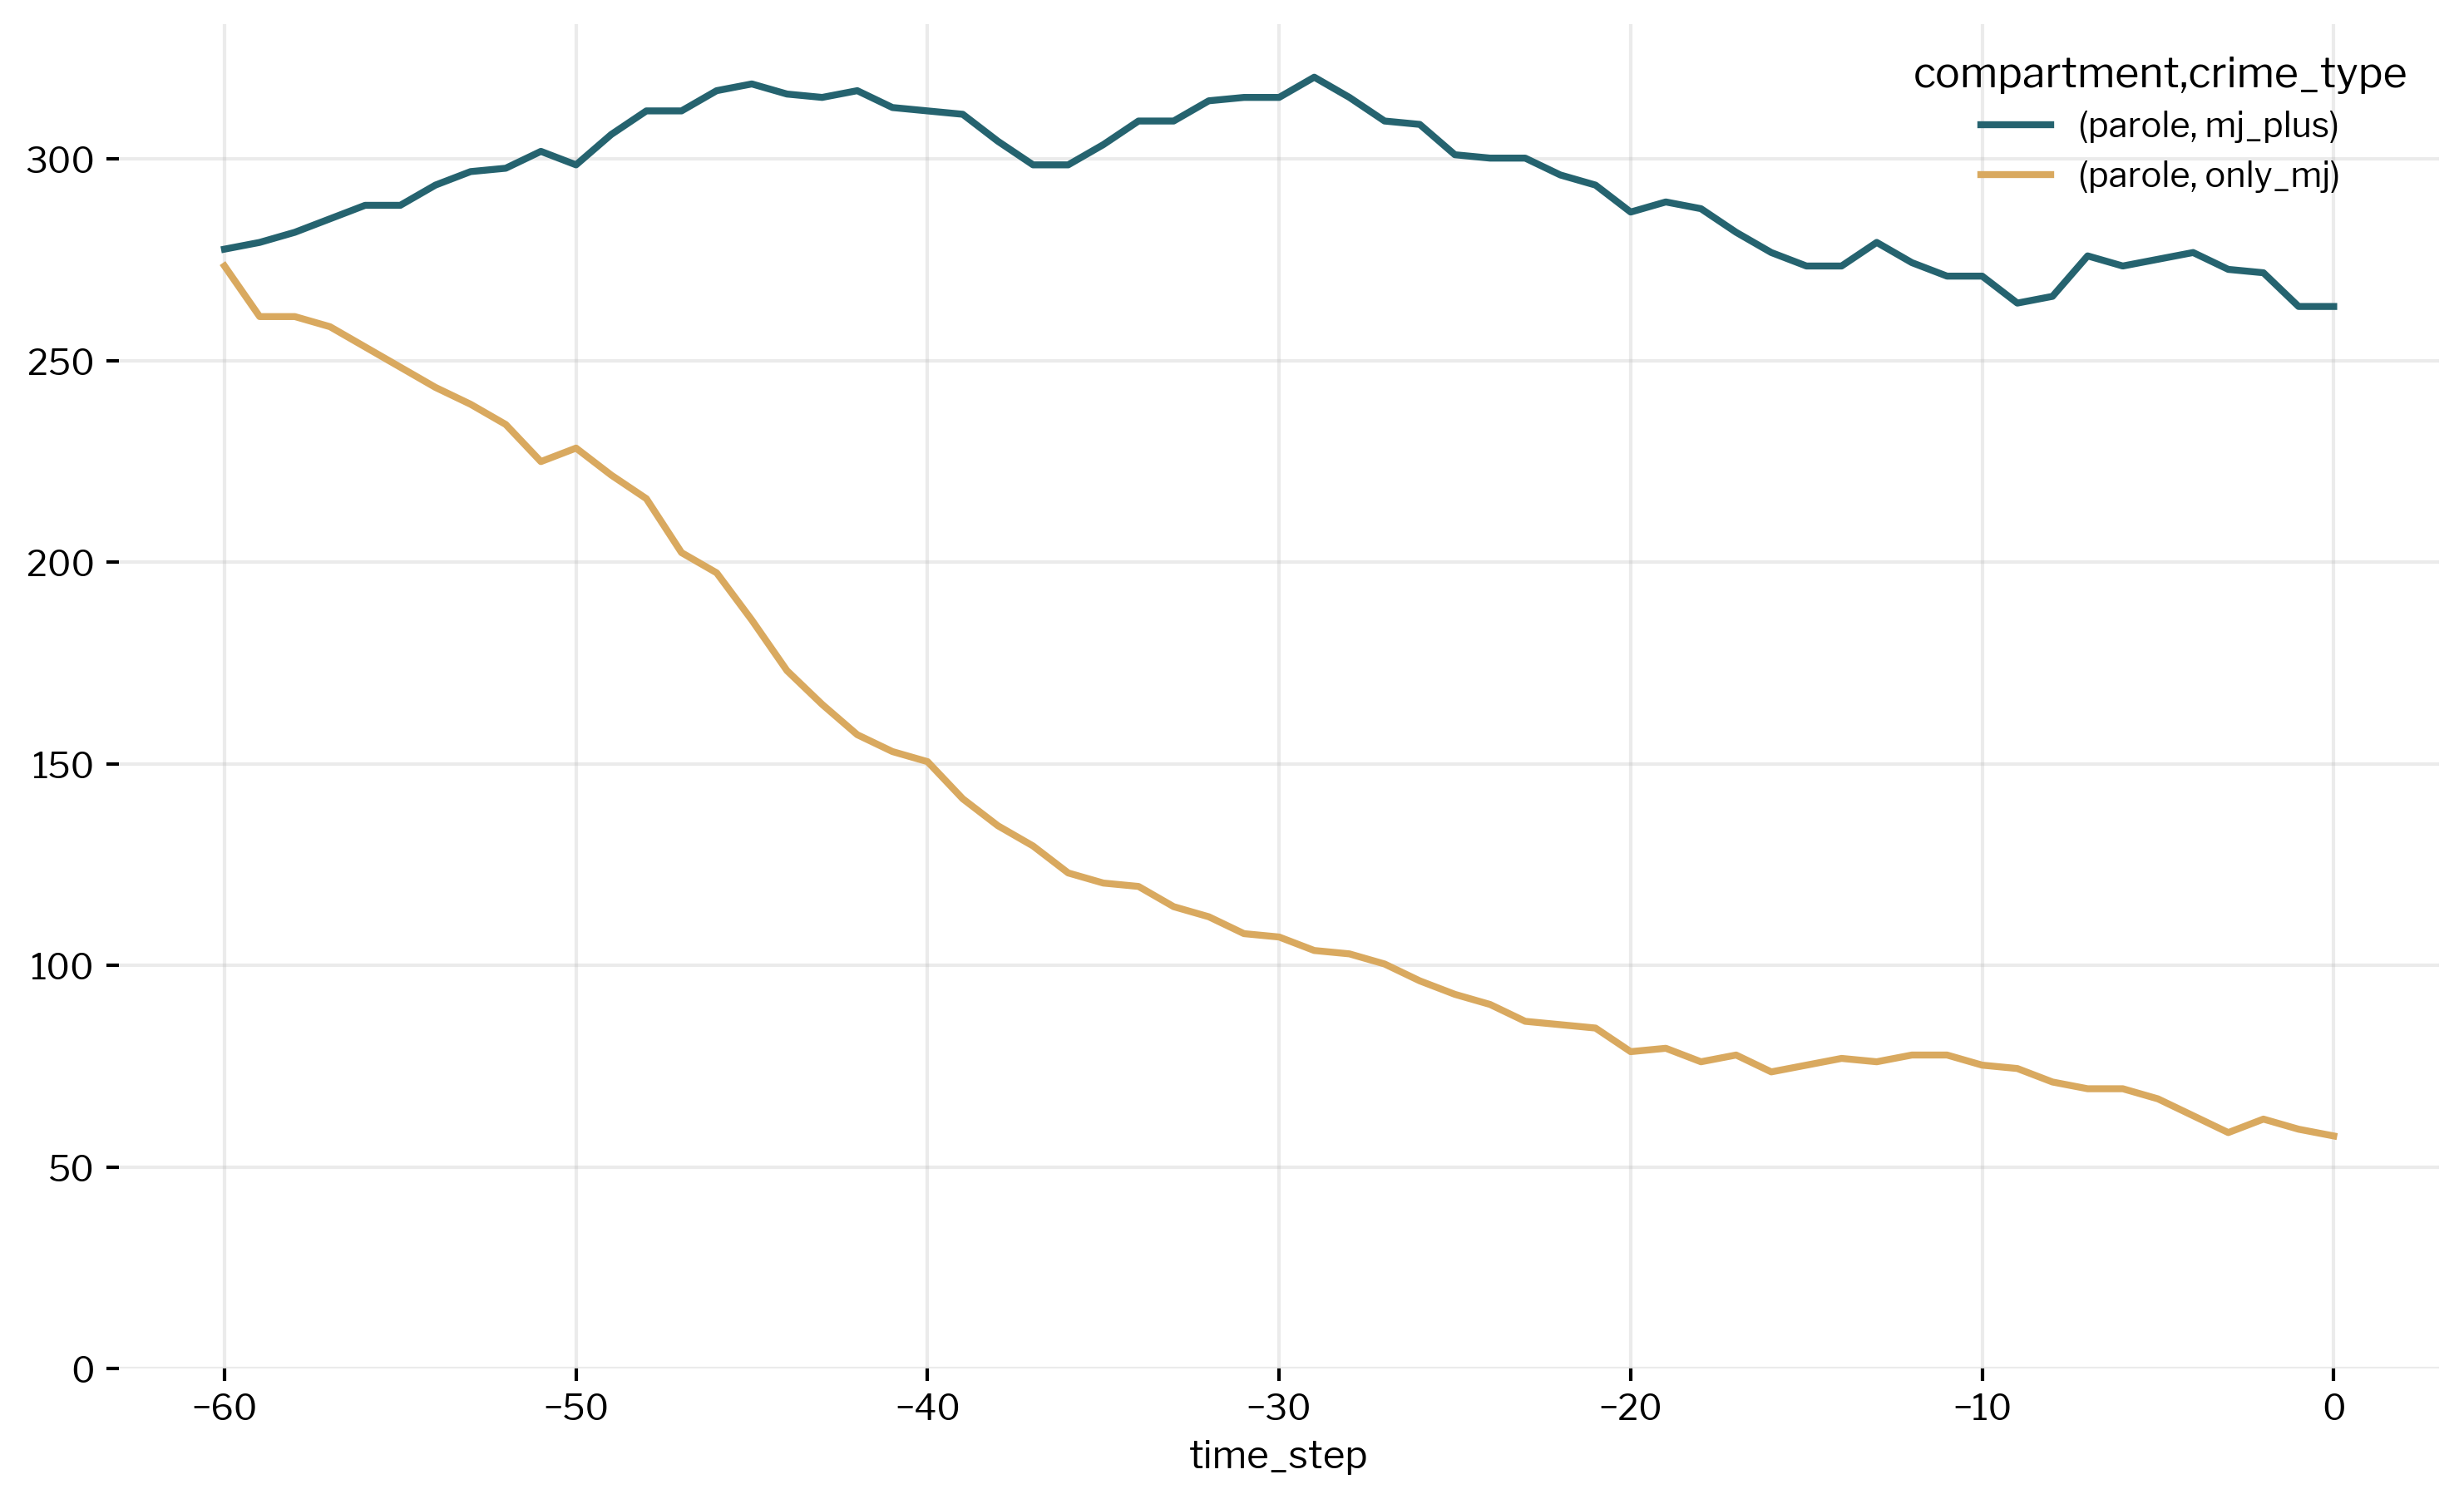

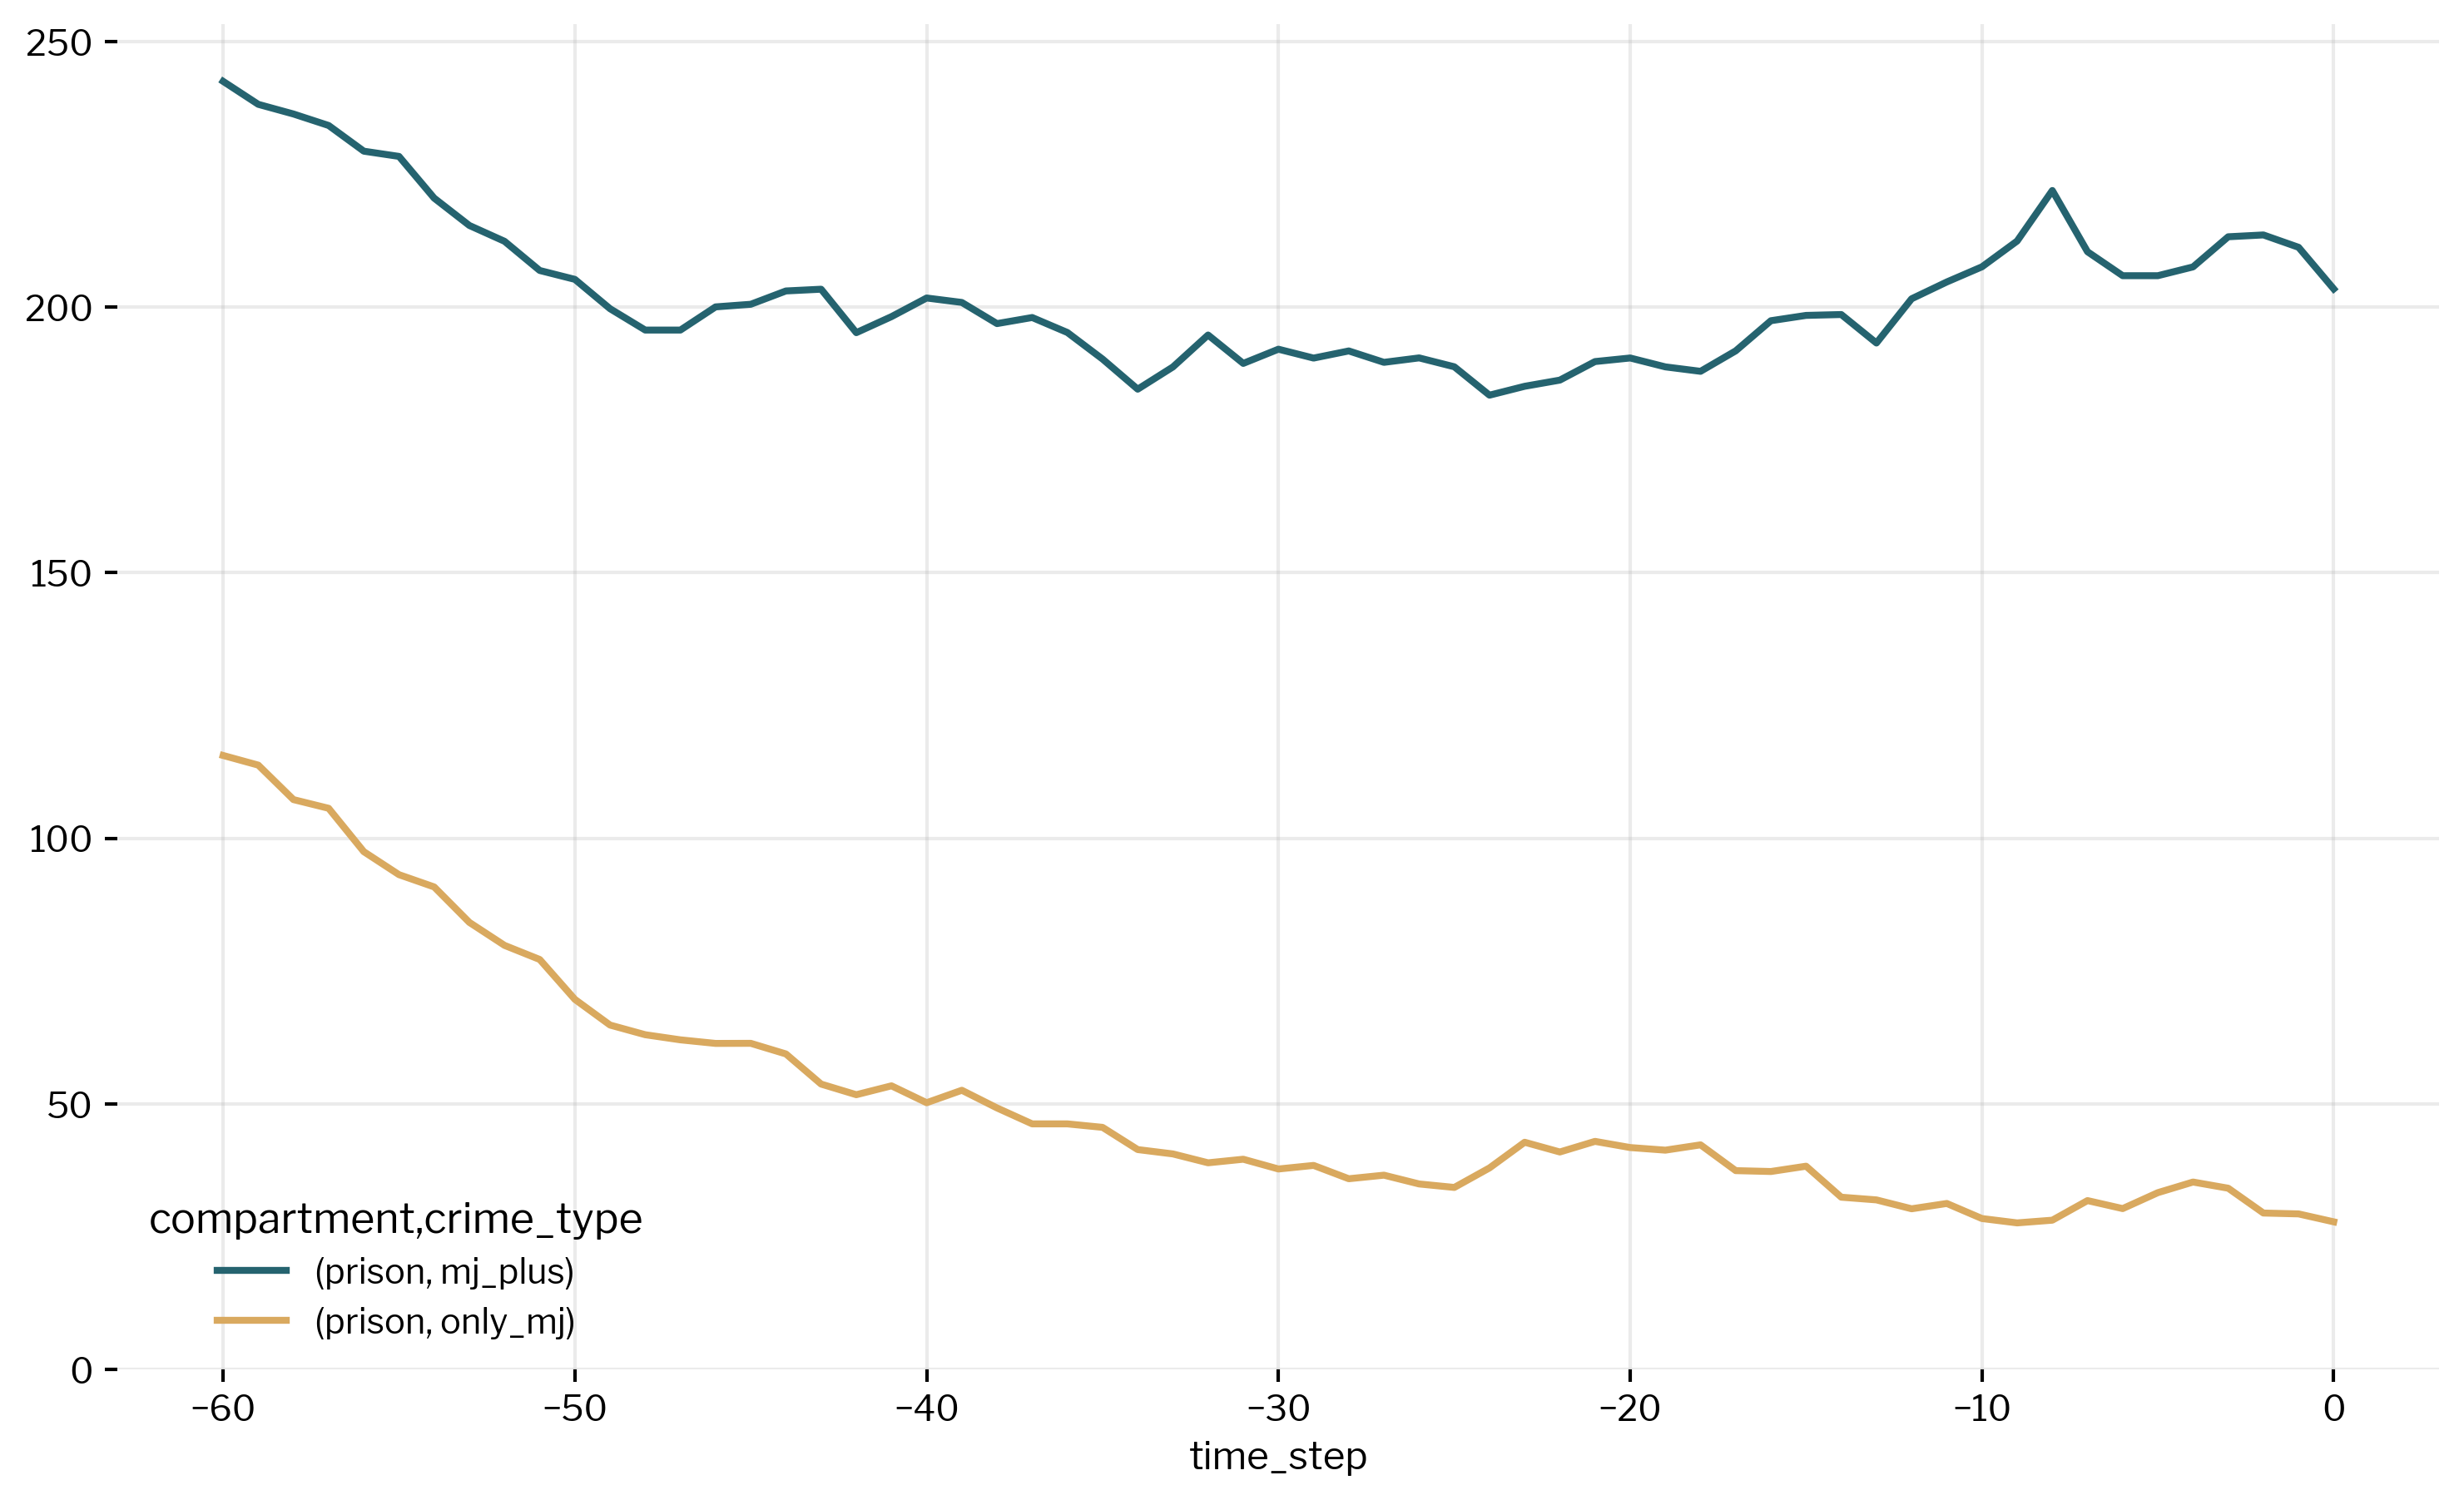

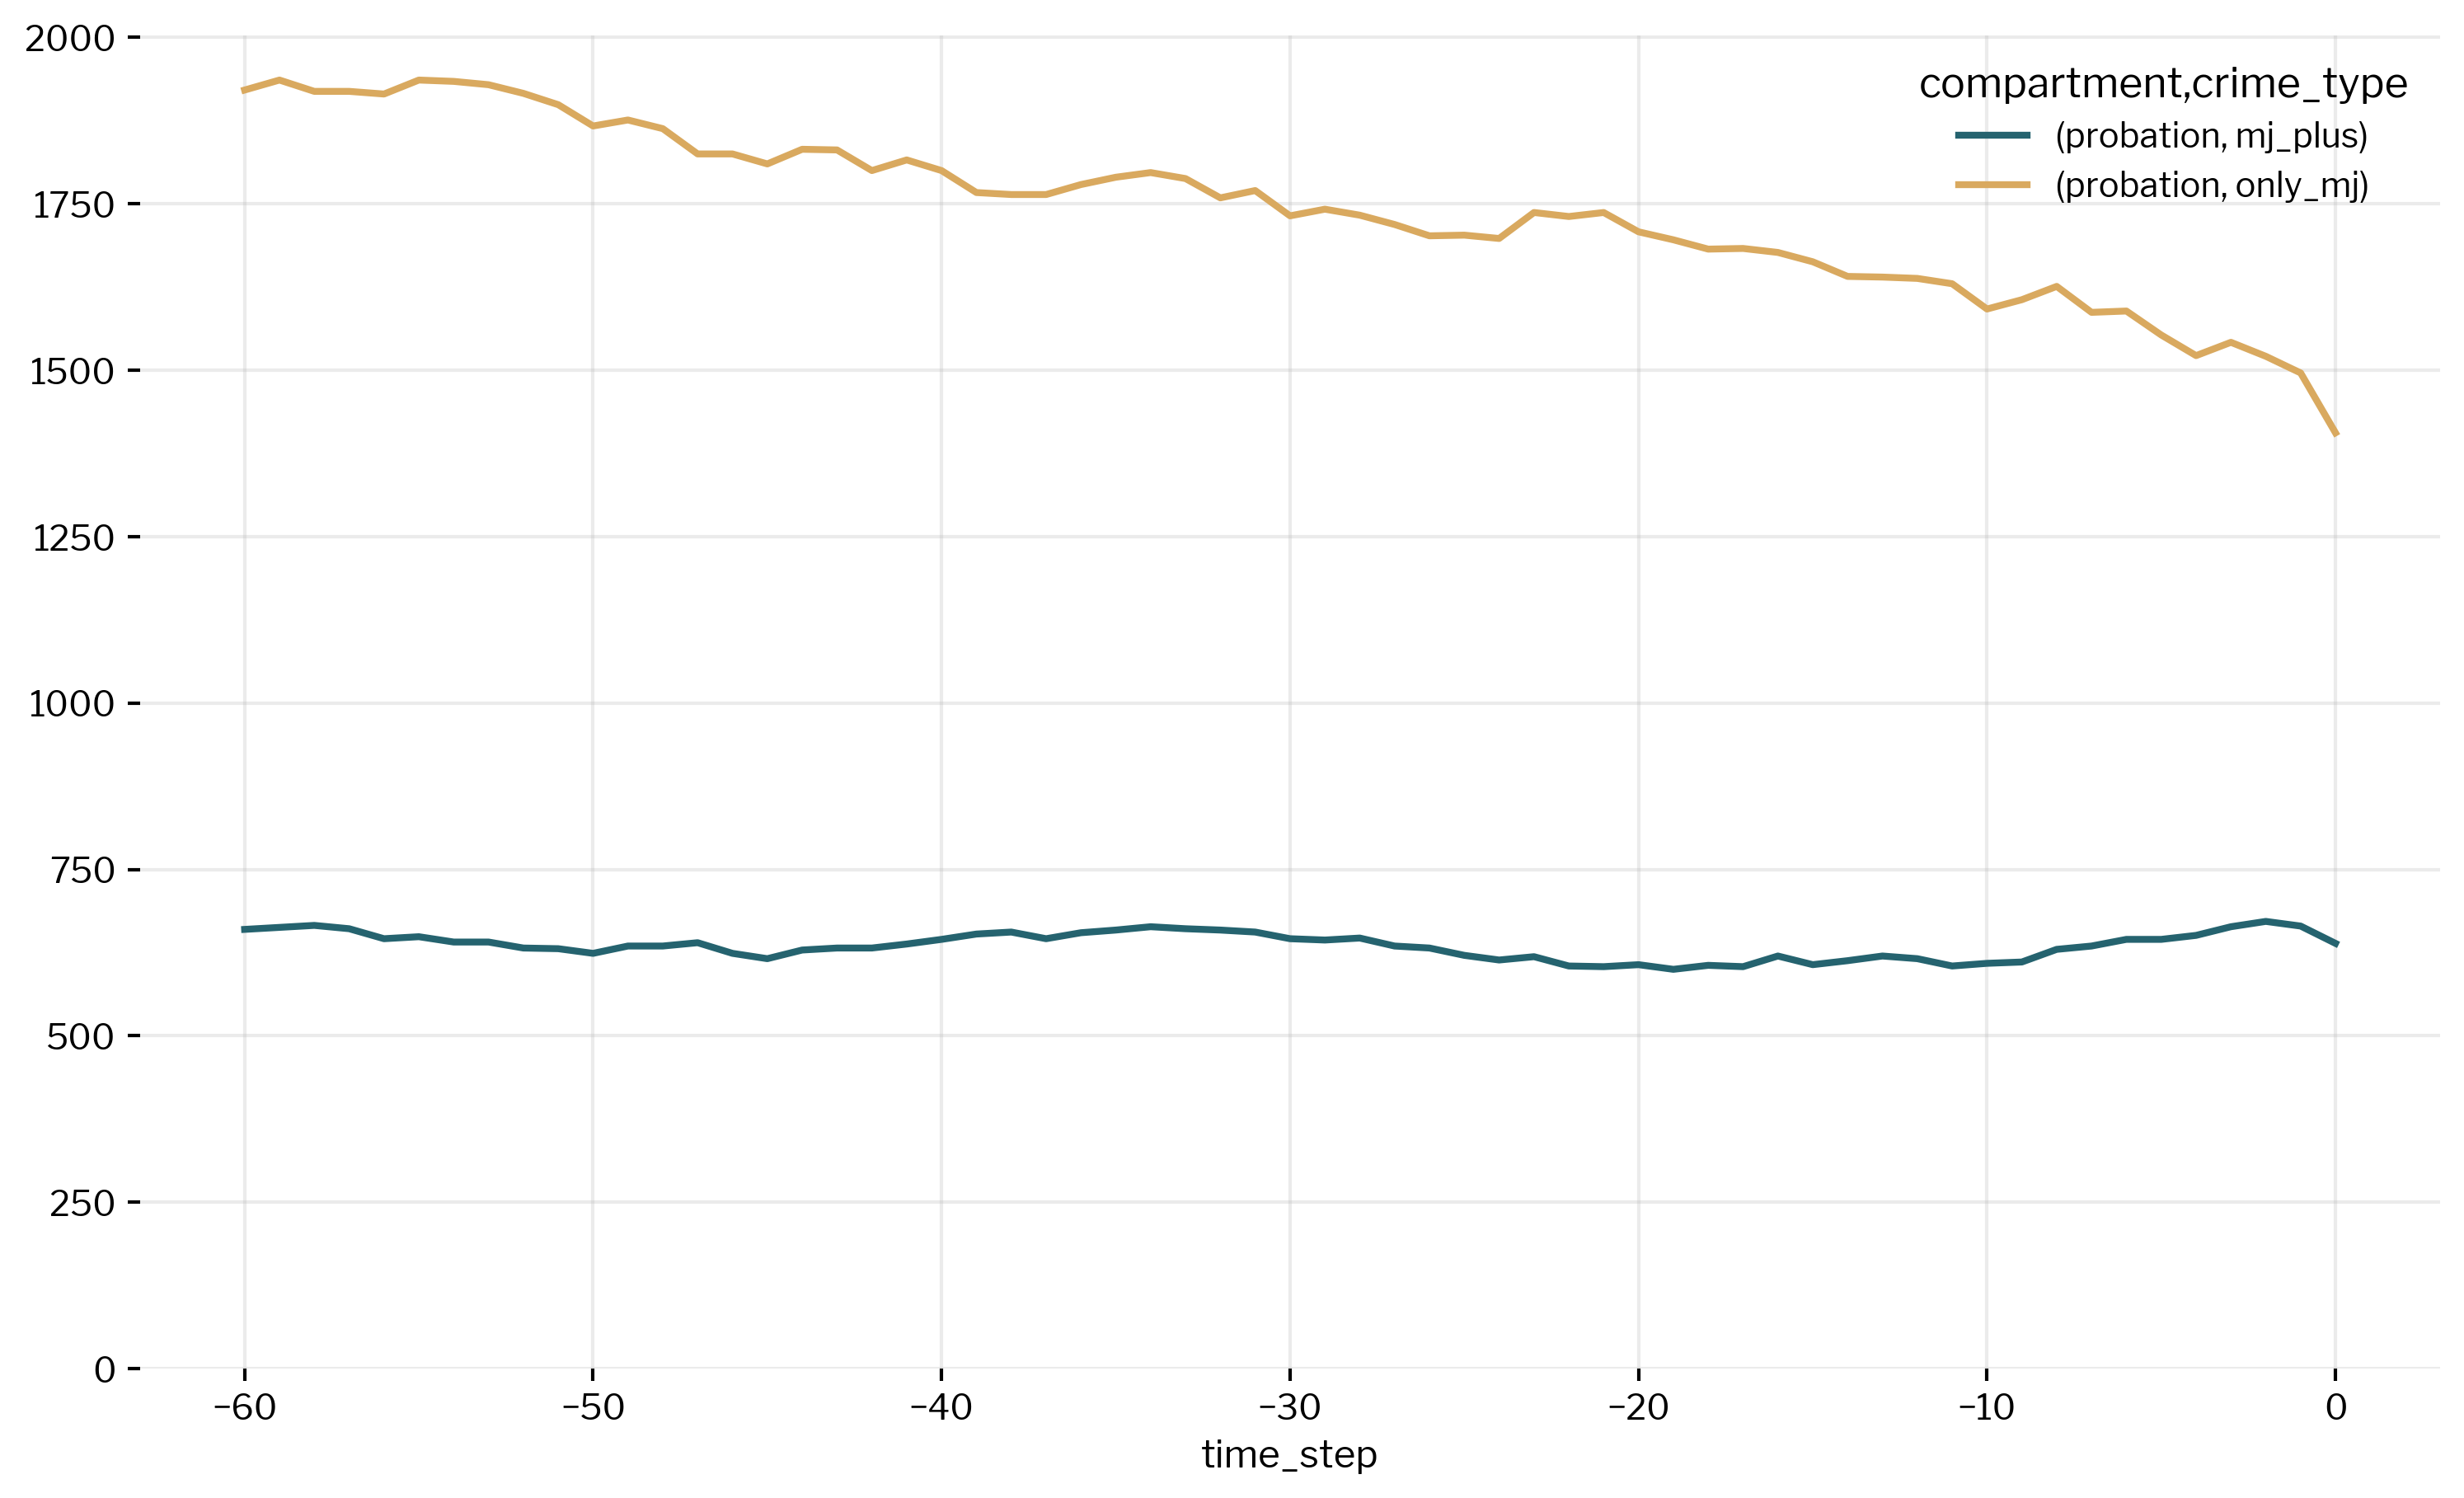

In [76]:
# disagg_for_plot = ["race", "crime"]
disagg_for_plot = ["crime_type"]
for compartment in total_population.compartment.unique():
    total_population.groupby(["time_step", "compartment"] + disagg_for_plot)[
        ["total_population"]
    ].sum().reset_index().pivot(
        index="time_step",
        columns=["compartment"] + disagg_for_plot,
        values="total_population",
    )[
        [compartment]
    ].plot()
    plt.ylim(0)

## Outflows

In [77]:
# truncate start date to month intervals
max_eligible_sentences = get_max_eligible_sentences(sentence_groups_with_mj)
max_eligible_mj_sentences_with_month = max_eligible_sentences[
    ["ID", "dos", "sentence_compartment", "start_date"] + disaggregation_axes
].copy()
max_eligible_mj_sentences_with_month[
    "month"
] = max_eligible_mj_sentences_with_month.start_date.dt.to_period("M").dt.to_timestamp()

In [78]:
# group by disagg and sentence start month
monthly_admissions_data = (
    max_eligible_mj_sentences_with_month[
        max_eligible_mj_sentences_with_month.month < "2020-01-01"
    ]
    .groupby(disaggregation_axes + ["sentence_compartment", "month"])[["ID"]]
    .nunique()
    .rename(columns={"ID": "admissions"})
)
monthly_admissions_data["compartment"] = "pretrial"
monthly_admissions_data.rename(
    columns={"sentence_compartment": "outflow_to"}, inplace=True
)

In [79]:
# for each crime_type
outflows = pd.DataFrame()
for group, group_monthly_admissions in monthly_admissions_data.groupby(
    disaggregation_axes + ["sentence_compartment"]
):
    # merge PA mj arrest data through 2022-10-01
    admissions_with_arrests = pd.merge(
        group_monthly_admissions.reset_index([0, 1]),
        monthly_pa_mj_arrest_data_clean,
        how="outer",
        left_index=True,
        right_index=True,
    )
    admissions_with_arrests[
        disaggregation_axes + ["sentence_compartment", "compartment"]
    ] = admissions_with_arrests[
        disaggregation_axes + ["sentence_compartment", "compartment"]
    ].fillna(
        method="ffill"
    )

    # count up arrests and admissions for months where we have data for both
    # 2017-01-01 thru 2019-12-01
    # calculate average rate of arrest->admission rate
    admissions_and_arrests_populated = admissions_with_arrests[
        (admissions_with_arrests.index >= start_date_for_recent_arrest_data)
        & (admissions_with_arrests.index <= end_date_for_sentencing_comm_data)
    ]

    admissions_with_arrests["avg_arrest_to_admission_rate"] = (
        admissions_and_arrests_populated.admissions.sum()
        / admissions_and_arrests_populated.avg_arrests_per_month.sum()
    )
    # Calculate projected prison admissions thru 2022 based on average arrest->incarceration ratio for 2017-2019
    admissions_with_arrests["calc_admissions_by_month"] = (
        admissions_with_arrests.avg_arrests_per_month
        * admissions_with_arrests.avg_arrest_to_admission_rate
    )

    # combine historical admission data pre-2020 and projected admissions 2020 onwards
    admissions_with_arrests[
        "total_population"
    ] = admissions_with_arrests.admissions.astype("float64").combine_first(
        admissions_with_arrests.calc_admissions_by_month
    )

    # add to full outflows table
    outflows = pd.concat([outflows, admissions_with_arrests])

outflows.index = convert_dates(time_converter, outflows.reset_index()["index"].dt.date)
outflows = outflows.reset_index()
outflows = outflows[
    ["index"] + disaggregation_axes + ["sentence_compartment", "total_population"]
].copy()
outflows["compartment"] = "pretrial"
outflows = outflows.rename(
    columns={"index": "time_step", "sentence_compartment": "outflow_to"}
)
outflows = outflows[outflows.time_step >= -60]
outflows.head()

,time_step,crime_type,outflow_to,total_population,compartment
60,-60,mj_plus,jail,11.0,pretrial
61,-59,mj_plus,jail,8.0,pretrial
62,-58,mj_plus,jail,9.0,pretrial
63,-57,mj_plus,jail,6.0,pretrial
64,-56,mj_plus,jail,10.0,pretrial


/var/folders/jn/2ddz89hx6tjf4m3dvz3dch840000gn/T/ipykernel_52537/1297518652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  outflows.groupby(["time_step", "crime_type", "outflow_to"]).sum().reset_index().pivot(


<AxesSubplot: xlabel='time_step'>

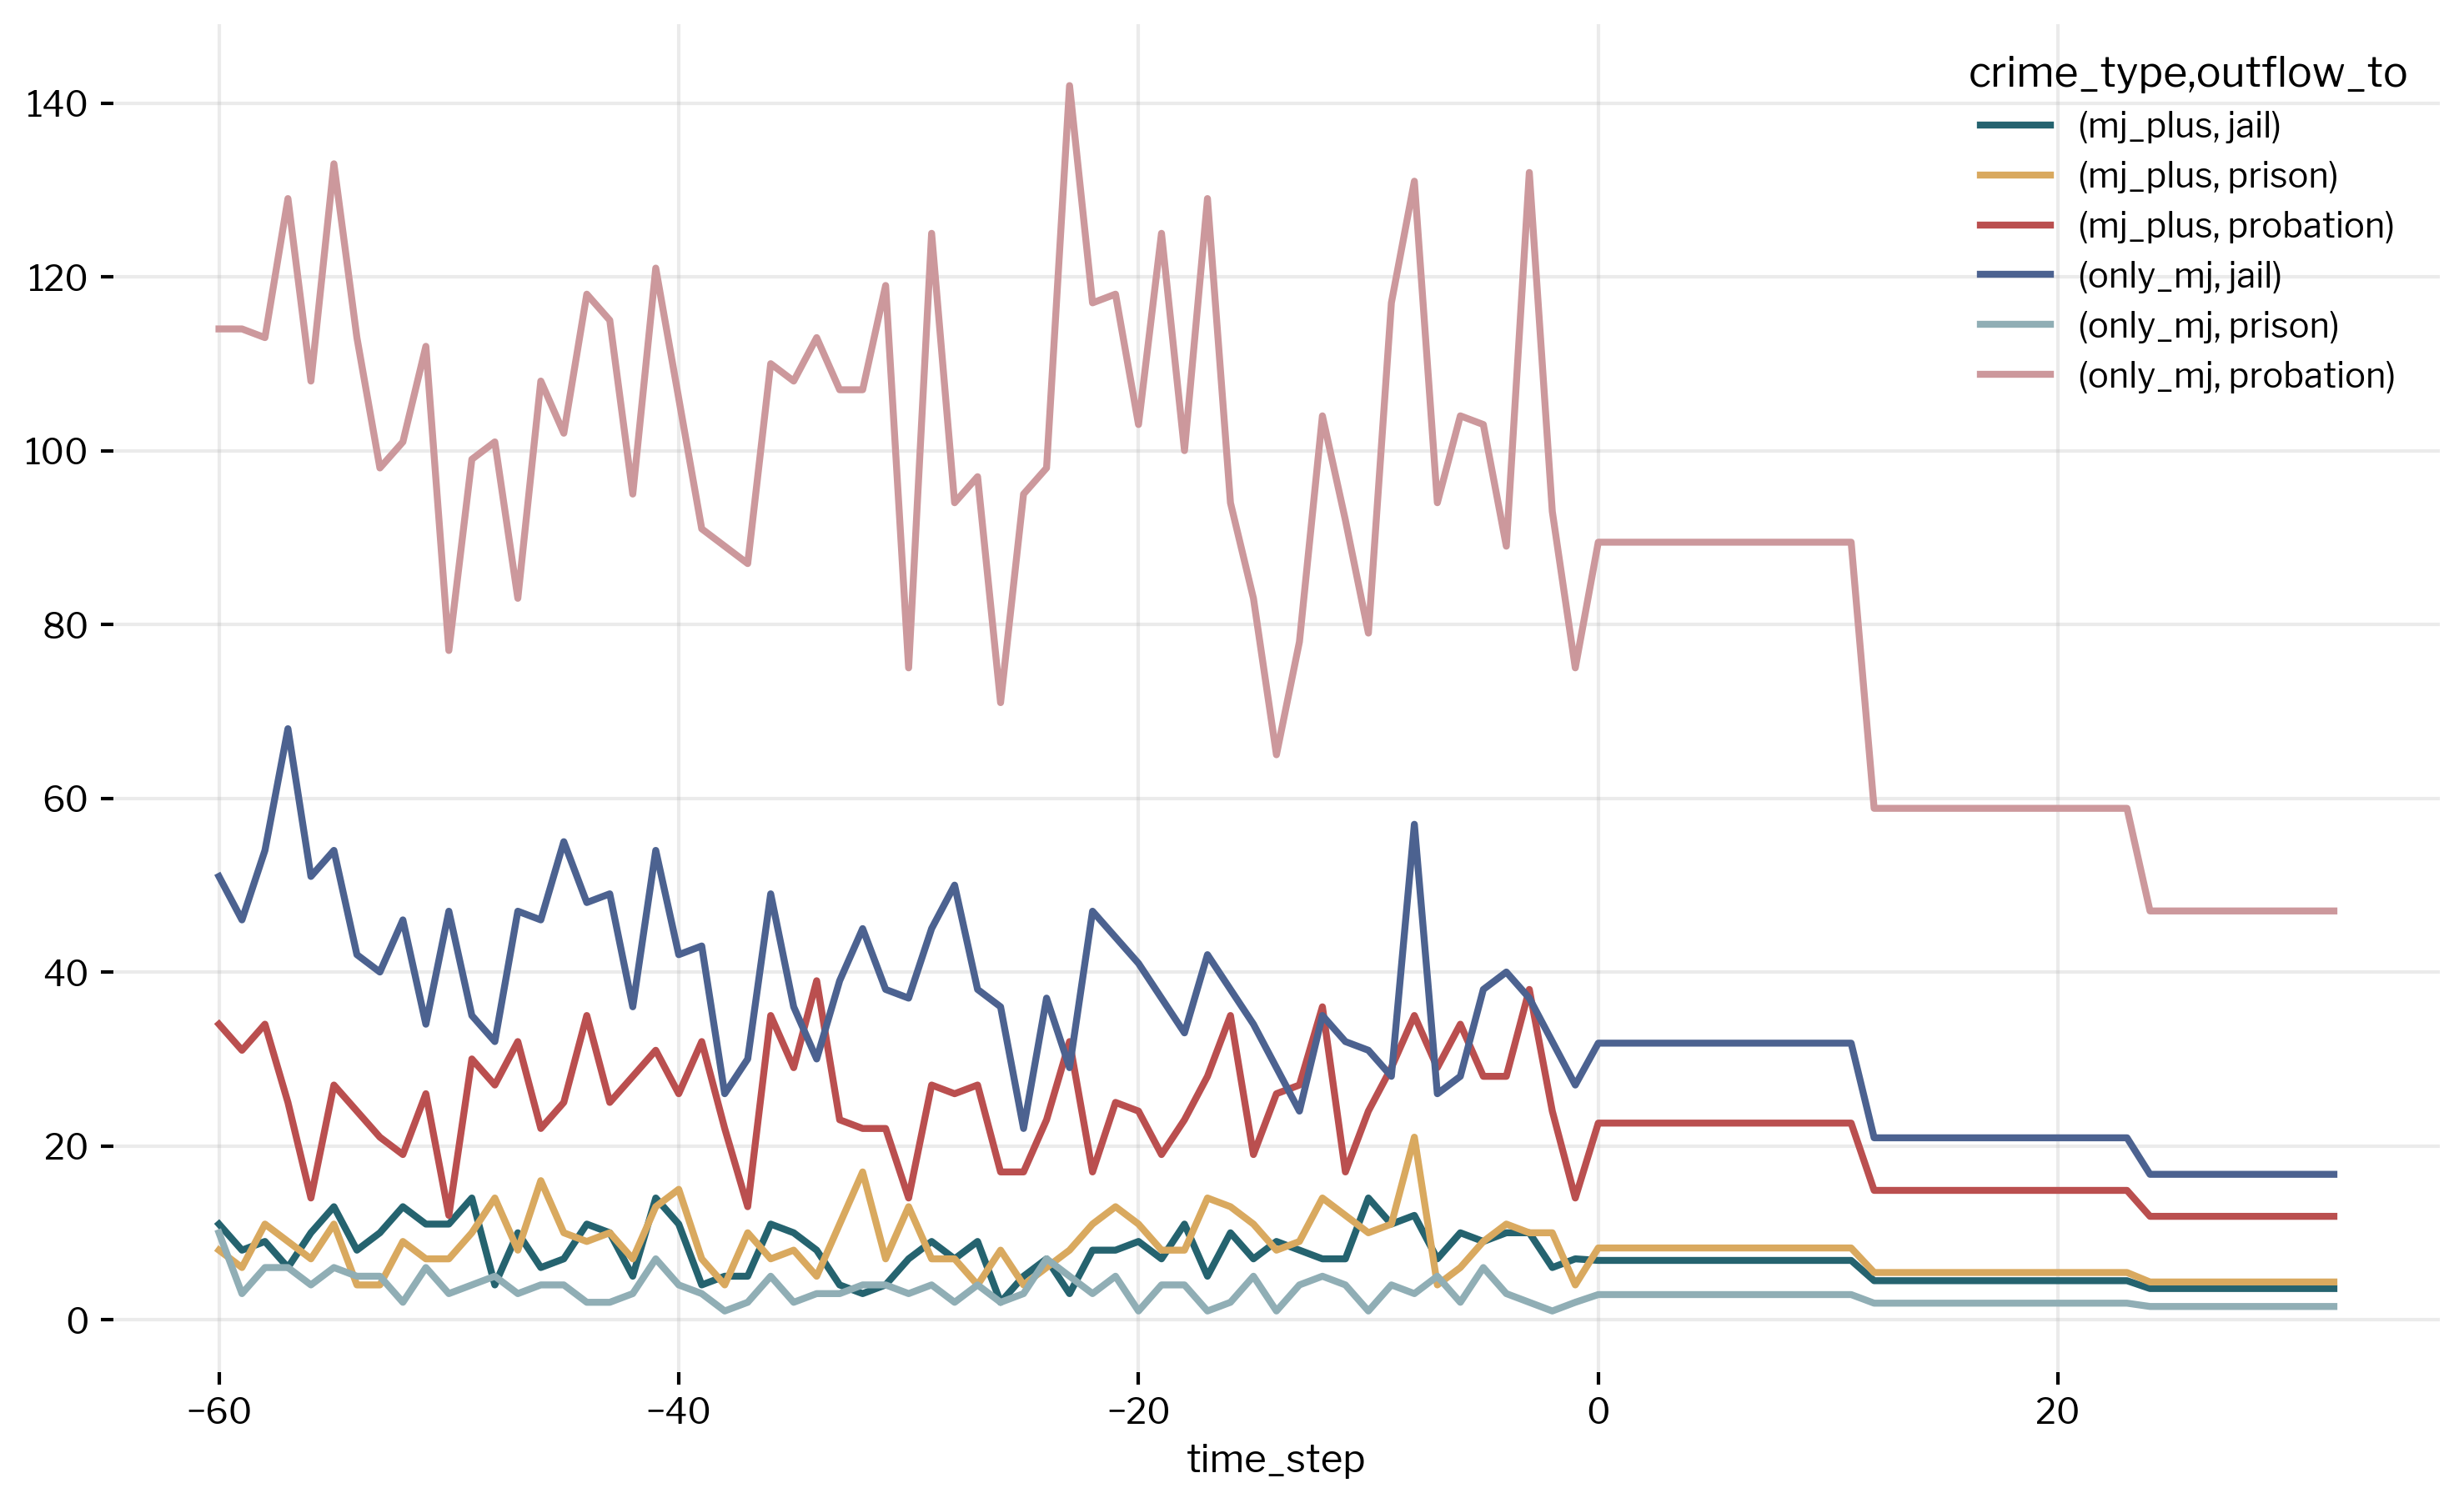

In [80]:
outflows.groupby(["time_step", "crime_type", "outflow_to"]).sum().reset_index().pivot(
    index="time_step", columns=["crime_type", "outflow_to"], values="total_population"
).plot()

In [81]:
simulation_tag

'pa_mj_decrim_2023_full_mapping_v3'

In [82]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=outflows,
    transitions_data_df=transitions,
    total_population_data_df=total_population,
    yaml_path=yaml_file_path,
)

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]


# old / stats

In [666]:
sentence_groups_with_mj.drop_duplicates(
    subset=sentence_grouping
).lowest_reduction.value_counts()

1.00    21309
0.20     3643
0.05     1598
0.00      667
Name: lowest_reduction, dtype: int64

In [543]:
# sentence_groups_with_mj.lowest_reduction.value_counts()

In [544]:
# sentence_groups_with_mj[sentence_groups_with_mj.crime_type=='only_mj'].is_mj_offense.value_counts()

In [545]:
# (
#     sentence_groups_with_mj[
#         (sentence_groups_with_mj.reduction==0)
#          (~sentence_groups_with_mj.all_mj)
#         & (sentence_groups_with_mj.crime_type == 'only_mj')
#         & (~sentence_groups_with_mj.is_mj_offense)


#     ].description.value_counts()
#     .sort_values(by=sentence_grouping + ["los"])
#     .drop_duplicates(subset=sentence_grouping)
#     .head(111)
# )

In [546]:
# (
#     sentence_groups_with_mj[
#         ~sentence_groups_with_mj.all_mj
#     ]
#     .sort_values(by=sentence_grouping + ["los"])
# #     .drop_duplicates(subset=sentence_grouping)
#     .head(1)
# )

In [549]:
# len(sentence_groups_mj_removed)#.drop_duplicates(subset=sentence_grouping))

In [550]:
sentence_groups_mj_removed.drop_duplicates(
    subset=sentence_grouping
).lowest_reduction.value_counts()

0.20    3643
0.05    1598
0.00     667
Name: lowest_reduction, dtype: int64

In [566]:
eligible_sessions_post_policy.crime_type.value_counts()

mj_plus    8662
Name: crime_type, dtype: int64

In [567]:
eligible_sessions_with_mj.crime_type.value_counts()

only_mj    23447
mj_plus     8662
Name: crime_type, dtype: int64

In [613]:
reindexed = []
for g, df in transitions.groupby(["crime_type", "compartment", "outflow_to"]):
    df.set_index("compartment_duration", inplace=True)
    rei = df.reindex(np.arange(1, max(df.index) + 1), fill_value=0.0).reset_index()
    rei[["crime_type", "compartment", "outflow_to"]] = g
    reindexed.append(rei)
transitions_reindexed = pd.concat(reindexed)

In [654]:
only_mj_add_on = (
    transitions[transitions.crime_type == "only_mj"].groupby("compartment").head(1)
)
only_mj_add_on.compartment_duration = 1.0
only_mj_add_on

,crime_type,compartment,outflow_to,compartment_duration,total_population
111,only_mj,jail,liberty,1.0,505.000000
126,only_mj,parole,liberty,1.0,0.836864
144,only_mj,prison,liberty,1.0,0.163136
176,only_mj,probation,liberty,1.0,8.000000
1,only_mj,liberty,liberty,1.0,1.000000


In [655]:
transitions_policy_to_write = pd.concat(
    [
        transitions_policy,
        #         transitions_policy.drop(indexduration),
        #         transitions_policy.groupby(["crime_type", "compartment", "outflow_to"]).head(
        #             10
        #         ),
        only_mj_add_on,
    ]
)

In [657]:
transitions.groupby(
    ["crime_type", "compartment", "outflow_to"]
).compartment_duration.max()

crime_type  compartment  outflow_to
mj_plus     jail         liberty        15.0
            liberty      liberty         1.0
            parole       liberty       119.0
            prison       liberty        99.0
                         parole         67.0
            probation    liberty       120.0
only_mj     jail         liberty        24.0
            liberty      liberty         1.0
            parole       liberty        60.0
            prison       liberty        49.0
                         parole         33.0
            probation    liberty       120.0
Name: compartment_duration, dtype: float64

In [658]:
transitions_policy_to_write.groupby(
    ["crime_type", "compartment", "outflow_to"]
).compartment_duration.max()

crime_type  compartment  outflow_to
mj_plus     jail         liberty        12.0
            liberty      liberty         1.0
            parole       liberty       119.0
            prison       liberty        99.0
                         parole         67.0
            probation    liberty       120.0
only_mj     jail         liberty         1.0
            liberty      liberty         1.0
            parole       liberty         1.0
            prison       liberty         1.0
            probation    liberty         1.0
Name: compartment_duration, dtype: float64

In [84]:
transitions[
    (transitions.compartment == "parole") & (transitions.crime_type == "mj_plus")
]

,crime_type,compartment,outflow_to,compartment_duration,total_population
14,mj_plus,parole,liberty,6.0,4.181298
15,mj_plus,parole,liberty,9.0,1.672519
16,mj_plus,parole,liberty,10.0,1.672519
17,mj_plus,parole,liberty,12.0,22.579010
18,mj_plus,parole,liberty,15.0,10.871375
19,mj_plus,parole,liberty,18.0,36.795423
20,mj_plus,parole,liberty,21.0,1.672519
21,mj_plus,parole,liberty,22.0,0.836260
22,mj_plus,parole,liberty,24.0,30.941606
23,mj_plus,parole,liberty,27.0,4.181298


In [85]:
transitions_policy[
    (transitions_policy.compartment == "parole")
    & (transitions_policy.crime_type == "mj_plus")
]

,crime_type,compartment,outflow_to,compartment_duration,total_population
13,mj_plus,parole,liberty,0.0,0.836260
14,mj_plus,parole,liberty,3.0,2.508779
15,mj_plus,parole,liberty,5.0,8.362596
16,mj_plus,parole,liberty,6.0,4.181298
17,mj_plus,parole,liberty,8.0,0.836260
18,mj_plus,parole,liberty,10.0,18.397712
19,mj_plus,parole,liberty,11.0,7.526337
20,mj_plus,parole,liberty,12.0,7.526337
21,mj_plus,parole,liberty,14.0,19.233971
22,mj_plus,parole,liberty,15.0,0.836260


In [86]:
transitions_policy.shape

(175, 5)

In [93]:
t_policy_cropped = transitions_policy[
    (transitions_policy.compartment_duration < 10)
    | (transitions_policy.compartment_duration > 90)
    | (transitions_policy.compartment != "parole")
]

In [103]:
transitions_policy.to_csv("alt_transitions_policy.csv", index=False)

In [101]:
transitions_policy.total_population = transitions_policy.total_population.round(1)

In [97]:
transitions_policy.iloc[55, 4] = 2

In [91]:
transitions_policy[
    (transitions_policy.compartment_duration < 10)
    | (transitions_policy.compartment_duration > 90)
    | (transitions_policy.compartment != "parole")
].groupby(["crime_type", "compartment", "outflow_to"]).compartment_duration.count()

crime_type  compartment  outflow_to
mj_plus     jail         liberty       13
            liberty      liberty        1
            parole       liberty        8
            prison       liberty       42
                         parole        38
            probation    liberty       33
only_mj     jail         liberty        1
            liberty      liberty        1
            parole       liberty        1
            prison       liberty        1
            probation    liberty        1
Name: compartment_duration, dtype: int64

In [90]:
transitions_policy.groupby(
    ["crime_type", "compartment", "outflow_to"]
).compartment_duration.count()

crime_type  compartment  outflow_to
mj_plus     jail         liberty       13
            liberty      liberty        1
            parole       liberty       43
            prison       liberty       42
                         parole        38
            probation    liberty       33
only_mj     jail         liberty        1
            liberty      liberty        1
            parole       liberty        1
            prison       liberty        1
            probation    liberty        1
Name: compartment_duration, dtype: int64

In [102]:
transitions_policy[
    (transitions_policy.compartment == "parole")
    & (transitions_policy.crime_type == "mj_plus")
]

,crime_type,compartment,outflow_to,compartment_duration,total_population
13,mj_plus,parole,liberty,0.0,0.8
14,mj_plus,parole,liberty,3.0,2.5
15,mj_plus,parole,liberty,5.0,8.4
16,mj_plus,parole,liberty,6.0,4.2
17,mj_plus,parole,liberty,8.0,0.8
18,mj_plus,parole,liberty,10.0,18.4
19,mj_plus,parole,liberty,11.0,7.5
20,mj_plus,parole,liberty,12.0,7.5
21,mj_plus,parole,liberty,14.0,19.2
22,mj_plus,parole,liberty,15.0,0.8


In [104]:
transitions_policy[
    (transitions_policy.compartment == "jail")
    & (transitions_policy.crime_type == "mj_plus")
]

,crime_type,compartment,outflow_to,compartment_duration,total_population
0,mj_plus,jail,liberty,0.0,51.0
1,mj_plus,jail,liberty,1.0,35.0
2,mj_plus,jail,liberty,2.0,28.0
3,mj_plus,jail,liberty,3.0,27.0
4,mj_plus,jail,liberty,4.0,11.0
5,mj_plus,jail,liberty,5.0,28.0
6,mj_plus,jail,liberty,6.0,20.0
7,mj_plus,jail,liberty,7.0,16.0
8,mj_plus,jail,liberty,8.0,3.0
9,mj_plus,jail,liberty,9.0,34.0


In [105]:
transitions[(transitions.compartment == "jail") & (transitions.crime_type == "mj_plus")]

,crime_type,compartment,outflow_to,compartment_duration,total_population
0,mj_plus,jail,liberty,0.0,36.0
1,mj_plus,jail,liberty,1.0,31.0
2,mj_plus,jail,liberty,2.0,11.0
3,mj_plus,jail,liberty,3.0,42.0
4,mj_plus,jail,liberty,4.0,9.0
5,mj_plus,jail,liberty,5.0,4.0
6,mj_plus,jail,liberty,6.0,52.0
7,mj_plus,jail,liberty,7.0,3.0
8,mj_plus,jail,liberty,8.0,6.0
9,mj_plus,jail,liberty,9.0,29.0
